# Stratified LD Score regression after heritability filter
## Checking heritability computed on DNAm

In [1]:
library(here)
library(data.table)
library(tidyverse)
library(parallel)
library(glue)
library(ggsci)

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




probe,V(G),V(e),Vp,V(G)/Vp,logL,logL0,LRT,Pval,V(G)_SE,V(e)_SE,Vp_SE,V(G)/Vp_SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cg00000029,0.014699,0.176618,0.191317,0.076832,41.664,37.479,8.370,1.91e-03,0.010041,0.016250,0.017702,0.049899
cg00000108,0.336076,0.072536,0.408613,0.822481,90.523,-21.504,224.053,0.00e+00,0.069762,0.007647,0.069107,0.035863
cg00000109,0.000000,0.080807,0.080807,0.000001,148.617,148.617,0.000,5.00e-01,0.001653,0.007277,0.007129,0.020453
cg00000165,0.001287,0.106842,0.108129,0.011907,111.422,111.331,0.183,3.34e-01,0.003213,0.009780,0.009558,0.029633
cg00000236,0.001661,0.059108,0.060769,0.027332,186.183,185.565,1.236,1.33e-01,0.002108,0.005383,0.005415,0.034262
cg00000289,0.050336,0.071638,0.121974,0.412679,129.968,105.339,49.257,1.12e-12,0.015407,0.007401,0.015317,0.084071


[1] 164434

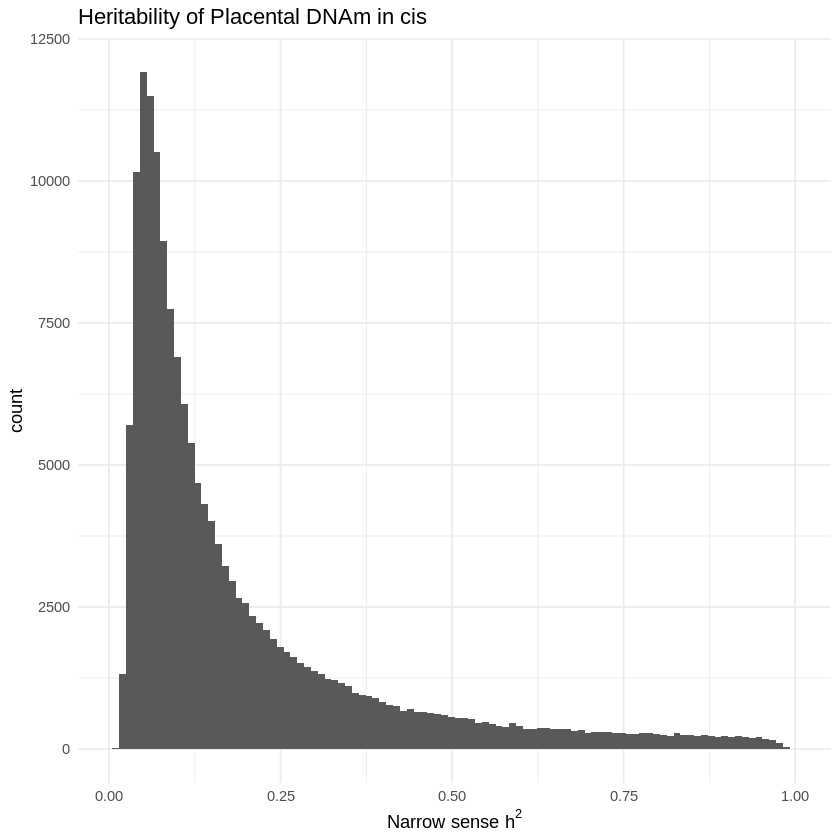

In [2]:
if(file.exists(here("data","cis_heritability.txt.gz"))){
    current_heritability <- fread(here("data","cis_heritability.txt.gz"))
}else{
    h_files <- dir(here("data", "gcta_analysis", "delahaye_output"))
    cpgs <- gsub(".hsq", "", h_files)

    read_heritability <- function(fname){
        dt <- fread(fname,fill=TRUE)
        main_cols <- transpose(dt[1:8,c(2)])
        colnames(main_cols) <- dt$Source[1:8]
        se_cols <- transpose(dt[1:4,c(3)])
        colnames(se_cols) <- paste0(dt$Source[1:4],"_SE")
        return(cbind(data.table(probe=gsub(".*/(.*).hsq","\\1",fname)),main_cols,se_cols))
    }
    current_heritability <- rbindlist(
        mclapply(
            here("data","gcta_analysis","delahaye_output",h_files),
            read_heritability,
            mc.cores = 32
        )
    )
   fwrite(current_heritability,here("data","cis_heritability.txt.gz"),sep='\t',quote=FALSE,row.names=FALSE)
}

head(current_heritability)

nrow(current_heritability[Pval < 0.10])
ggplot(current_heritability[Pval < 0.10],aes(x=`V(G)/Vp`)) +
    geom_histogram(bins=100)+
    labs(
        x = bquote(Narrow~sense~h^2),
        title = "Heritability of Placental DNAm in cis"
    )+
    theme_minimal()

## Create mQTL annotation filtering CAVIAR results with heritable CpGs

In [2]:
generate_annotation <- function(mQTL_annot, baseline_annot_f,chrom,annot){
    baseline_annot <- fread(baseline_annot_f)
    if(annot != "all_cis"){
        tmp <- mQTL_annot[current_heritability[Pval < 0.1]$probe,on="probe"][CHR == chrom]
    }
    if(annot == "bin_CPP"){
        merged <- merge(
            baseline_annot,
            tmp[,.(bin_CPP=ifelse(any(CPP>0),1,0)),by="SNP"],
            by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(bin_CPP = ifelse(is.na(bin_CPP),0,bin_CPP))]
        return(merged[,.(CHR,BP,SNP,CM,bin_CPP)])    
    }else if(annot == "maxCPP"){
        merged <- merge(
            baseline_annot,
            tmp[,.(maxCPP=max(CPP)),by="SNP"],
               by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(maxCPP = ifelse(is.na(maxCPP),0,maxCPP))]
        return(merged[,.(CHR,BP,SNP,CM,maxCPP)])    
    }else if (annot == "all_cis"){
        merged <- merge(
            baseline_annot,
            mQTL_annot[,.(all_cis=ifelse(any(FDR < 0.05),1,0)),by="SNP"],by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(all_cis = ifelse(is.na(all_cis),0,all_cis))]
        return(merged[,.(CHR,BP,SNP,CM,all_cis)])    
        
    }else{
        print("NO ANNOTATION SELECTED")
        return(NULL)
    }
}

# build all annotations except male and female specific
for(annot in c("bin_CPP","maxCPP")){
    for(cur_mqtl in c("marginal","sex_interaction","male","female", "cord_mqtl")){
        if(cur_mqtl == "cord_mqtl"){
            mQTL_annot <- fread(glue("../data/{cur_mqtl}_caviar.txt.gz"))    
        }else{
            mQTL_annot <- fread(glue("../data/{cur_mqtl}_meta_caviar_maf01.txt.gz"))
        }
        cur_annot <- mclapply(
            1:22,
            function(i){
                generate_annotation(
                    mQTL_annot,
                    glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
                    glue("{i}"),
                    annot
                )
            },
            mc.cores=16
        ) 
        mclapply(1:22, function(i)
            fwrite(
                cur_annot[[i]],
                glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_{annot}_her.{i}.annot.gz"),
                sep='\t',quote=FALSE,row.names=FALSE
            ),
            mc.cores=16
        )
    }
}

# build all annotations except male and female specific for cis mQTL, FDR threshold
setDTthreads(2)
for(cur_mqtl in c("marginal","sex_interaction","male","female", "cord_mqtl")){
    if(cur_mqtl == "cord_mqtl"){
        mQTL_annot <- fread(glue("../../ariesmqtl/cord.ALL.M.tab"))    
    }else{
        mQTL_annot <- fread(glue("../data/delahaye_richs_{cur_mqtl}_mecs_maf01_FDR.txt.gz"))
    }
    cur_annot <- mclapply(
        1:22,
        function(i){
            generate_annotation(
                mQTL_annot,
                glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
                glue("{i}"),
                "all_cis"
            )
        },
        mc.cores=8
    ) 
    mclapply(1:22, function(i)
        fwrite(
            cur_annot[[i]],
            glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_all_cis_fdr.{i}.annot.gz"),
            sep='\t',quote=FALSE,row.names=FALSE
        ),
        mc.cores=8
    )
}

### Male and female specific binCPP annotations

In [5]:
generate_sex_specific_annotation <- function(mQTL_annot, baseline_annot_f,chrom,annot){
    baseline_annot <- fread(baseline_annot_f)
    if(annot == "bin_CPP"){
        tmp <- mQTL_annot[current_heritability[Pval < 0.1]$probe,on="probe"][CHR == chrom]
        merged <- merge(
            baseline_annot,
            tmp[,.(bin_CPP=ifelse(any(CPP>0),1,0)),by="SNP"],
            by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(bin_CPP = ifelse(is.na(bin_CPP),0,bin_CPP))]
        return(merged[,.(CHR,BP,SNP,CM,bin_CPP)])    
    }else if (annot == "all_cis"){
        merged <- merge(
            baseline_annot,
            mQTL_annot[,.(all_cis=ifelse(any(FDR < 0.05),1,0)),by="SNP"],by="SNP",all.x=TRUE,sort = FALSE)
        merged[, `:=`(all_cis = ifelse(is.na(all_cis),0,all_cis))]
        return(merged[,.(CHR,BP,SNP,CM,all_cis)])    
        
    }else{
        print("NO ANNOTATION SELECTED")
        return(NULL)
    }
}
setDTthreads(8)
# annot <- "bin_CPP"
# sex_interaction_mqtl <- fread(glue("../data/sex_interaction_meta_caviar_maf01.txt.gz"))
# for(cur_mqtl in c("male","female")){
#     mQTL_annot <- fread(glue("../data/{cur_mqtl}_meta_caviar_maf01.txt.gz"))
#     mQTL_annot <- mQTL_annot[sex_interaction_mqtl[,.(SNP,probe)],on=c("SNP","probe"), nomatch=0]
#     cur_annot <- mclapply(
#         1:22,
#         function(i){
#             generate_sex_specific_annotation(
#                 mQTL_annot,
#                 glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
#                 glue("{i}"),
#                 annot
#             )
#         },
#         mc.cores=8
#     ) 
#     mclapply(1:22, function(i)
#         fwrite(
#             cur_annot[[i]],
#             glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_specific_{annot}_her.{i}.annot.gz"),
#             sep='\t',quote=FALSE,row.names=FALSE
#         ),
#         mc.cores=8
#     )
# }

sex_interaction_mqtl <- fread(glue("../data/delahaye_richs_sex_interaction_mecs_maf01_FDR.txt.gz"))
for(cur_mqtl in c("male","female")){
    mQTL_annot <- fread(glue("../data/delahaye_richs_{cur_mqtl}_mecs_maf01_FDR.txt.gz"))
    mQTL_annot <- mQTL_annot[sex_interaction_mqtl[,.(SNP,Probe)],on=c("SNP","Probe"), nomatch=0]
    cur_annot <- mclapply(
        1:22,
        function(i){
            generate_sex_specific_annotation(
                mQTL_annot[chr == i],
                glue("../../1000G_v2.2_baseline/baselineLD.{i}.annot.gz"),
                glue("{i}"),
                "all_cis"
            )
        },
        mc.cores=8
    ) 
    mclapply(1:22, function(i)
        fwrite(
            cur_annot[[i]],
            glue("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/{cur_mqtl}_specific_all_cis_fdr.{i}.annot.gz"),
            sep='\t',quote=FALSE,row.names=FALSE
        ),
        mc.cores=8
    )
}

Warning message in fileAccess.default(parent, mode = 2):
“file.access(..., mode=2) and file(..., open="ab") gives different results (0 != -1). Will use the file() results: /tmp/M”


ERROR: [2021-10-20 15:27:08] Exception: Failed to create directory (tried 5 times), most likely because of lack of file permissions (directory '/tmp' exists but nothing beyond): /tmp/pbs.3103469.pbsha.ib.sockeye

Next steps carried out elsewhere:
1. Partition new LD scores
1. Compute stratified LD score regression with each annotation on PGC traits

## Plotting new LDSC results
### Data preparation

In [21]:
gwas_sample_sizes <- function(f){
    N <- fread(f,nrows=1)$N
    GWAS <- str_match(f,".*/(.*).sumstats.gz")[2]
    return(data.table(GWAS=GWAS,N=N))
}
part_heritability_results_independent <- function(path){
    part_heritability <- rbindlist(lapply(
          dir(
            path,
            pattern = "[marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female]_bin_CPP_her_.*.results$",
            full.names = TRUE
          ),
          function(f) {
            labels <- str_match(f, ".*/(marginal|sex_interaction|cord_mqtl|male_specific|female_specific|male|female)_(bin_CPP_her)_(.*).results$")[-c(1)]
            if (any(is.na(labels))) {
              return(data.table())
            } else {
              dt <- fread(f)[1, !"Category"]
              dt[, 
                `:=`(
                  Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
                  mQTL_group = labels[1],
                  annotation = labels[2],
                  GWAS = labels[3])]
              return(dt)
            }
          }
        ))
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*.log$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*)_shared.*.log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[2] & annotation == labels[1]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[1],
            GWAS = labels[2]
          )
          return(dt)
        }
      }
    ))
    heritability <- heritability[which(!duplicated(GWAS))]
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}

part_heritability_results <- function(path,modifier){
    part_heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.results$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(all_cis_fdr|bin_CPP_her|maxCPP_her)_(.*){modifier}.results"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else {
          dt <- fread(f)
          dt[, 
            `:=`(
              Coefficient_p=pnorm(abs(`Coefficient_z-score`),lower.tail=F)*2,
              annotation = labels[1],
              GWAS = labels[2])]
          return(dt)
        }
      }
    ))
    heritability <- rbindlist(lapply(
      dir(
        path,
        pattern = glue(".*{modifier}.log$"),
        full.names = TRUE
      ),
      function(f) {
        labels <- str_match(f, glue(".*/(bin_CPP_her)_(.*){modifier}.log"))[-c(1)]
        if (any(is.na(labels))) {
          return(data.table())
        } else if (nrow(part_heritability[GWAS == labels[2] & annotation == labels[1]]) == 0 ){
          return(data.table())
        }
        else {
          dat <- readLines(f)
          dt <- data.table(
            h2 = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"-*\\d+.\\d+")[[1]][1]),
            h2_std_error = as.numeric(str_extract_all(dat[grepl("Total Observed",dat)],"\\d+.\\d+")[[1]][2]),
            total_SNP = as.numeric(str_match(dat[grepl("SNPs remain)", dat)],"\\((\\d+)")[1,2]),
            annotation = labels[1],
            GWAS = labels[2]
          )
          return(dt)
        }
      }
    ))
    result <- merge(part_heritability,heritability,by=c("GWAS","annotation"))
    return(result)
}
annotation_SD <- function(path,file_pattern){
    annots <- rbindlist(mclapply(dir(path,full.names=TRUE,pattern=file_pattern),function(f) fread(f),mc.cores=22))
    return(apply(annots[,-c(1,2,3,4)],2,sd))    
}
pgc_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_original_baseline/")
neonatal_part_heritability_independent_df <- part_heritability_results_independent("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_neonatal_original_baseline/")
tmp_test <-pgc_part_heritability_independent_df
pgc_part_heritability_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_results/","_shared")
pgc_part_heritability_baseline_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_original_baseline/","_shared")
pgc_part_heritability_baseline_sex_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_pgc_original_baseline/","_shared_no_interaction")
neonatal_part_heritability_sex_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_neonatal_original_baseline/","_shared_no_interaction")
neonatal_part_heritability_df <- part_heritability_results("/scratch/st-dennisjk-1/wcasazza/delahaye_QC/ldsc_meta_EUR_neonatal_original_baseline/","_shared_sex_stratified")
                                 
pgc_GWAS_key <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females",
    "ocd_aug2017" = "OCD",
    "anxiety.meta.full.cc.tbl" = "ANX",
    "anxiety.meta.full.fs.tbl" = "ANXFS",
    "pgc_bip_2018" = "BIP",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "pgcAN2.2019-07.vcf.tsv" = "AN",
    "TS_Oct2018" = "TS",
    "pgc.cross.full.2013-03.txt" = "Cross Disorder",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day"
)
neonatal_GWAS_key <- c(
    "age_asthma_irnt.gwas.imputed_v3.both_sexes.tsv" = "ASTHMA Age(norm)",
    "age_asthma_irnt.gwas.imputed_v3.female.tsv" = "ASTHMA Age(norm) Females",
    "age_asthma_irnt.gwas.imputed_v3.male.tsv"= "ASTHMA Age(norm) Males",
    "age_asthma_raw.gwas.imputed_v3.both_sexes.tsv" = "ASTHMA Age(raw)",
    "age_asthma_raw.gwas.imputed_v3.female.tsv" = "ASTHMA Age(raw) Females",
    "age_asthma_raw.gwas.imputed_v3.male.tsv" = "ASTHMA Age(raw) Males",
    "age_diabetes_irnt.gwas.imputed_v3.both_sexes.tsv" = "DIABETES Age(norm)",
    "age_diabetes_irnt.gwas.imputed_v3.female.tsv"= "DIABETES Age(norm) Females",
    "age_diabetes_irnt.gwas.imputed_v3.male.tsv"= "DIABETES Age(norm) Males",
    "age_diabetes_raw.gwas.imputed_v3.both_sexes.tsv"= "DIABETES Age(raw)",
    "age_diabetes_raw.gwas.imputed_v3.female.tsv"= "DIABETES Age(raw) Females",
    "age_diabetes_raw.gwas.imputed_v3.male.tsv"= "DIABETES Age(raw) Males",
    "age_hay_fever_irnt.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER Age(norm)",
    "age_hay_fever_irnt.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(norm) Females",
    "age_hay_fever_irnt.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(norm) Males",
    "age_hay_fever_raw.gwas.imputed_v3.both_sexes.tsv"= "HAYFEVER Age(raw)",
    "age_hay_fever_raw.gwas.imputed_v3.female.tsv"= "HAYFEVER Age(raw) Females",
    "age_hay_fever_raw.gwas.imputed_v3.male.tsv"= "HAYFEVER Age(raw) Males",
    "CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC" = "CHILD ONSET ASTHMA",
    "EGG_BMI_HapMap_DISCOVERY.txt" = "Child BMI",
    "EGG_HC_DISCOVERY.v2.txt" = "Head Circumference",
    "EGG_Obesity_Meta_Analysis_1.txt" = "Child Obesity",
    "EGG_TANNER_females.v2.txt" = "TANNER Stage Females",
    "EGG_TANNER_males_and_females_combined.v2.txt" = "TANNER Stage",
    "EGG_TANNER_males.v2.txt" = "TANNER Stage Males",
    "EGG-TotalGWG-Offspring.txt" = "Gestational Weight Gain",
    "Pubertal_growth_10F_12M_combined.txt" = "Pubertal Growth Start",
    "Pubertal_growth_10F.txt" = "Pubertal Growth Start Females",
    "Pubertal_growth_12M.txt" = "Pubertal Growth Start Males",
    "Pubertal_growth_PGF_PGM_combined.txt" = "Total Pubertal Growth",
    "Pubertal_growth_PGF.txt" = "Total Pubertal Growth Females",
    "Pubertal_growth_PGM.txt" = "Total Pubertal Growth Males",
    "Pubertal_growth_PTF_PTM_combined.txt" = "Late Pubertal Growth",
    "Pubertal_growth_PTF.txt" = "Late Pubertal Growth Females",
    "Pubertal_growth_PTM.txt" = "Late Pubertal Growth Males",
    "ukbb_preeclampsia.gwas.imputed_v3.female.tsv"= "Pre-Eclampsia During Pregnancy"
)
compulsive <- c(
    "pgcAN2.2019-07.vcf.tsv" = "AN",
    "ocd_aug2017" = "OCD",
    "TS_Oct2018" = "TS"
)
psychotic <- c(
    "pgc_bip_2018" = "BIP",
    "PGC3_SCZ_wave3_public.v2.tsv" = "SCZ",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC"
)
neurodevelopmental <- c(
    "TS_Oct2018" = "TS",
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "adhd_jul2017" = "ADHD",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "pts_all_freeze2_overall.results" = "PTSD",
    "PGC_UKB_depression_genome-wide.txt" = "MDD"
)
internalizing <- c(
    "pts_all_freeze2_overall.results" = "PTSD",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "anxiety.meta.full.cc.tbl" = "ANX",
    "anxiety.meta.full.fs.tbl" = "ANXFS"
)
substance_set <- c(
    "pgc_alcdep.eur_unrelated.aug2018_release.txt" = "ALC",
    "Cannabis_ICC_23andmetop_UKB_het.txt" = "Cannabis",
    "tag.cpd.tbl" = "Cigarettes Per Day",
    "AUDIT_UKB_2018_AJP.txt" = "Alcohol (AUDIT)"
)

sex_stratified_set <- c(
    "adhd_jul2017" = "ADHD",
    "pgc_adhd_males" = "ADHD Males",
    "pgc_adhd_females" = "ADHD Females",
    "pts_all_freeze2_overall.results" = "PTSD",
    "pts_all_freeze2_males.results" = "PTSD Males",
    "pts_all_freeze2_females.results" = "PTSD Females",
    "iPSYCH-PGC_ASD_Nov2017" = "ASD",
    "NEW_META_PGC_iPSYCH_ASD_males" = "ASD Males",
    "NEW_META_PGC_iPSYCH_ASD_females" = "ASD Females",
    "PGC_UKB_depression_genome-wide.txt" = "MDD",
    "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt" = "MDD Males",
    "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt" = "MDD Females"
)
                                 
                                 
                                 
neonatal_part_heritability_independent_df <- neonatal_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!neonatal_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=neonatal_GWAS_key))
                                 
pgc_part_heritability_independent_df <- pgc_part_heritability_independent_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(mQTL_group,marginal="Cross-sex",sex_interaction="Sex dependent", male_specific = "Male Specific", female_specific= "Female Specific",male= "Male Stratified", female="Female Stratified", cord_mqtl='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))  
                                 
pgc_part_heritability_df <- pgc_part_heritability_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1="Sex Interaction", L2_2= "Male", L2_3="Female", L2_4='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))
pgc_part_heritability_baseline_df <- pgc_part_heritability_baseline_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1="Sex Interaction", L2_2= "Male", L2_3="Female", L2_4='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))
pgc_part_heritability_baseline_sex_df <- pgc_part_heritability_baseline_sex_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!pgc_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1= "Male Specific", L2_2="Female Specific", L2_3='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=pgc_GWAS_key))
neonatal_part_heritability_sex_df <- neonatal_part_heritability_sex_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!neonatal_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1= "Male Specific", L2_2="Female Specific", L2_3='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=neonatal_GWAS_key))
neonatal_part_heritability_df <- neonatal_part_heritability_df %>% mutate(
        significant_coef = Coefficient_p < 0.05, 
        significant_enrich = Enrichment_p < 0.05,
        GWAS = recode(GWAS, !!!neonatal_GWAS_key),
        Category = recode(Category,L2_0="Marginal",L2_1="Sex Interaction", L2_2= "Male", L2_3="Female", L2_4='Cord Blood')
    ) %>%
    mutate(GWAS = factor(GWAS,levels=neonatal_GWAS_key))                               

### Plotting trait-level heritability

In [22]:
unique(tmp_test$GWAS)

[1] "AUDIT_UKB_2018_AJP.txt"                      
 [2] "Cannabis_ICC_23andmetop_UKB_het.txt"         
 [3] "NEW_META_PGC_iPSYCH_ASD_females"             
 [4] "NEW_META_PGC_iPSYCH_ASD_males"               
 [5] "PGC3_SCZ_wave3_public.v2.tsv"                
 [6] "PGC_UKB_depression_genome-wide.txt"          
 [7] "TS_Oct2018"                                  
 [8] "adhd_jul2017"                                
 [9] "anxiety.meta.full.cc.tbl"                    
[10] "anxiety.meta.full.fs.tbl"                    
[11] "iPSYCH-PGC_ASD_Nov2017"                      
[12] "meta_STDERR_mdd_eur_auto_F1_08_gcOFF_pgc.txt"
[13] "meta_STDERR_mdd_eur_auto_M1_08_gcOFF_pgc.txt"
[14] "ocd_aug2017"                                 
[15] "pgc.cross.full.2013-03.txt"                  
[16] "pgcAN2.2019-07.vcf.tsv"                      
[17] "pgc_adhd_females"                            
[18] "pgc_adhd_males"                              
[19] "pgc_alcdep.eur_unrelated.aug2018_release.txt"
[20] "pgc_bip_2018"                                
[21] "pts_all_freeze2_females.results"             
[22] "pts_all_freeze2_males.results"               
[23] "pts_all_freeze2_overall.results"             
[24] "tag.cpd.tbl"

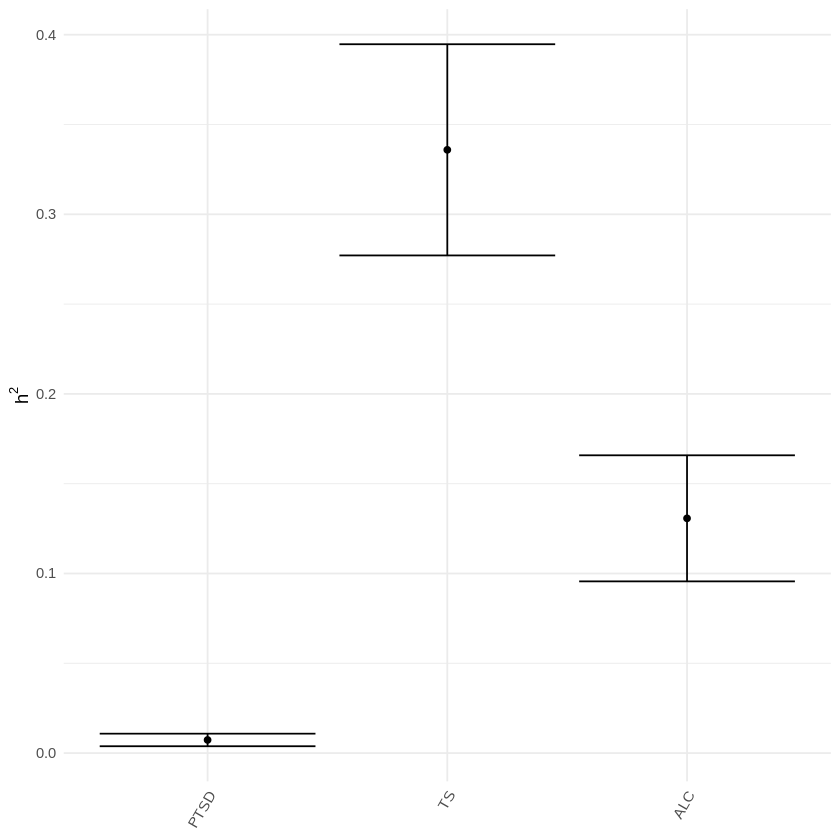

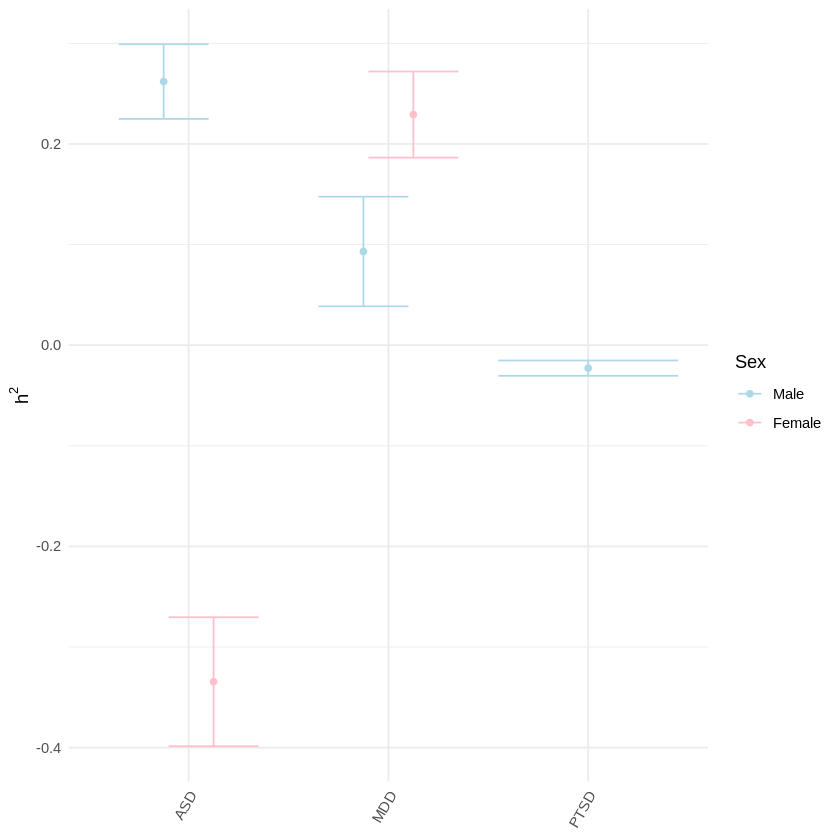

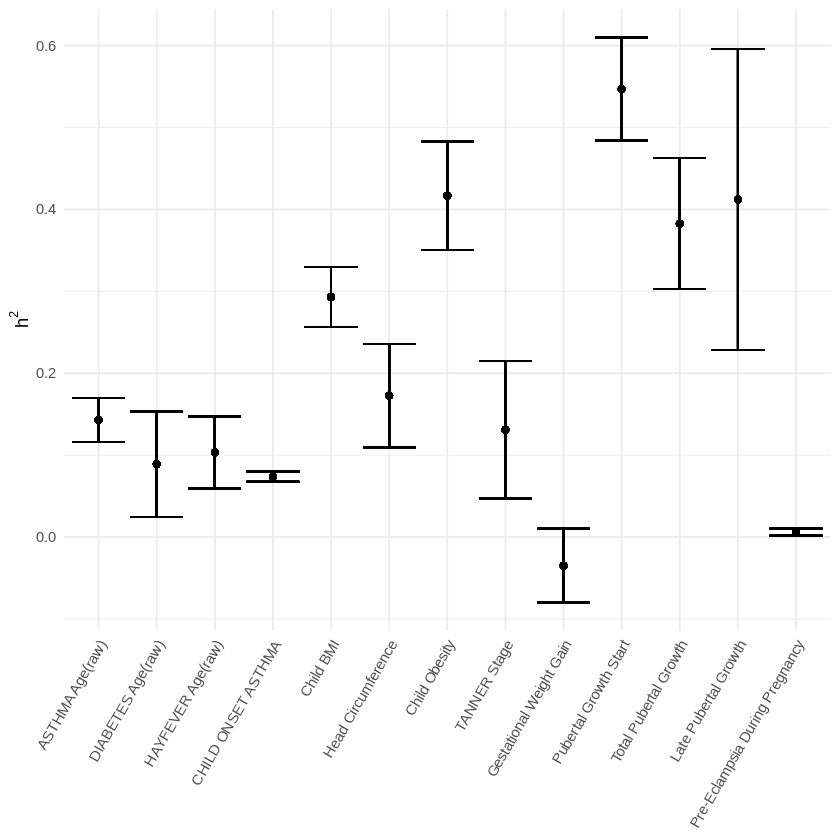

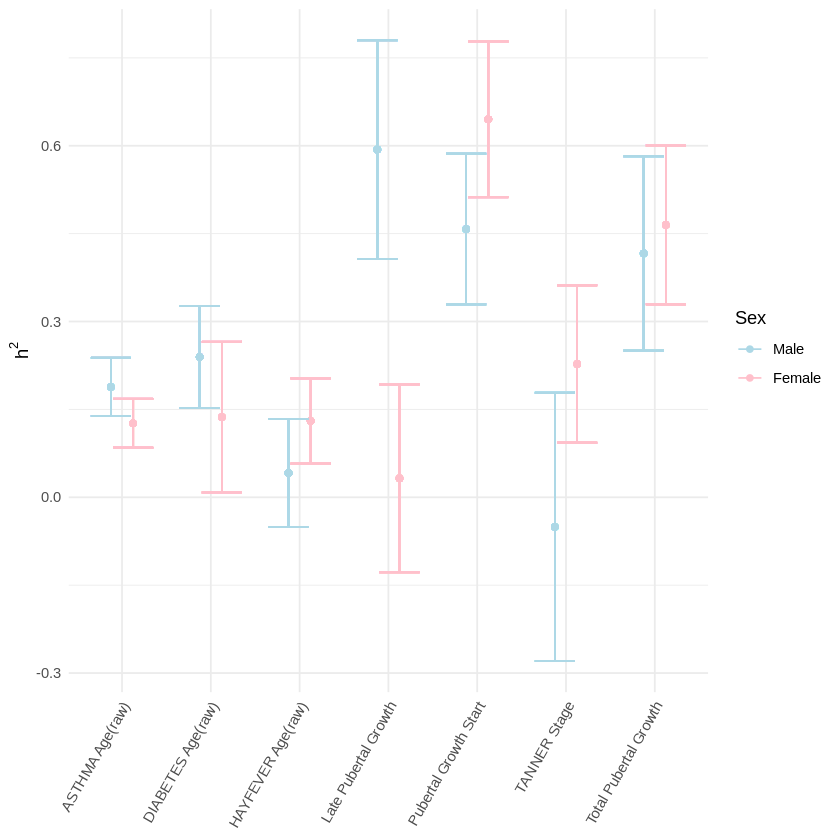

In [23]:
ggplot(pgc_part_heritability_independent_df[!grepl("Males|Females",GWAS) & !GWAS %in% c("ANXFS","Alcohol (AUDIT)","Cannabis","Cigarettes Per Day") & Category=="Cross-sex" & annotation == "bin_CPP_her",.(h2=h2,h2_se=h2_std_error,GWAS)],aes(GWAS,h2,ymin=h2-h2_se,ymax=h2+h2_se)) +
    geom_point()+
    geom_errorbar() + 
    theme_minimal() + 
    labs(y = bquote(h^2),x=NULL)+
    theme(axis.text.x=element_text(hjust=1,vjust=1,angle=60))
ggplot(pgc_part_heritability_independent_df[
        grepl("Males|Females",GWAS) & !GWAS %in% c("ANXFS","Alcohol (AUDIT)","Cannabis","Cigarettes Per Day") & Category=="Cross-sex" & annotation == "bin_CPP_her",
        .(h2=h2,h2_se=h2_std_error, GWAS=gsub(" Males| Females","",GWAS),Sex = factor(gsub(".* (Male|Female)s", "\\1",GWAS),levels=c("Male","Female")))
    ],
    aes(GWAS,h2,ymin=h2-h2_se,ymax=h2+h2_se,color=Sex)) +
    geom_point(position=position_dodge(width=0.5))+
    geom_errorbar(position=position_dodge(width=0.5))+
    scale_color_manual(values=c("lightblue","pink"))+
    theme_minimal() + 
    labs(y = bquote(h^2),x=NULL)+
    theme(axis.text.x=element_text(hjust=1,vjust=1,angle=60))                                 
ggplot(neonatal_part_heritability_sex_df[!grepl("Males|Females",GWAS) & !grepl("(norm)",GWAS)& annotation == "bin_CPP_her",.(h2=h2,h2_se=h2_std_error,GWAS)],aes(GWAS,h2,ymin=h2-h2_se,ymax=h2+h2_se)) +
    geom_point()+
    geom_errorbar() + 
    theme_minimal() + 
    labs(y = bquote(h^2),x=NULL)+
    theme(axis.text.x=element_text(hjust=1,vjust=1,angle=60))
ggplot(neonatal_part_heritability_sex_df[
        grepl("Males|Females",GWAS) & annotation == "bin_CPP_her" & !grepl("(norm)",GWAS),
        .(h2=h2,h2_se=h2_std_error,GWAS=gsub(" Males| Females","",GWAS),Sex = factor(gsub(".* (Male|Female)s", "\\1",GWAS),levels=c("Male","Female")))
    ],
        aes(GWAS,h2,ymin=h2-h2_se,ymax=h2+h2_se, color=Sex)) +
    geom_point(position=position_dodge(width=0.5))+
    geom_errorbar(position=position_dodge(width=0.5)) + 
    scale_color_manual(values=c("lightblue","pink"))+             
    theme_minimal() + 
    labs(y = bquote(h^2),x=NULL)+
    theme(axis.text.x=element_text(hjust=1,vjust=1,angle=60))

In [3]:
if(!file.exists(here("data","all_sd_annot.txt.gz"))){
    all_sd_annot <- list()
    i <- 1
    for(qtl_set in c("male_specific","female_specific","marginal","sex_interaction","male", "female", "cord_mqtl")){
        for(annot in c("all_cis_fdr","maxCPP_her","bin_CPP_her")){
            if(grepl("specific",qtl_set) & annot != "bin_CPP_her") next
            if(grepl("CPP",annot)){
                annotations <- annotation_SD("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/",glue("{qtl_set}_{annot}.*.annot.gz"))
            }else{
                    annotations <- annotation_SD("/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations/",glue("{qtl_set}_{annot}.*.annot.gz"))
            }
            annotations <- data.table(annot_sd=annotations)
            annotations$annotation <- annot
            annotations$Category <- recode(qtl_set,male_specific= "Male Specific", female_specific = "Female Specific", marginal="Cross-sex",sex_interaction="Sex dependent", male= "Male", female="Female", cord_mqtl='Cord Blood')
            all_sd_annot[[i]] <- annotations
            i <- i+1
        }
    }
    all_sd_annot <- rbindlist(all_sd_annot)
    fwrite(all_sd_annot,here("data","all_sd_annot.txt.gz"),row.names=F,sep="\t",quote=FALSE)
}else{
    all_sd_annot <- fread(here("data","all_sd_annot.txt.gz"))
    all_sd_annot$Category <- recode(all_sd_annot$Category,"Marginal"="Cross-sex","Sex Interaction"="Sex dependent")
    unique(all_sd_annot$Category)

}

[1] "Male Specific"   "Female Specific" "Cross-sex"       "Sex dependent"  
[5] "Male"            "Female"          "Cord Blood"

In [4]:
neonatal_part_heritability_independent_df <- merge(neonatal_part_heritability_independent_df,all_sd_annot,by=c("annotation","Category"))
neonatal_part_heritability_independent_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

pgc_part_heritability_independent_df <- merge(pgc_part_heritability_independent_df,all_sd_annot,by=c("annotation","Category"))
pgc_part_heritability_independent_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

neonatal_part_heritability_df <- merge(neonatal_part_heritability_df,all_sd_annot,by=c("annotation","Category"))
neonatal_part_heritability_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

neonatal_part_heritability_sex_df <- merge(neonatal_part_heritability_sex_df,all_sd_annot,by=c("annotation","Category"))
neonatal_part_heritability_sex_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

pgc_part_heritability_df <- merge(pgc_part_heritability_df,all_sd_annot,by=c("annotation","Category"))
pgc_part_heritability_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

pgc_part_heritability_baseline_df <- merge(pgc_part_heritability_baseline_df,all_sd_annot,by=c("annotation","Category"))
pgc_part_heritability_baseline_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

pgc_part_heritability_baseline_sex_df <- merge(pgc_part_heritability_baseline_sex_df,all_sd_annot,by=c("annotation","Category"))
pgc_part_heritability_baseline_sex_df[,`:=`(tau_star=(Coefficient * annot_sd)/(h2/total_SNP),tau_se = (Coefficient_std_error * annot_sd)/(h2/total_SNP))]

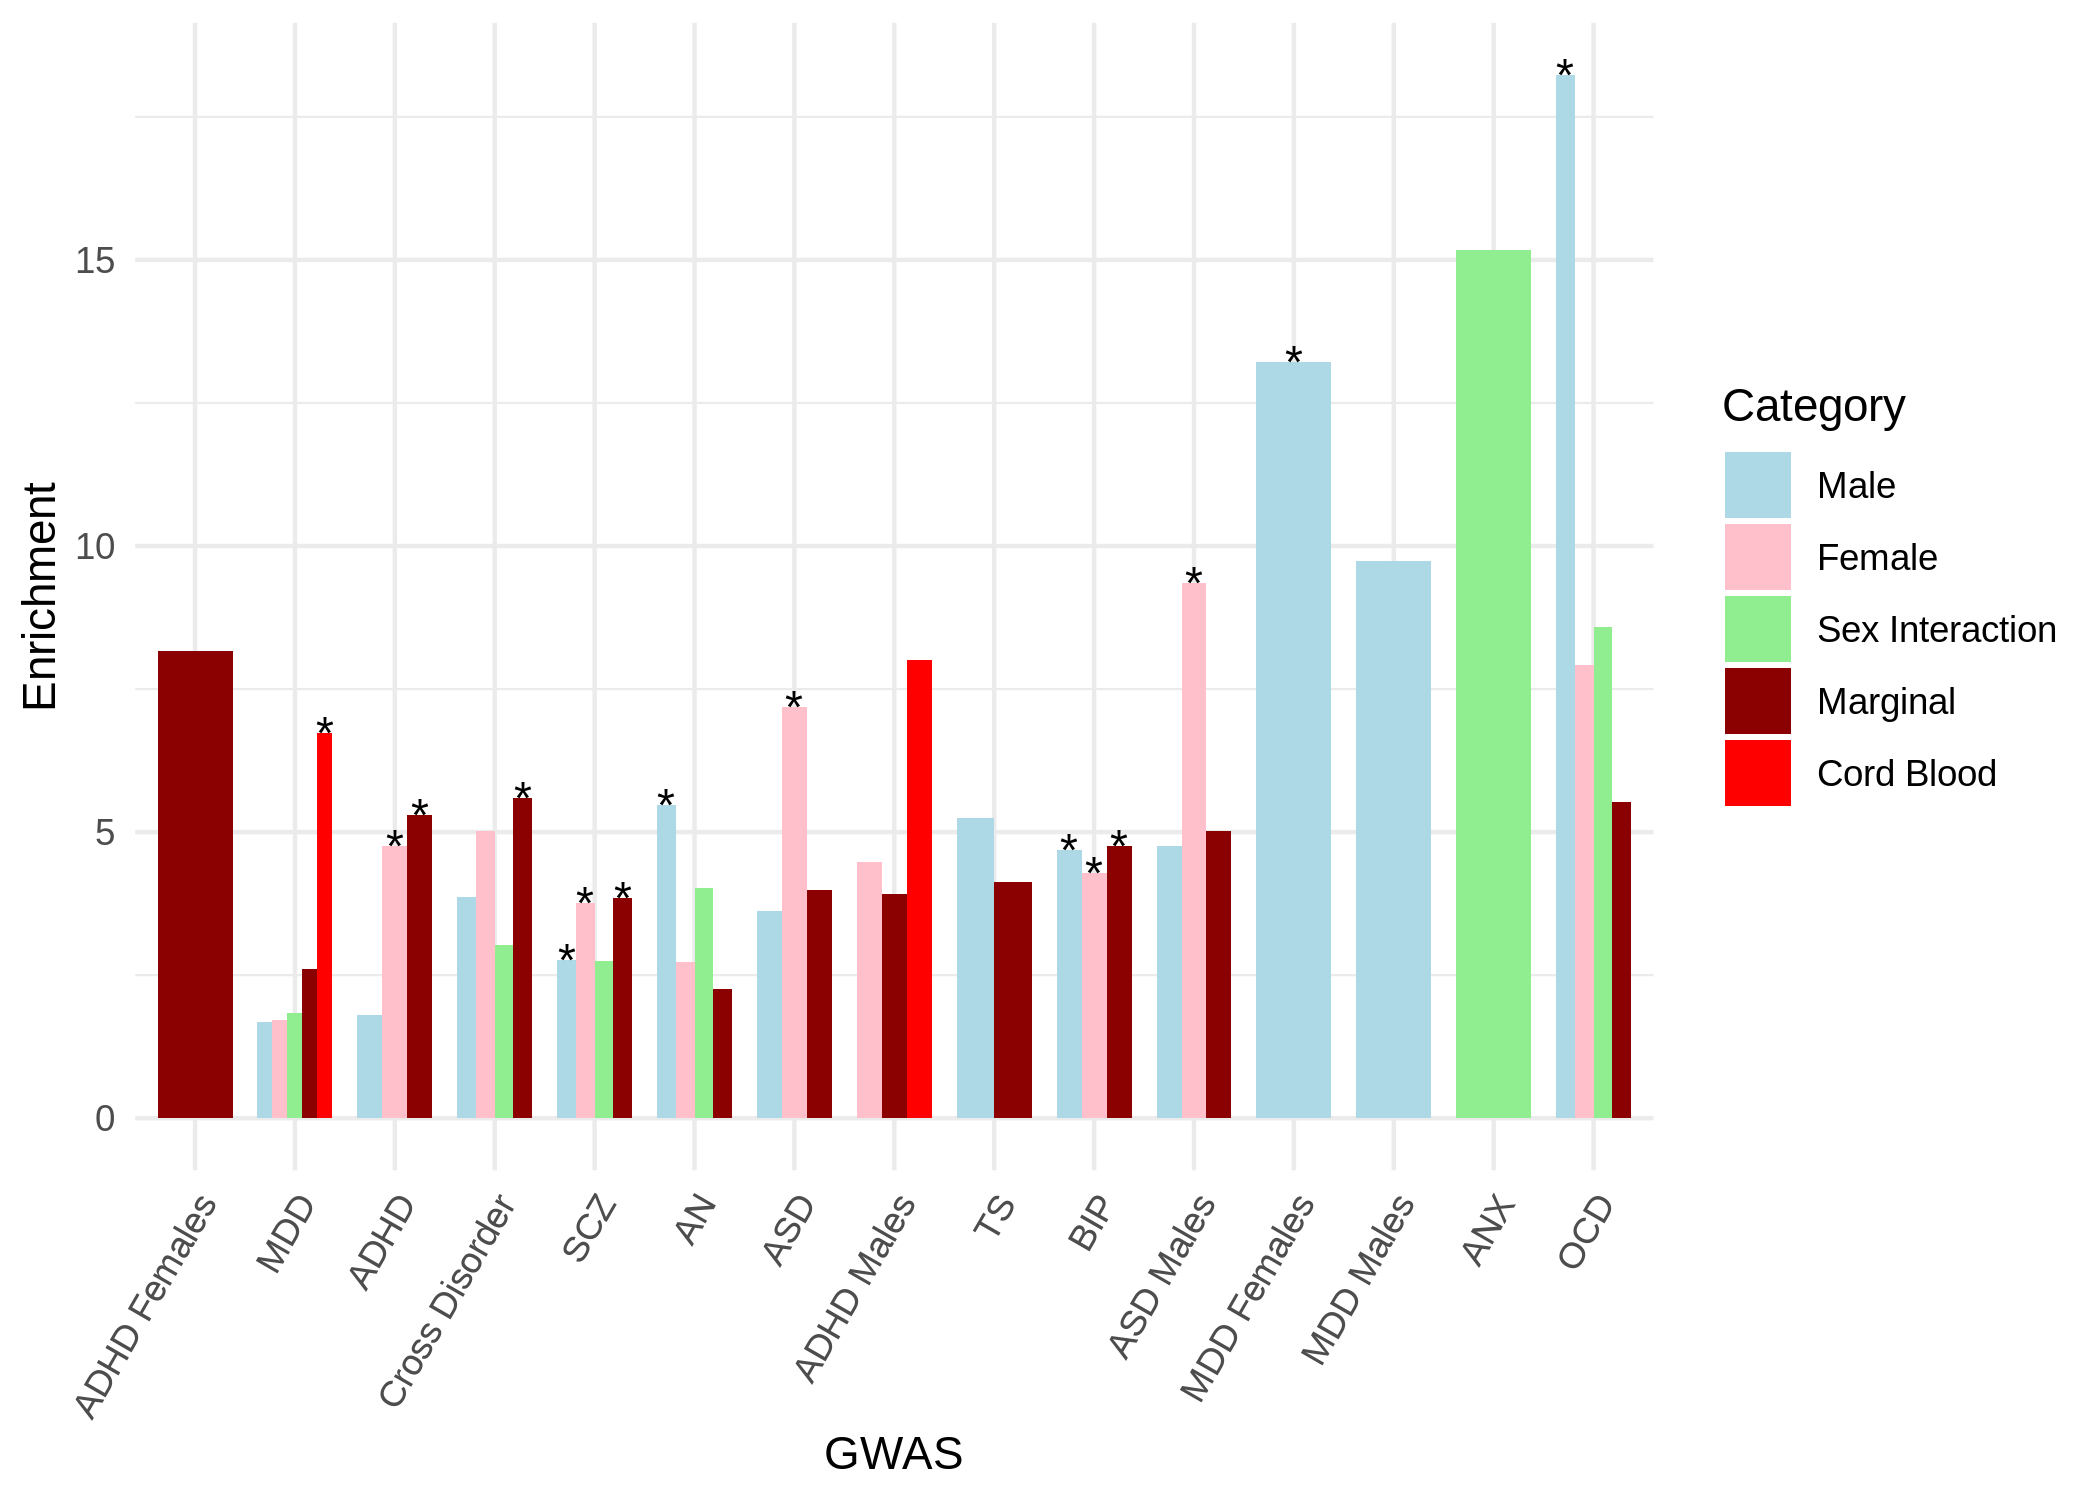

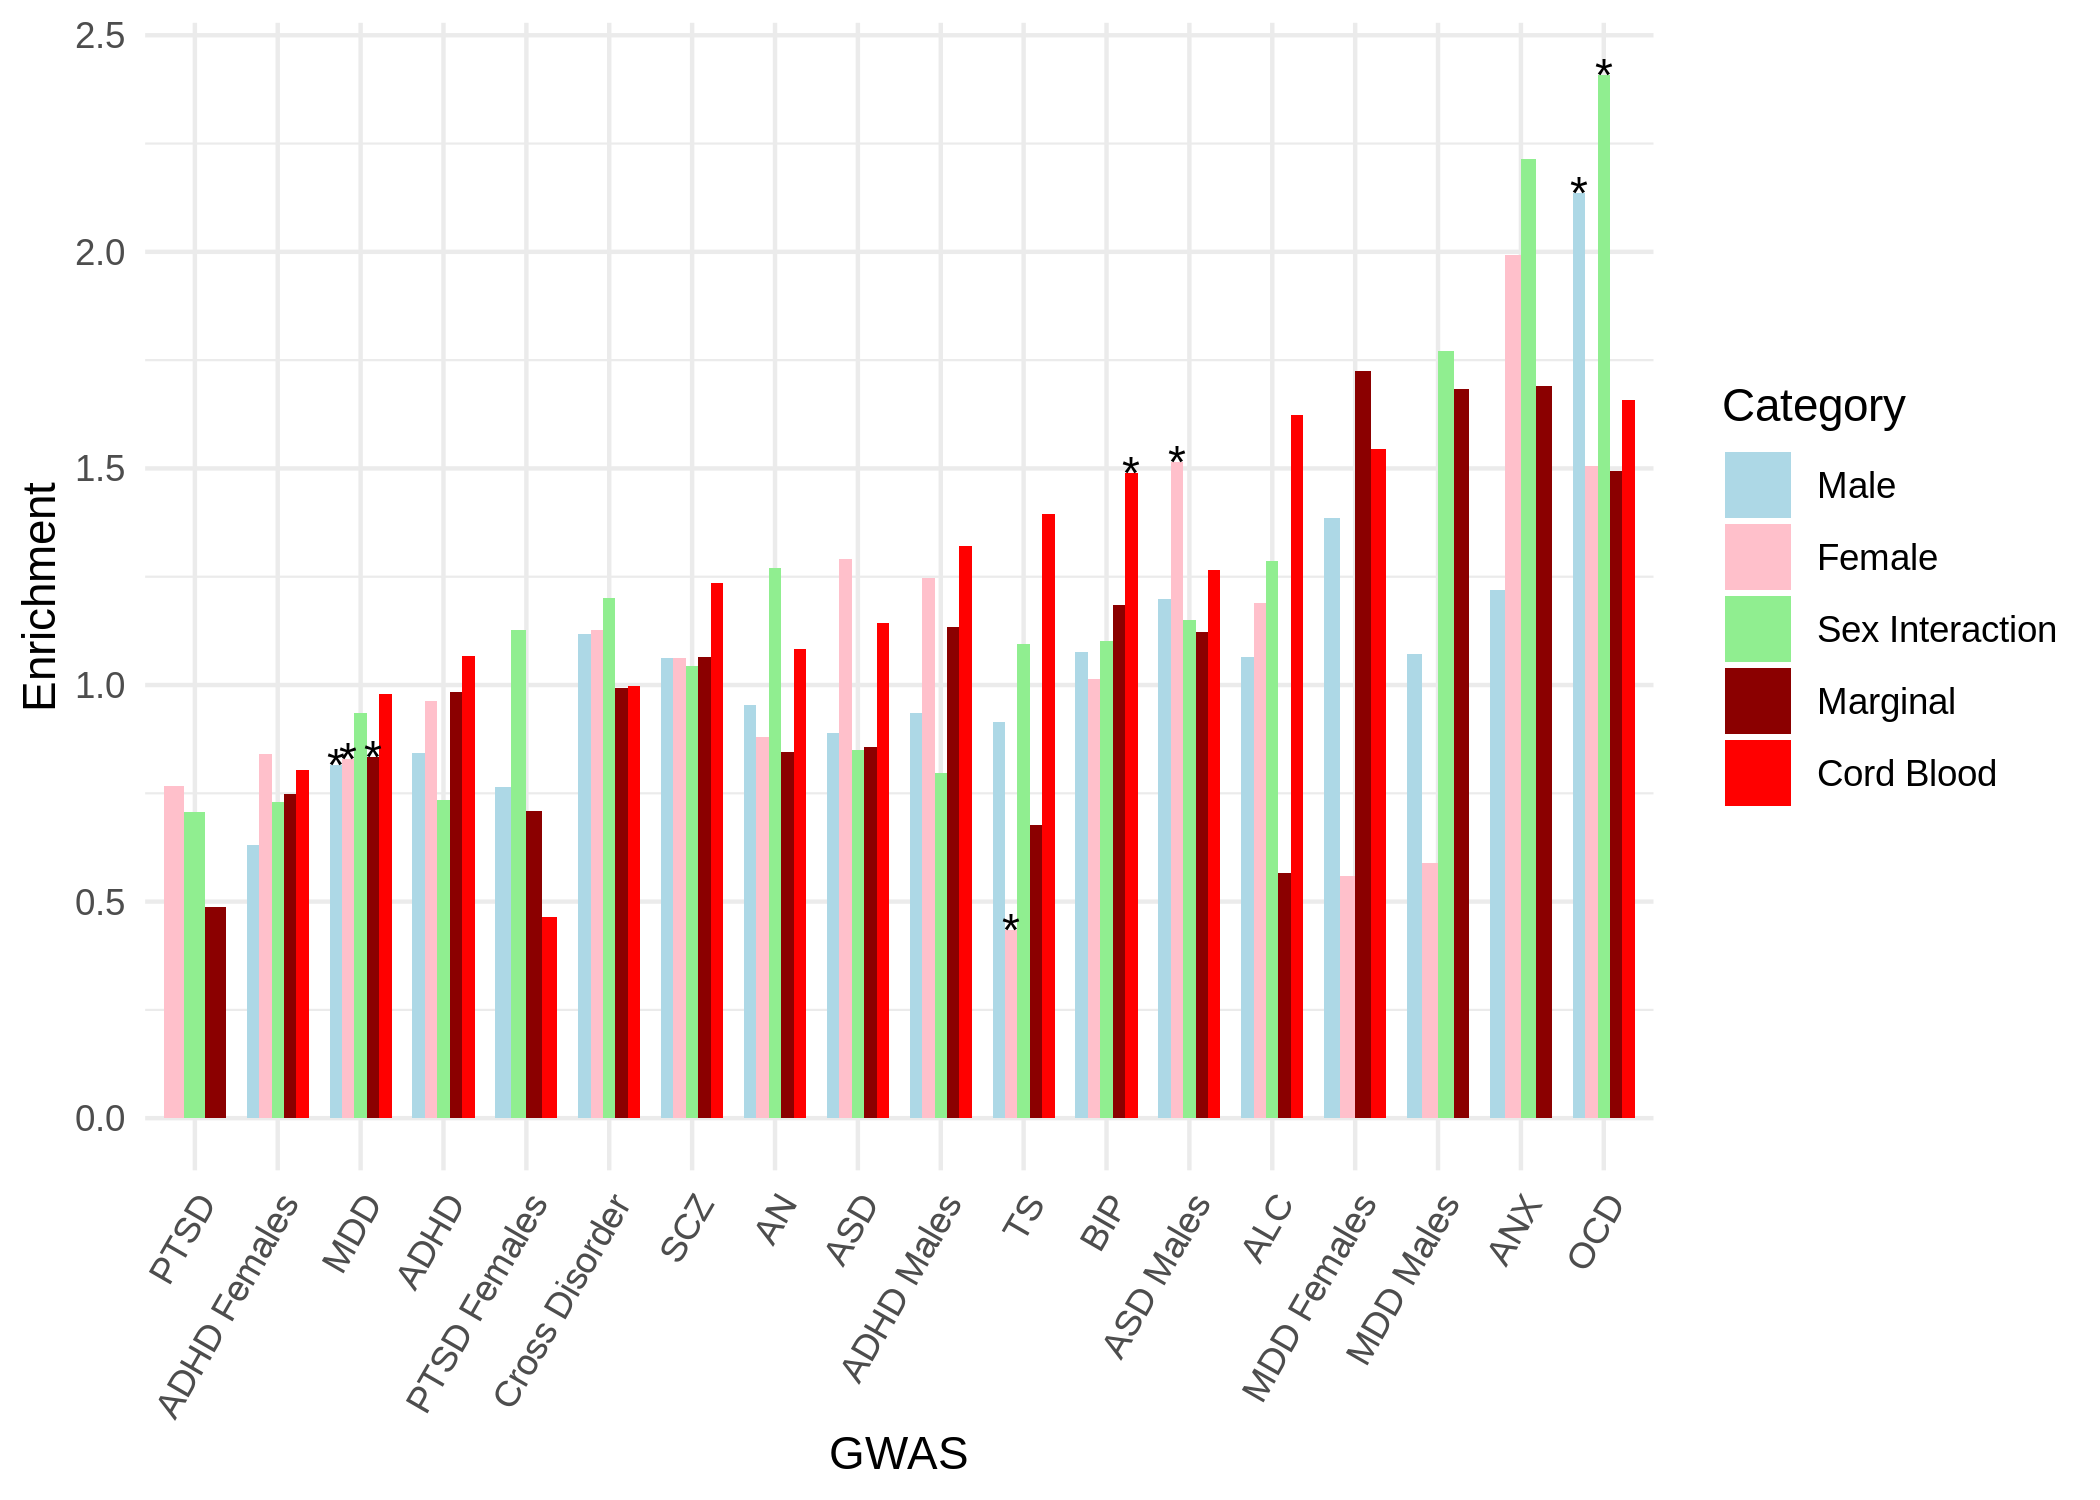

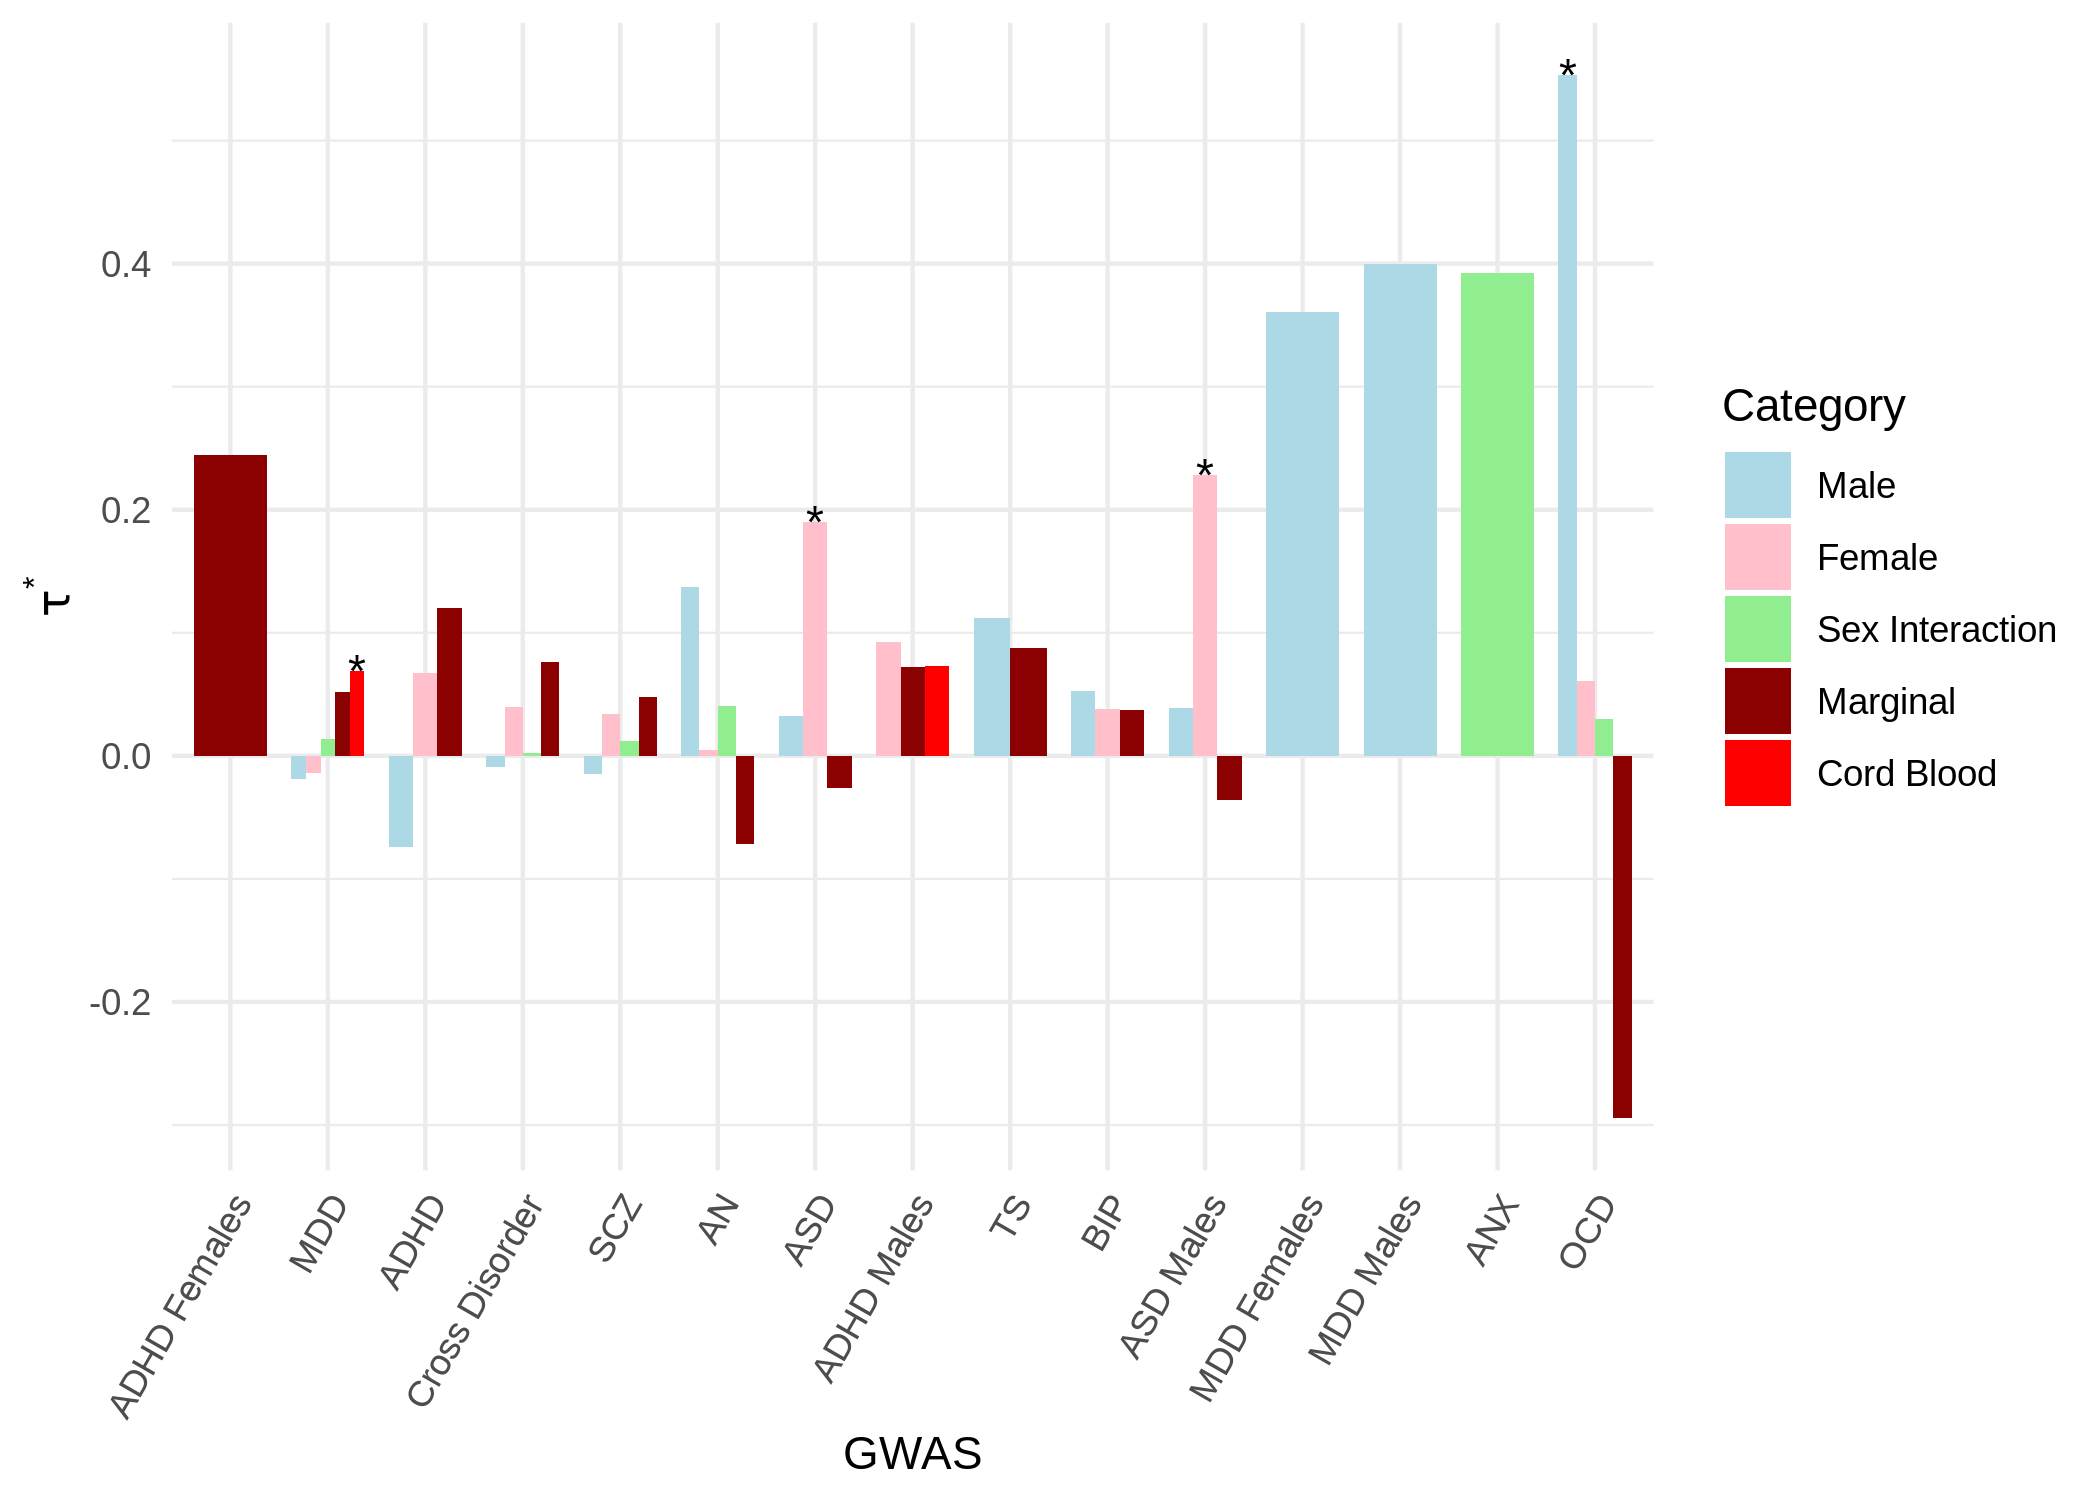

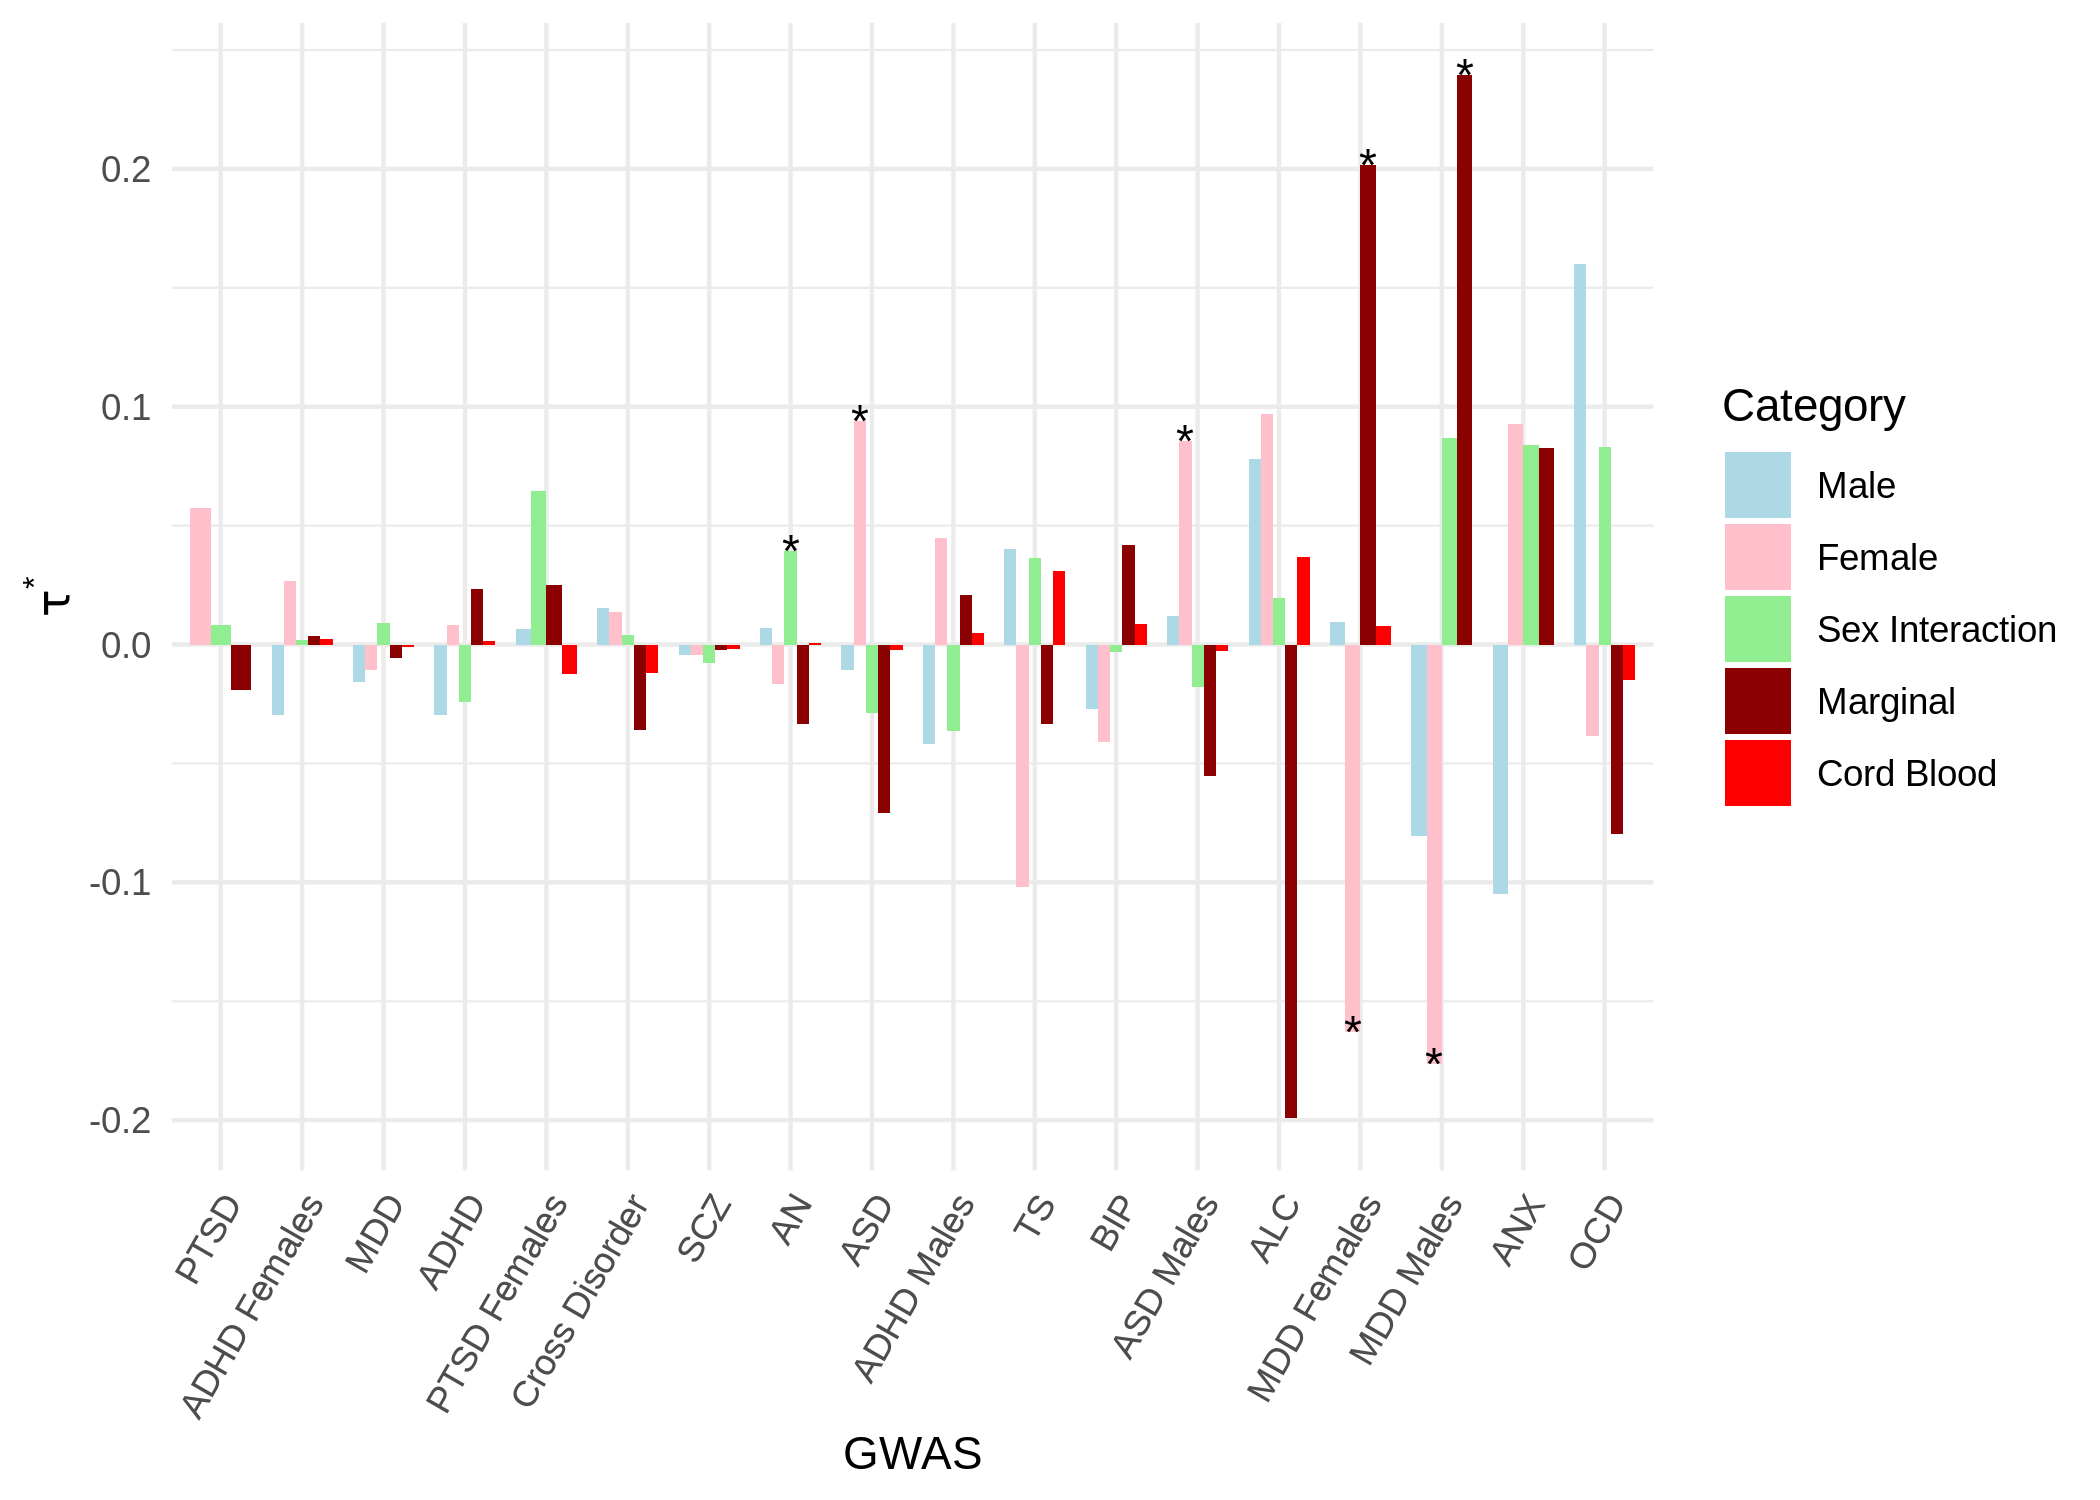

In [38]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
exclude_list <- c("PTSD Males","ASD Females","ANXFS","Alcohol (AUDIT)","Cannabis","Cigarettes Per Day") 
order_dt <-     pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
annot_order <- c("Male","Female","Sex Interaction","Marginal", "Cord Blood")
ggplot(
    pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "maxCPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "maxCPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    labs(y=bquote(tau^"*"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_df[
        !GWAS %in% exclude_list &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female", "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

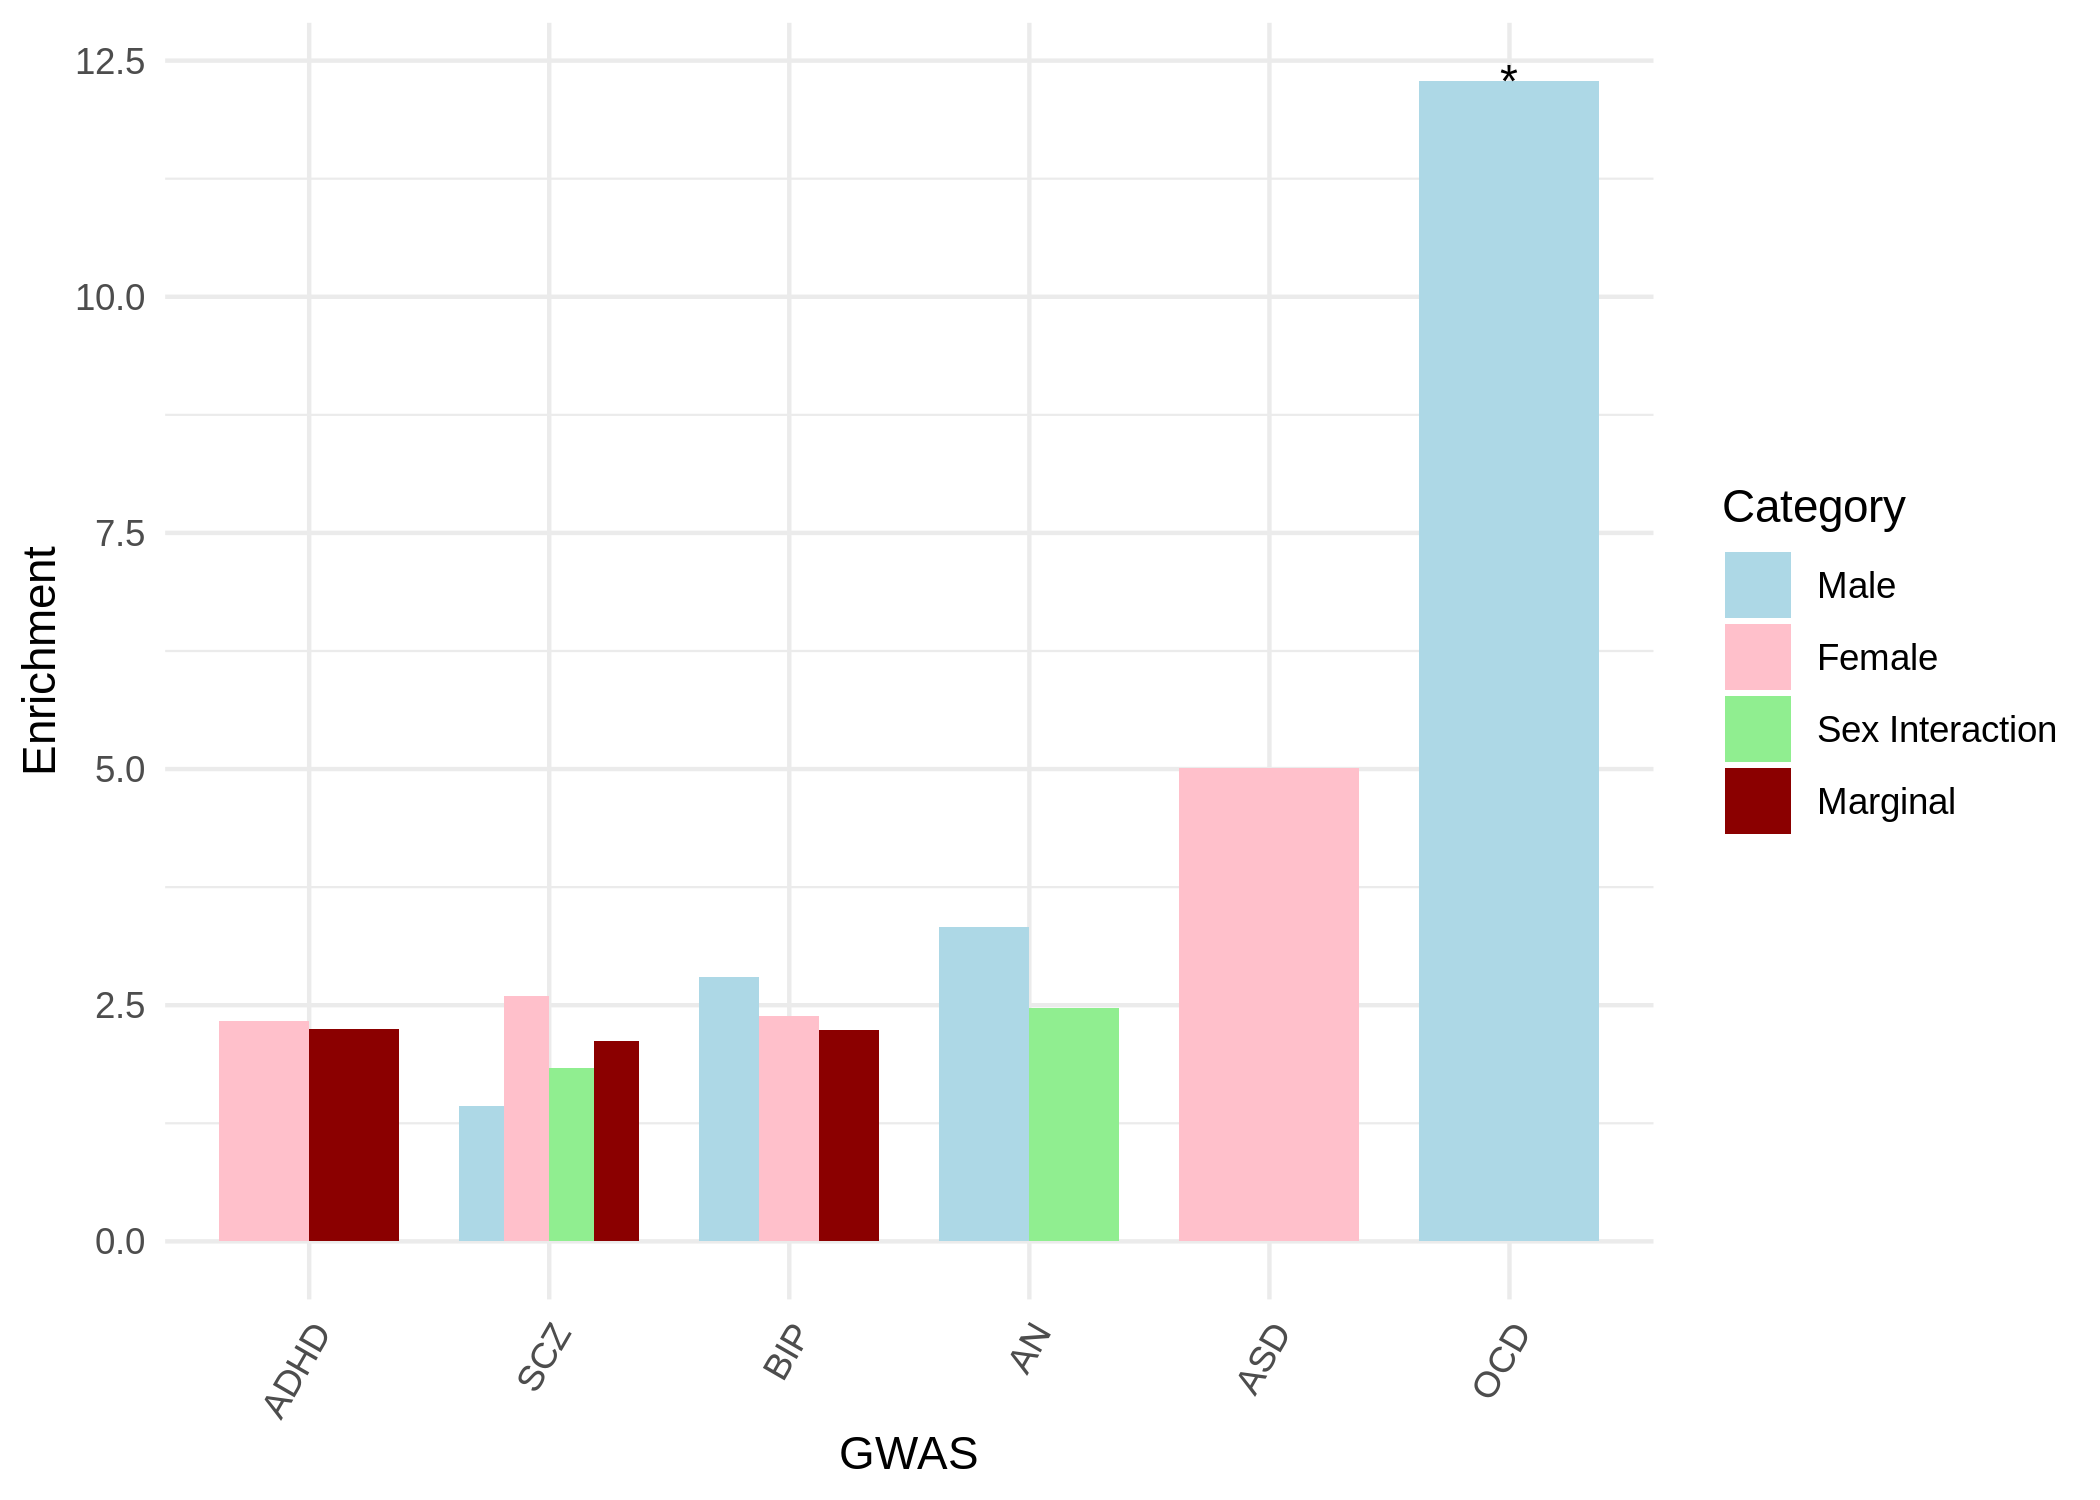

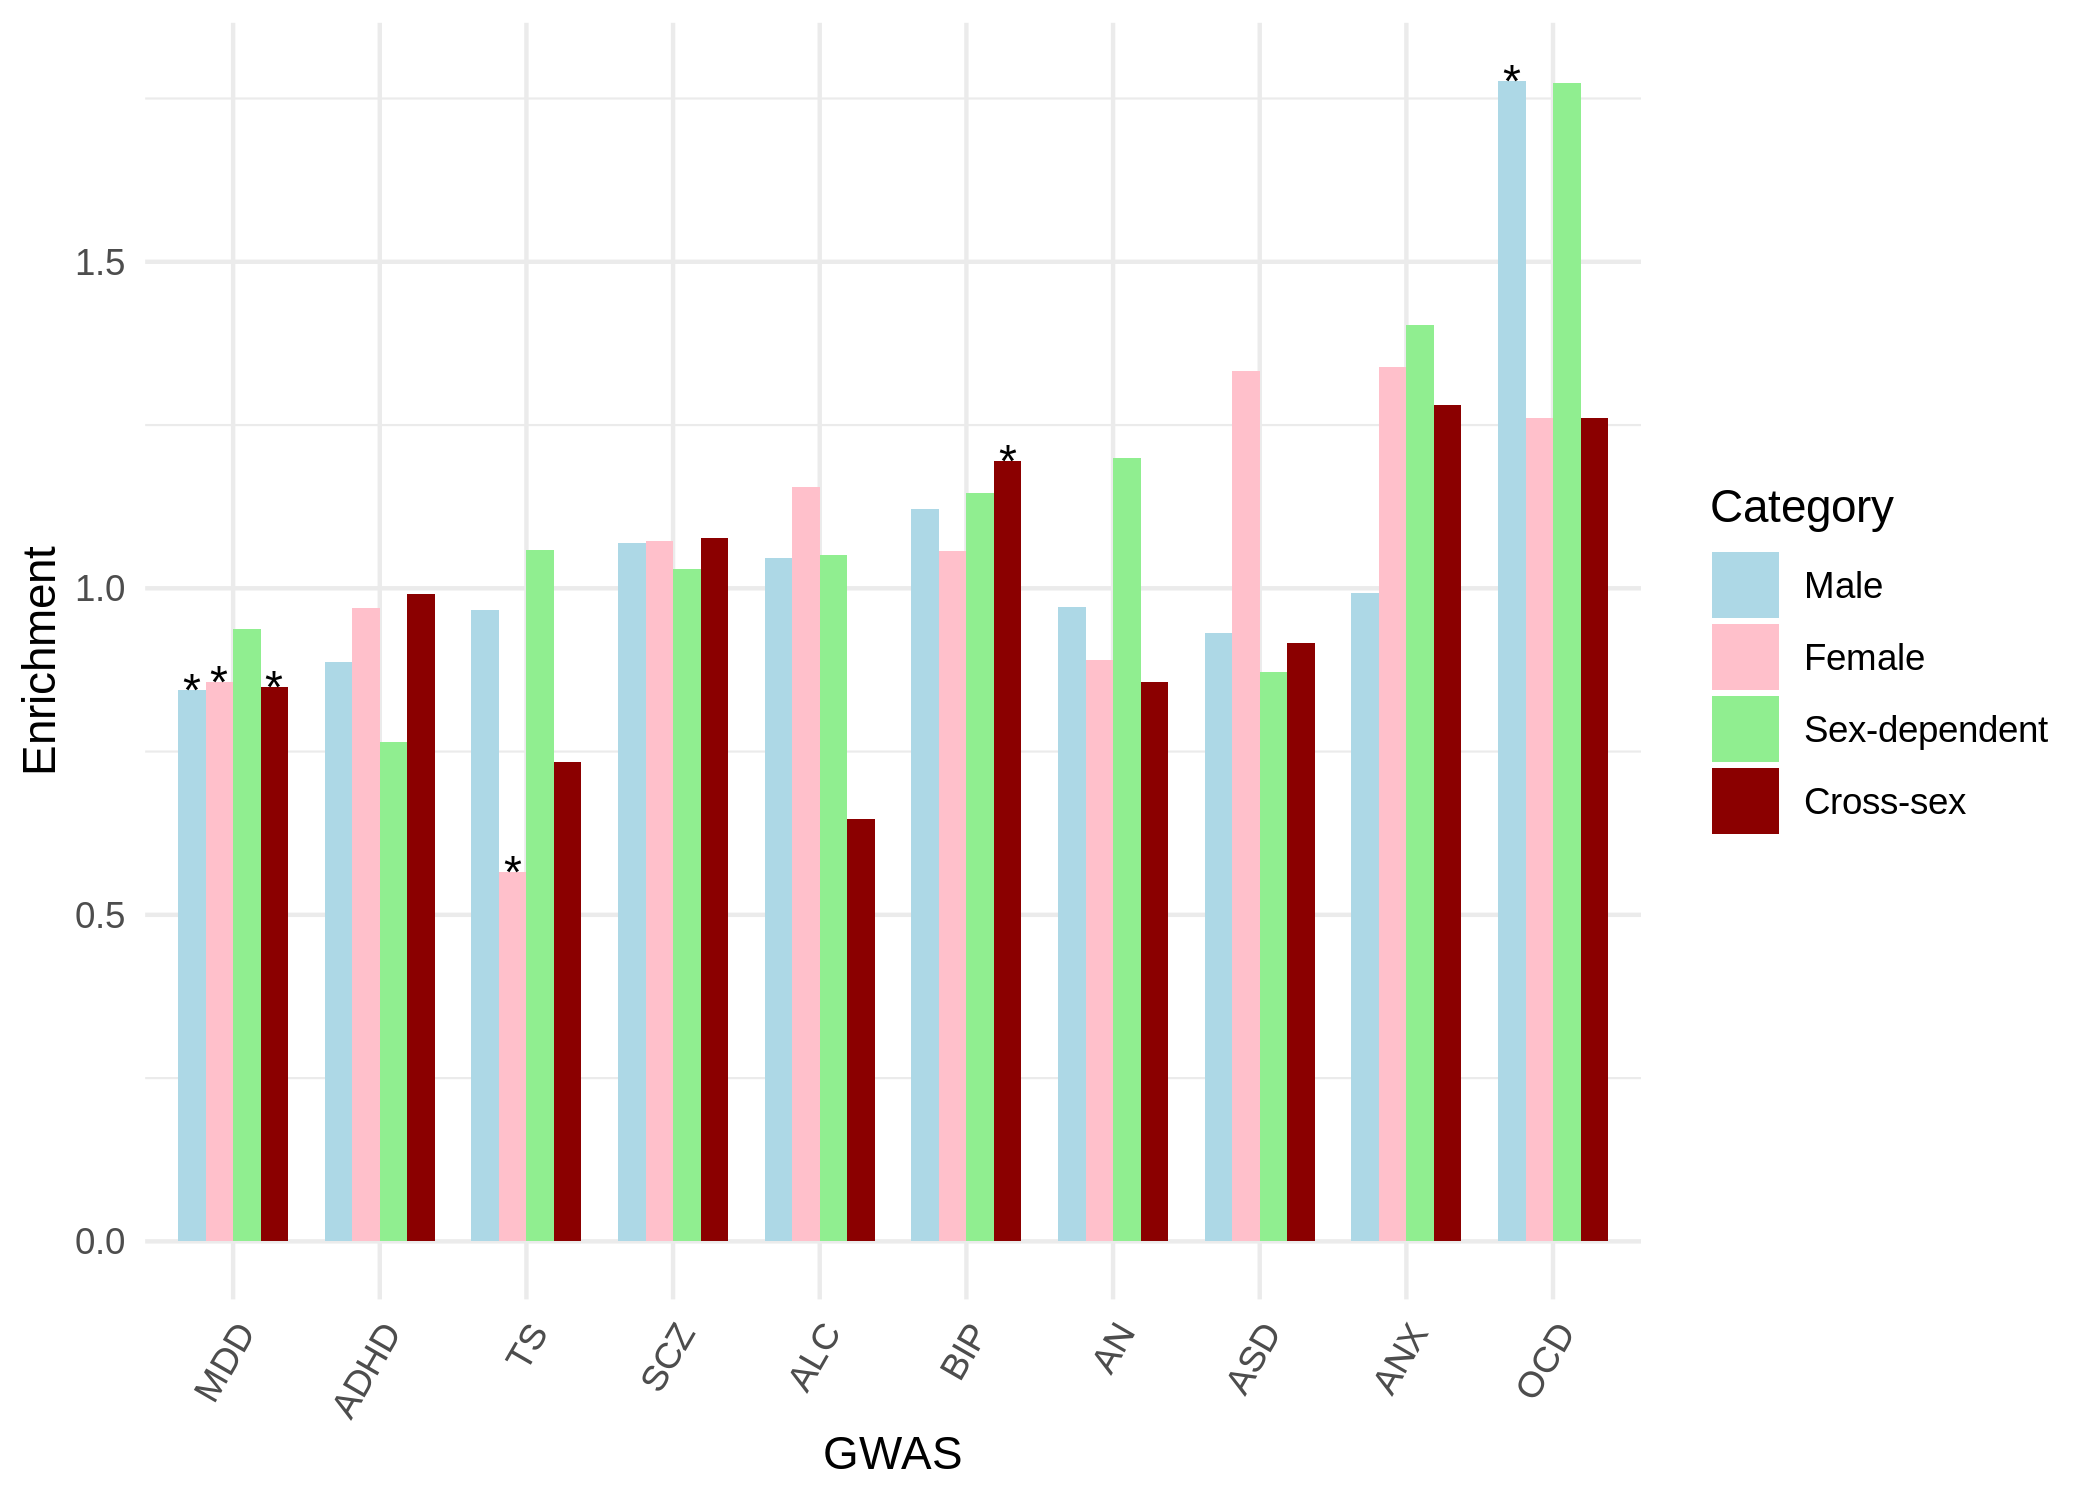

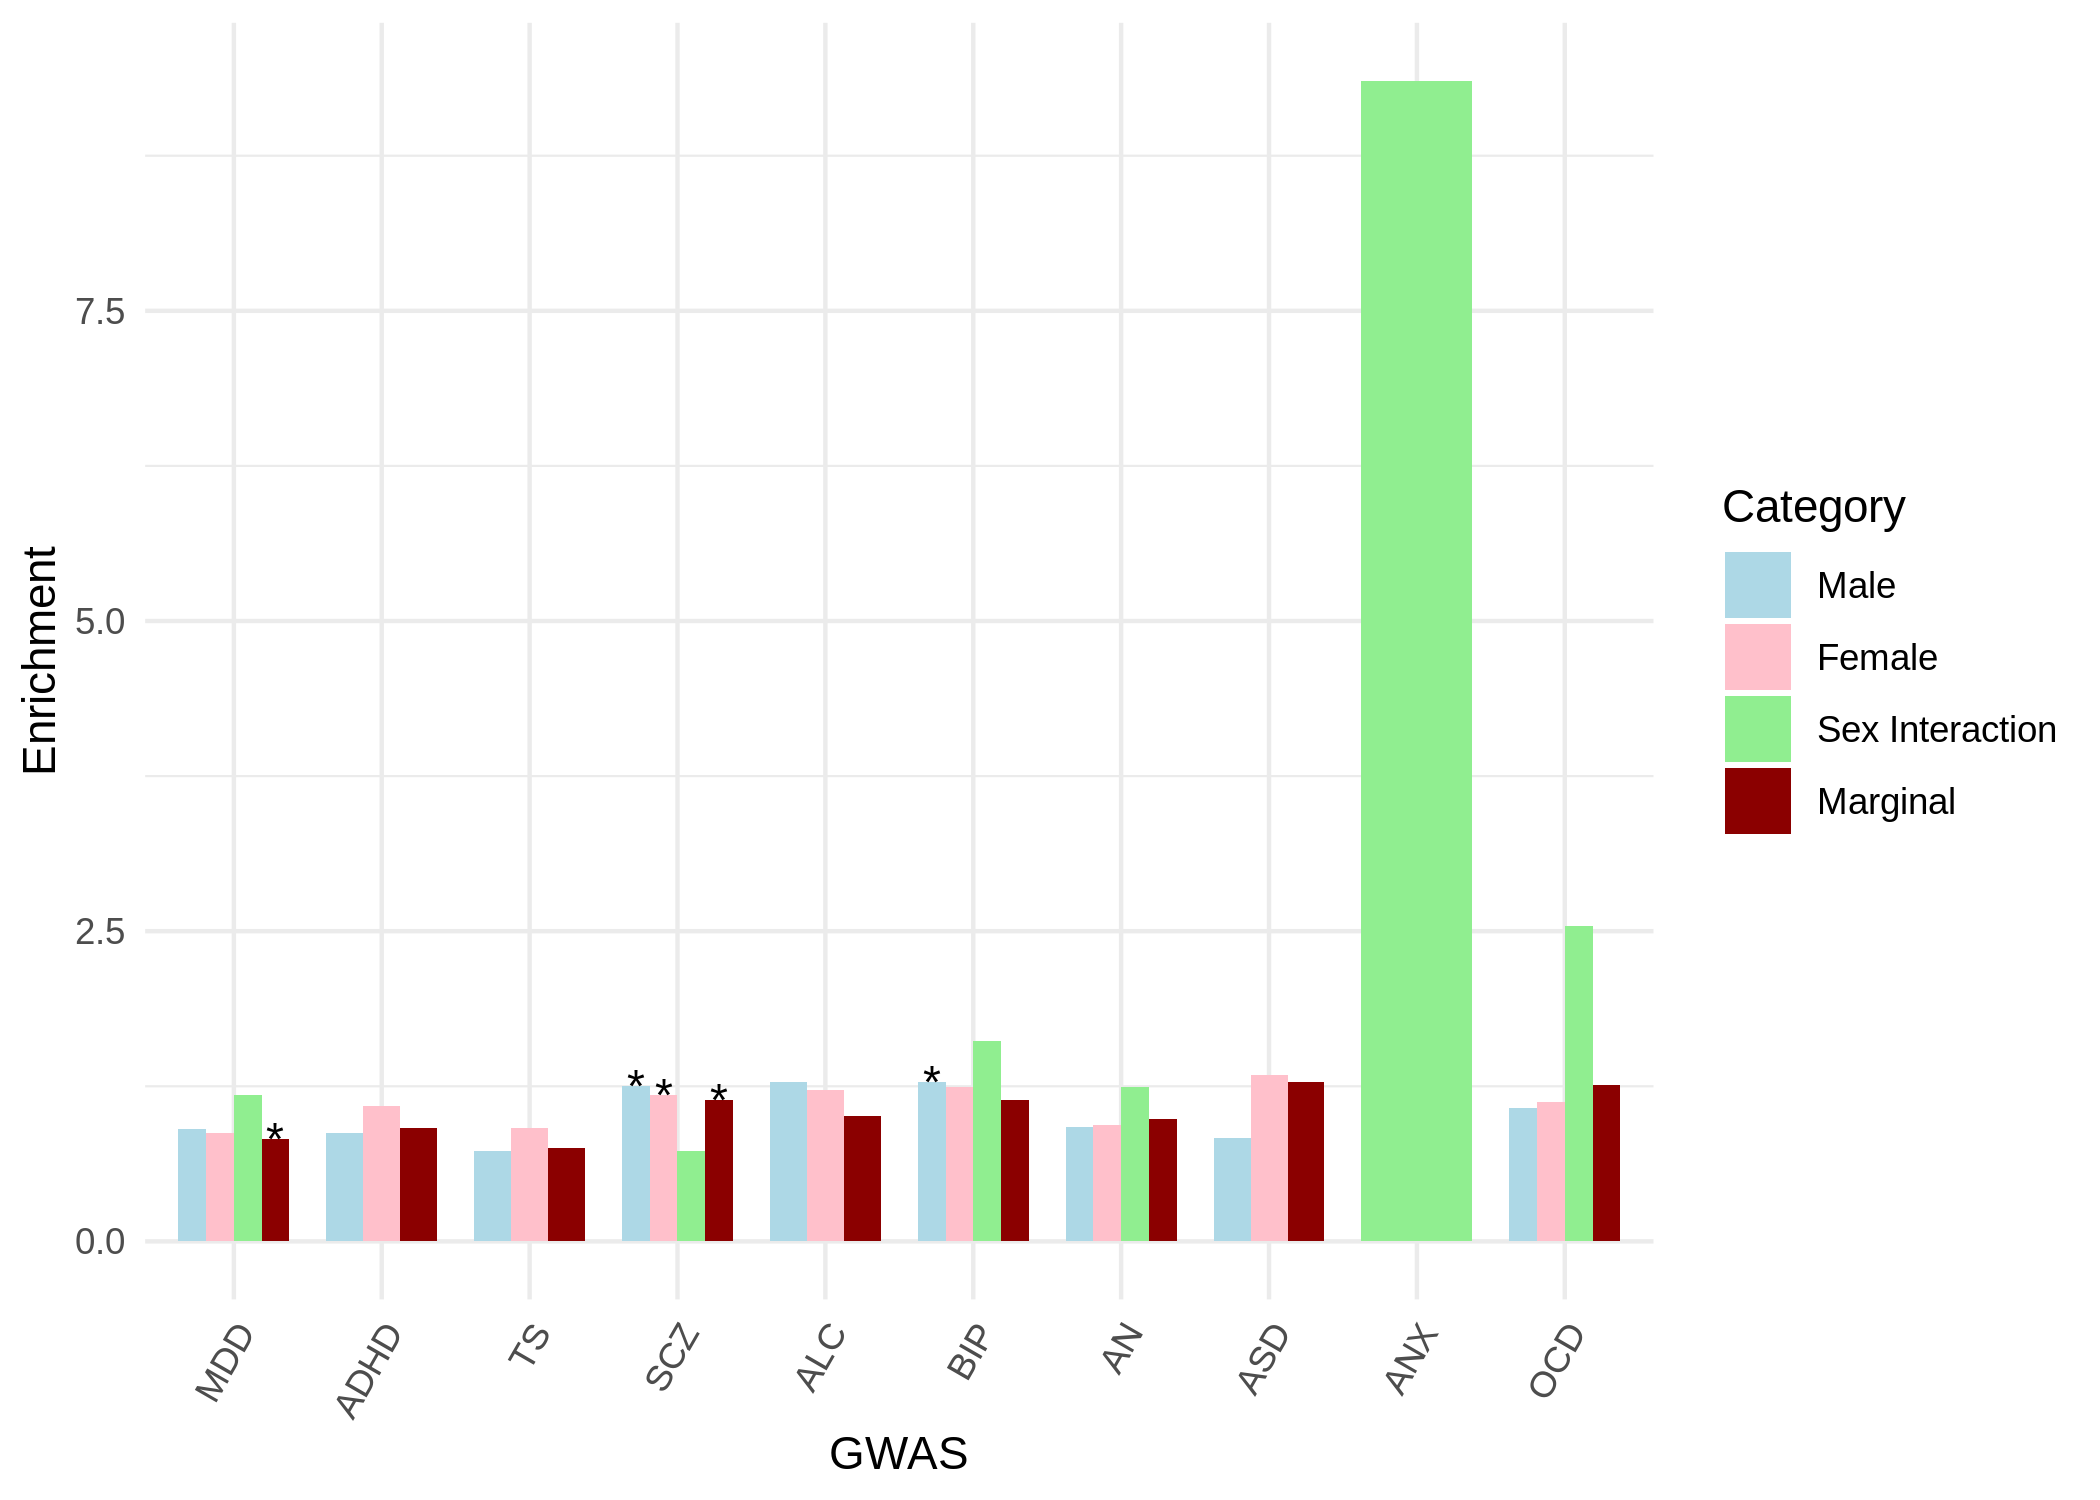

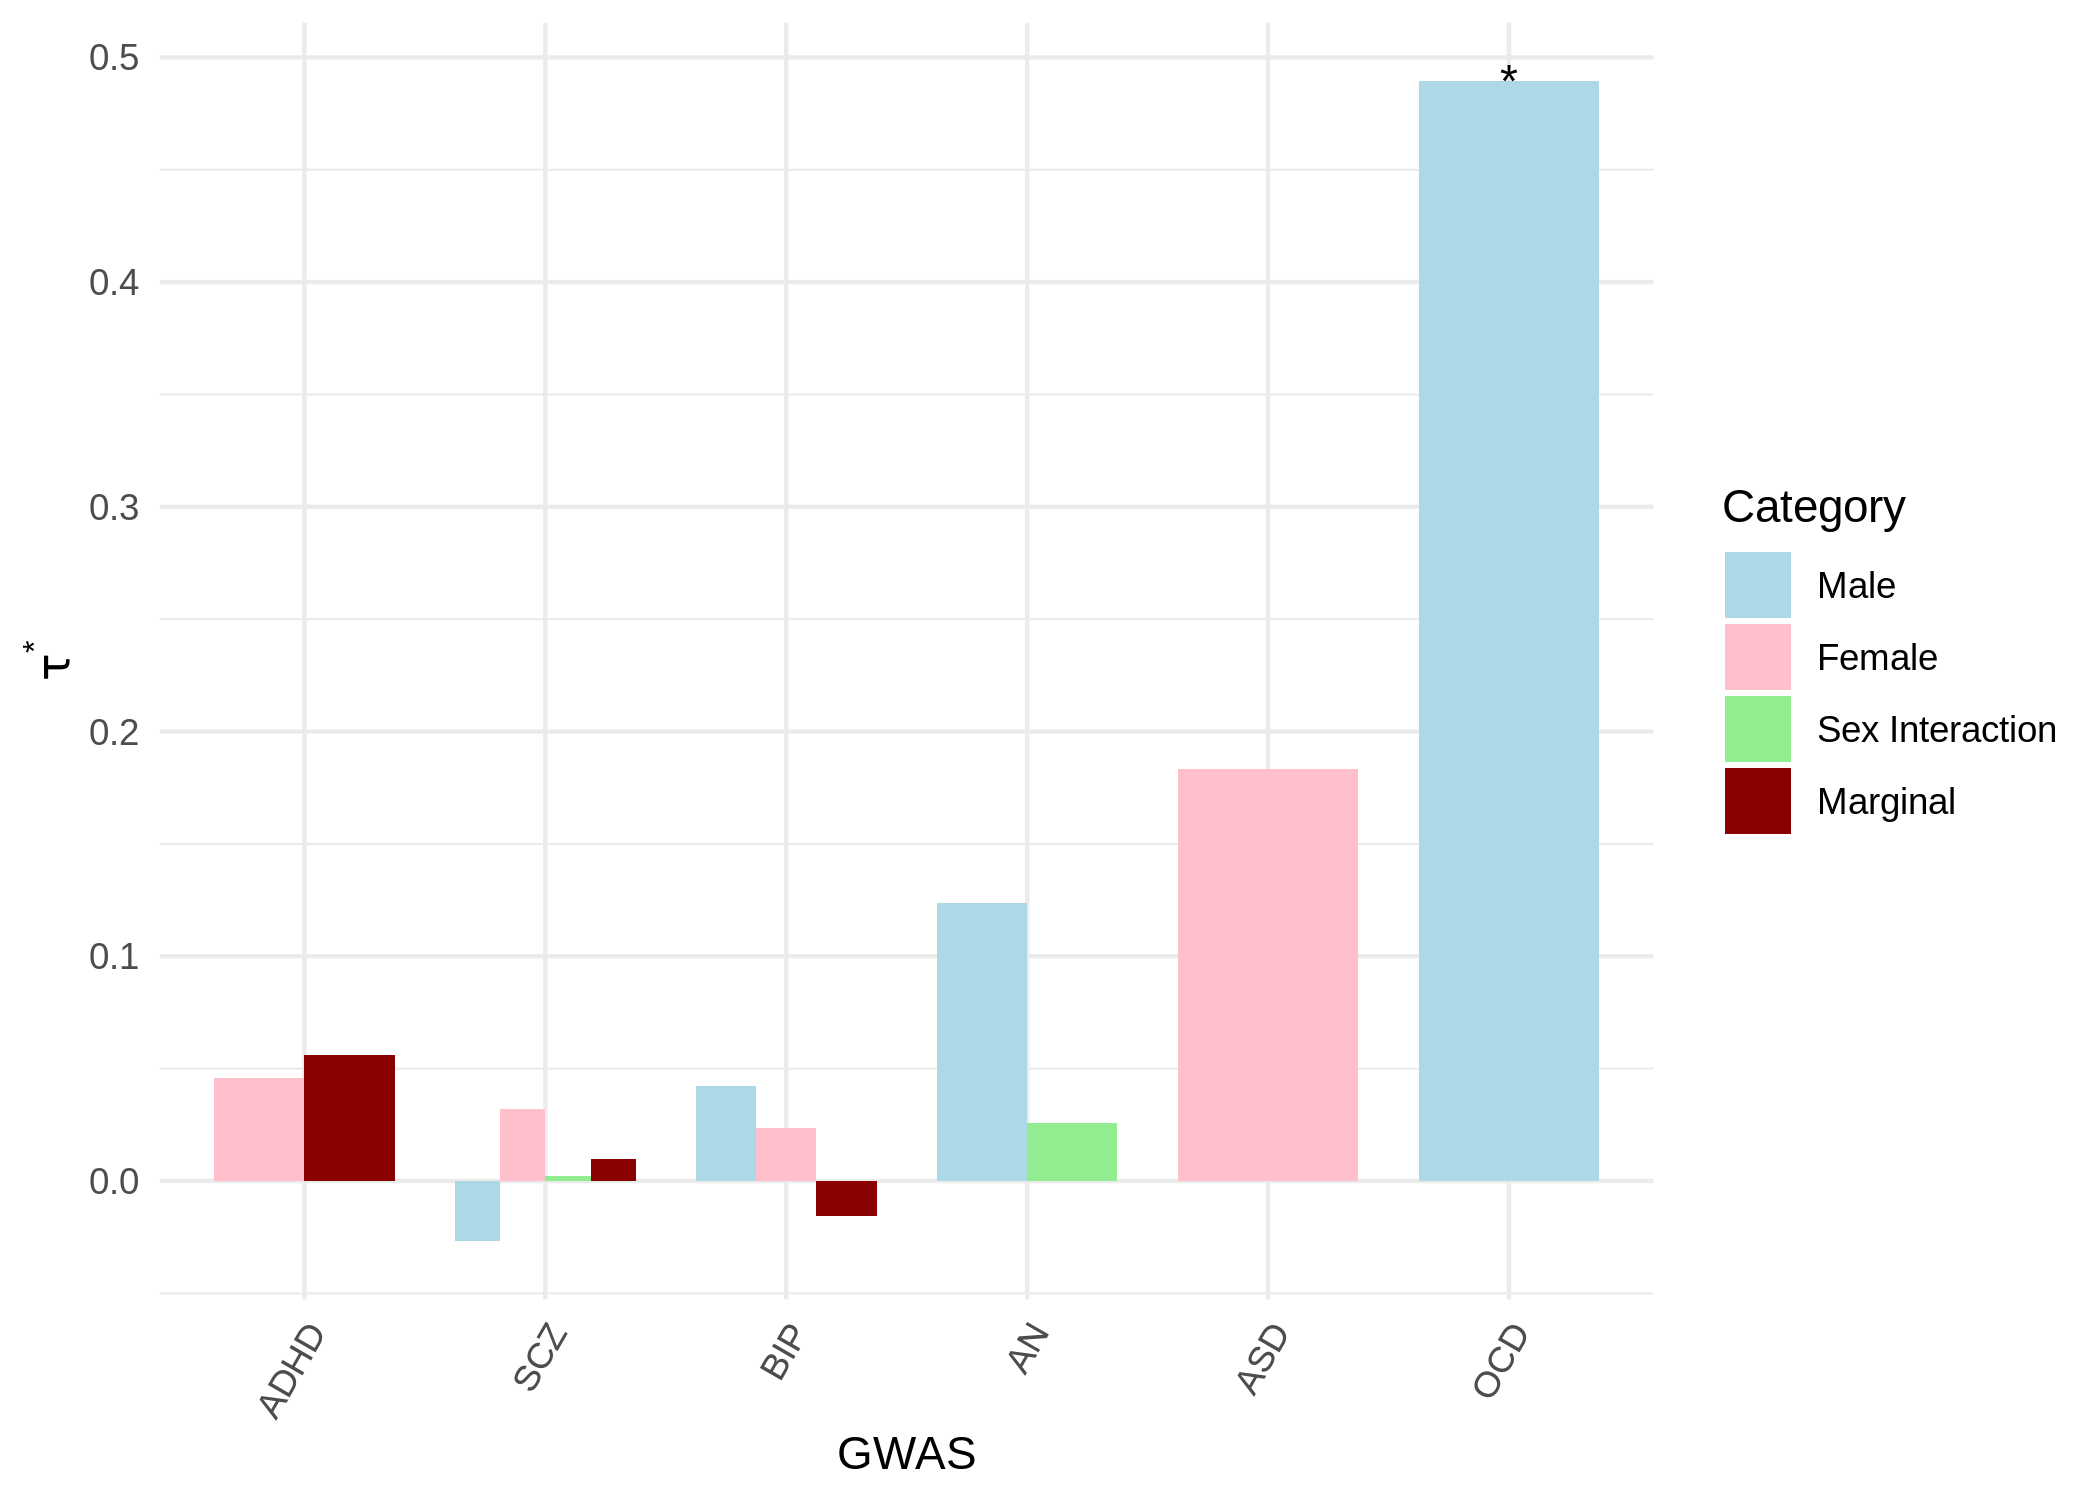

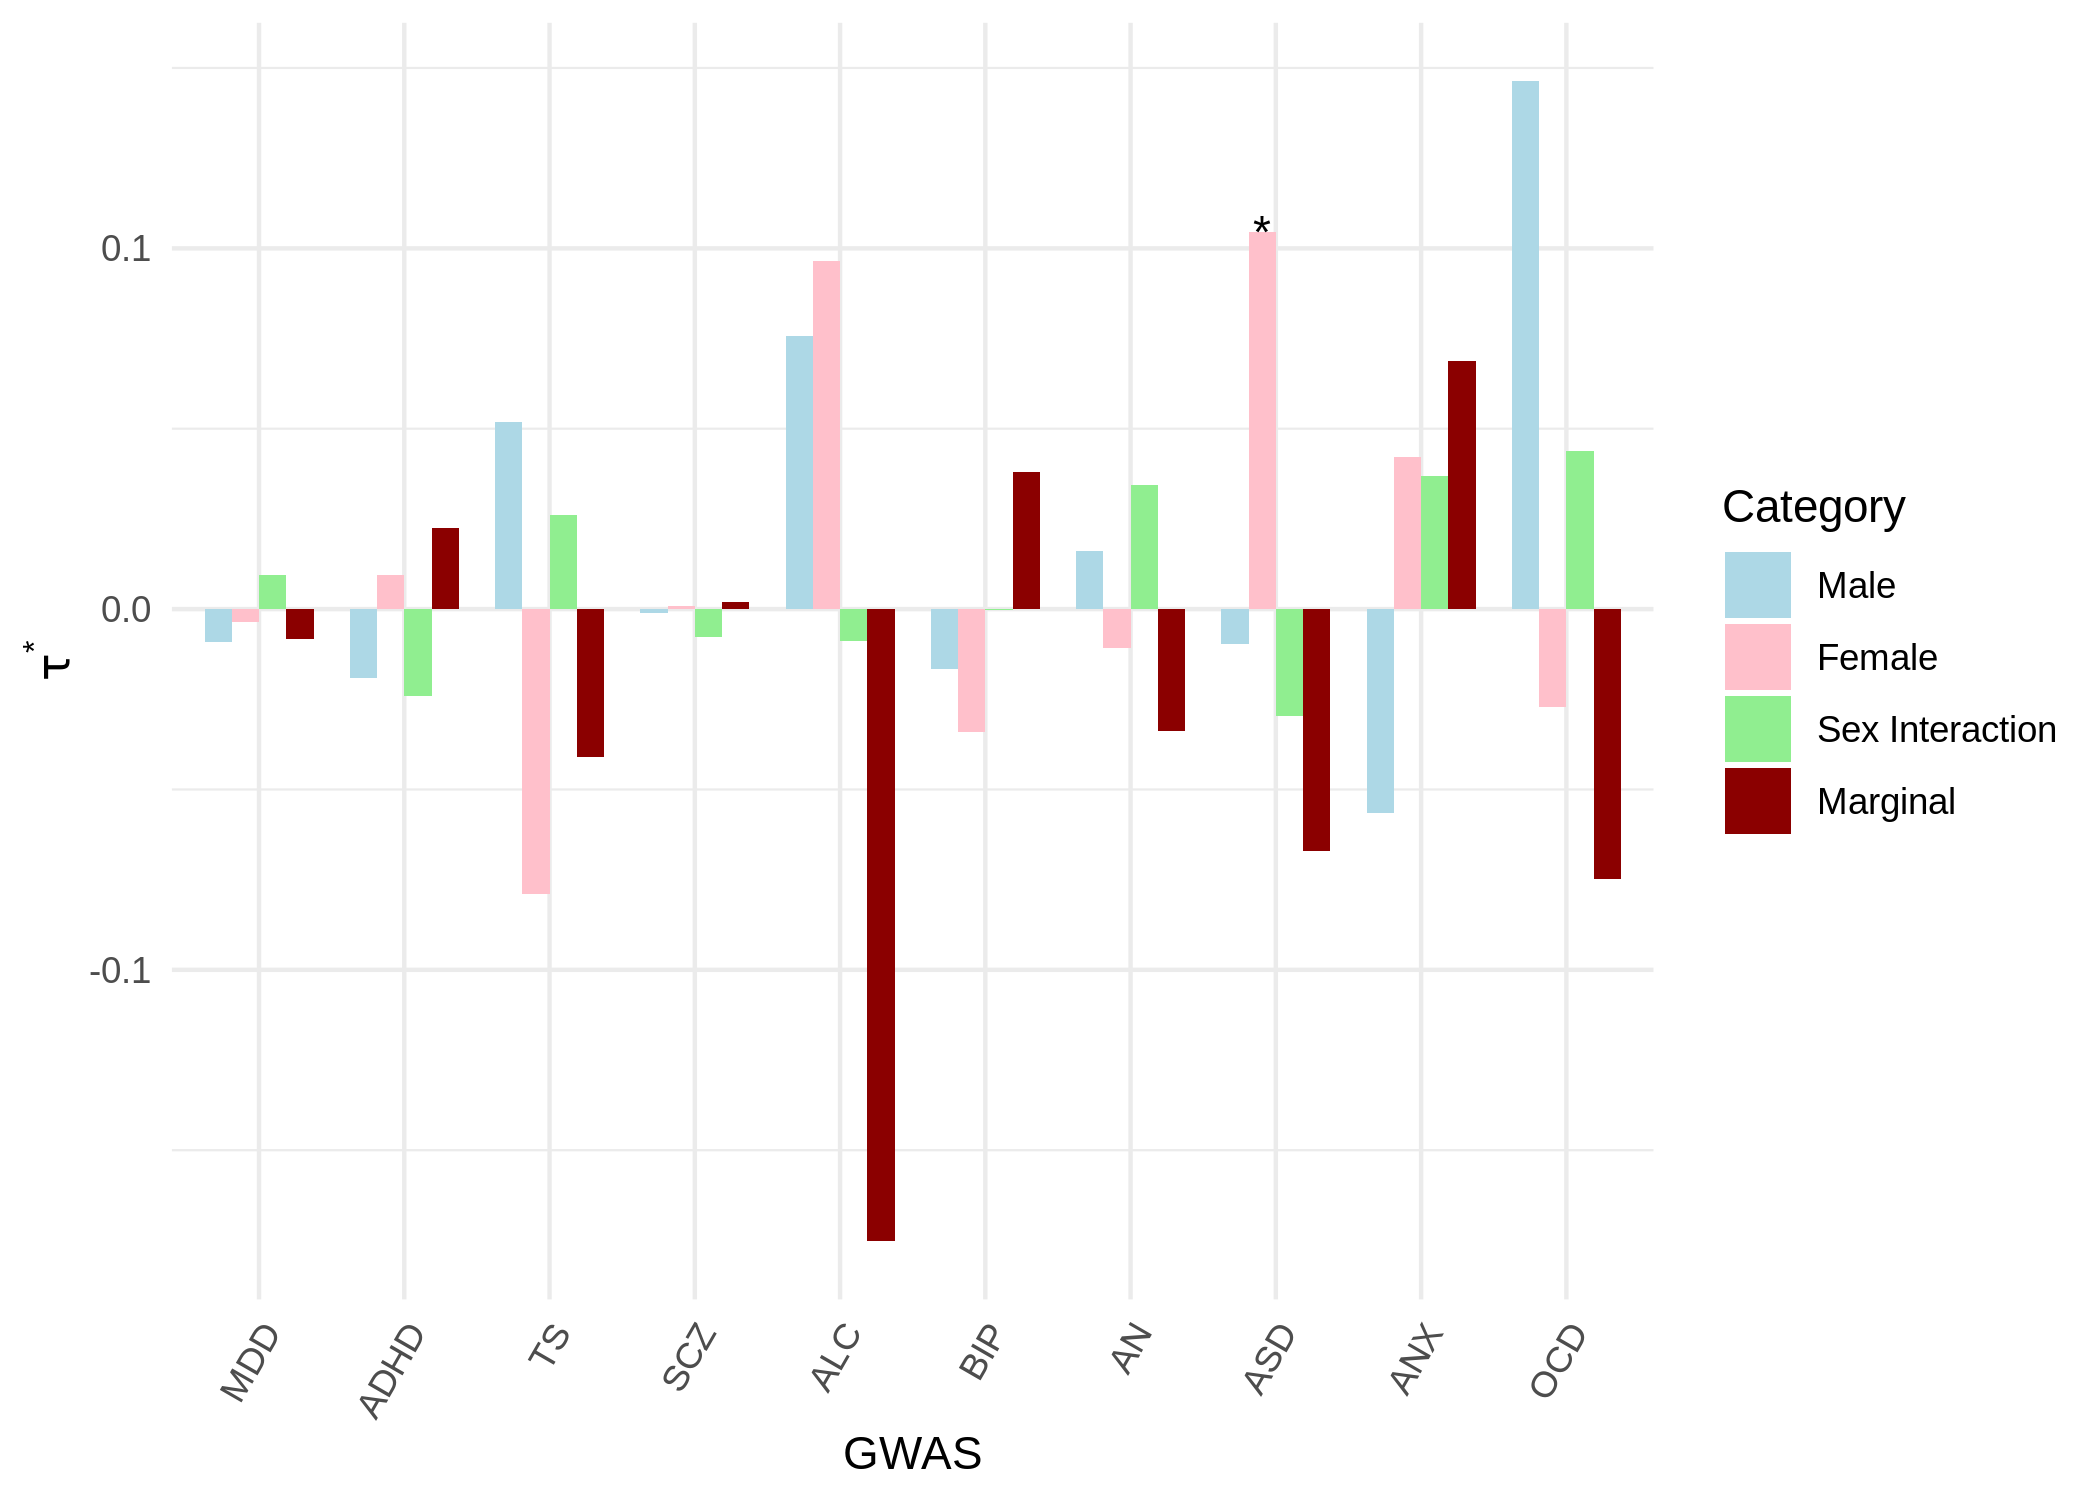

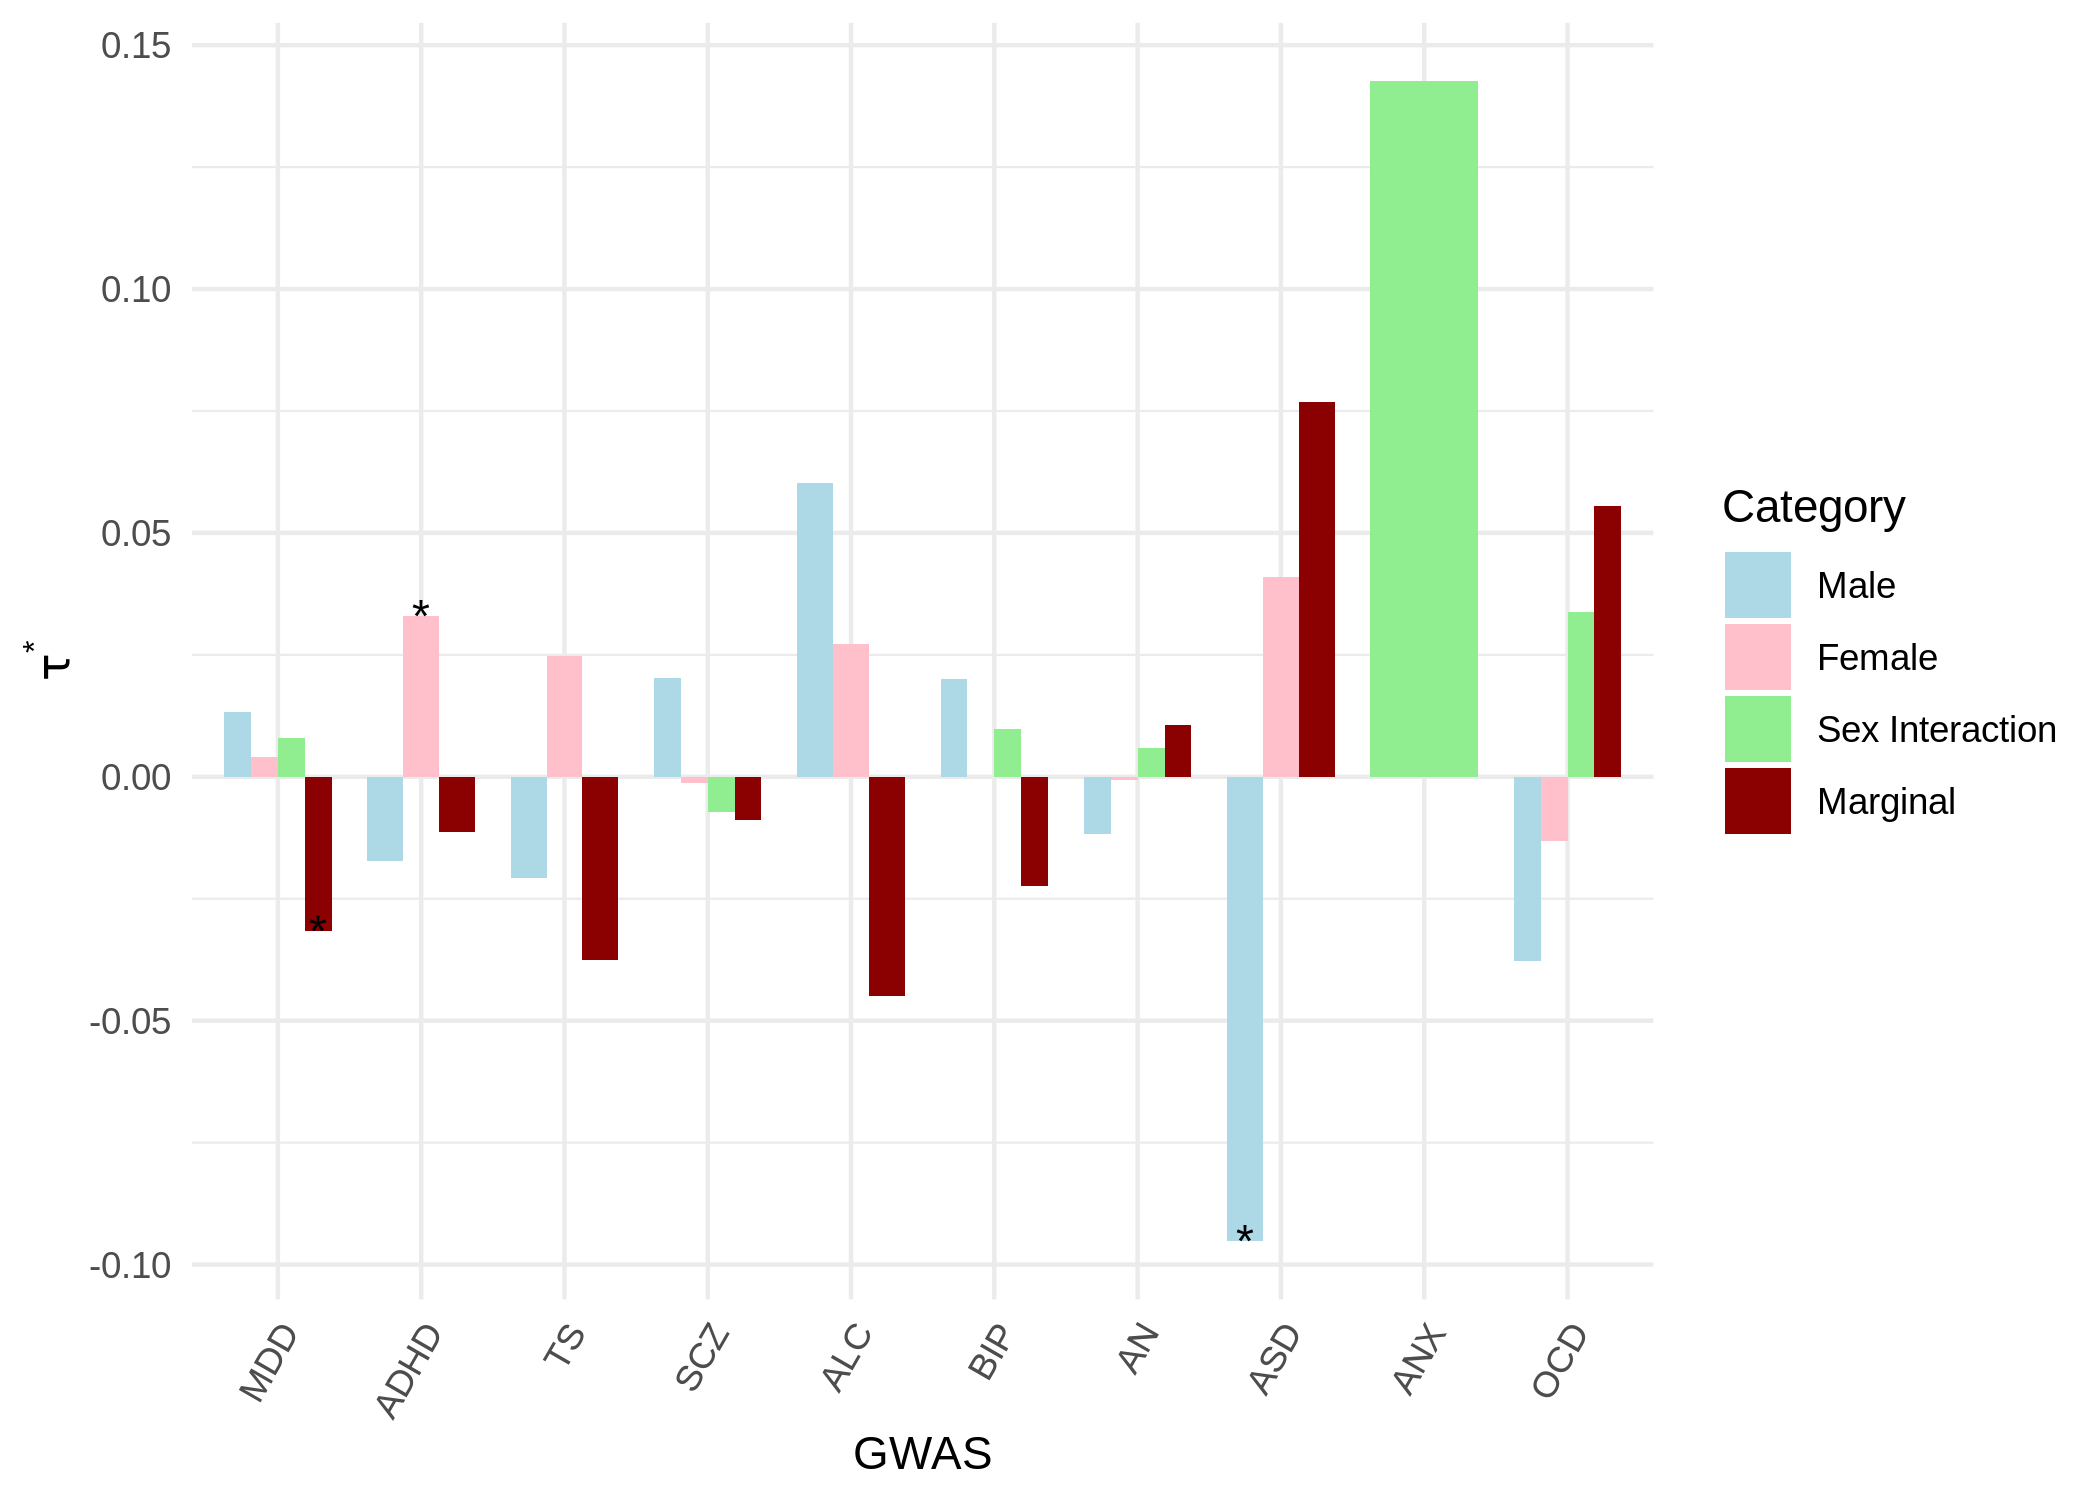

In [39]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
exclude_list <- c("PTSD Males","ASD Females","ANXFS","Alcohol (AUDIT)","Cannabis","Cigarettes Per Day", "Cross Disorder") 
order_dt <-     pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
annot_order <- c("Male","Female","Sex Interaction","Marginal") #, "Cord Blood")
ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "maxCPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = recode_factor(Category,"Male"="Male","Female"="Female","Sex Interaction"="Sex-dependent","Marginal"="Cross-sex")),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "all_cis_fdr" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "maxCPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    labs(y=bquote(tau^"*"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_baseline_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% c("Marginal", "Sex Interaction", "Male", "Female")& #, "Cord Blood") &
        annotation == "all_cis_fdr" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

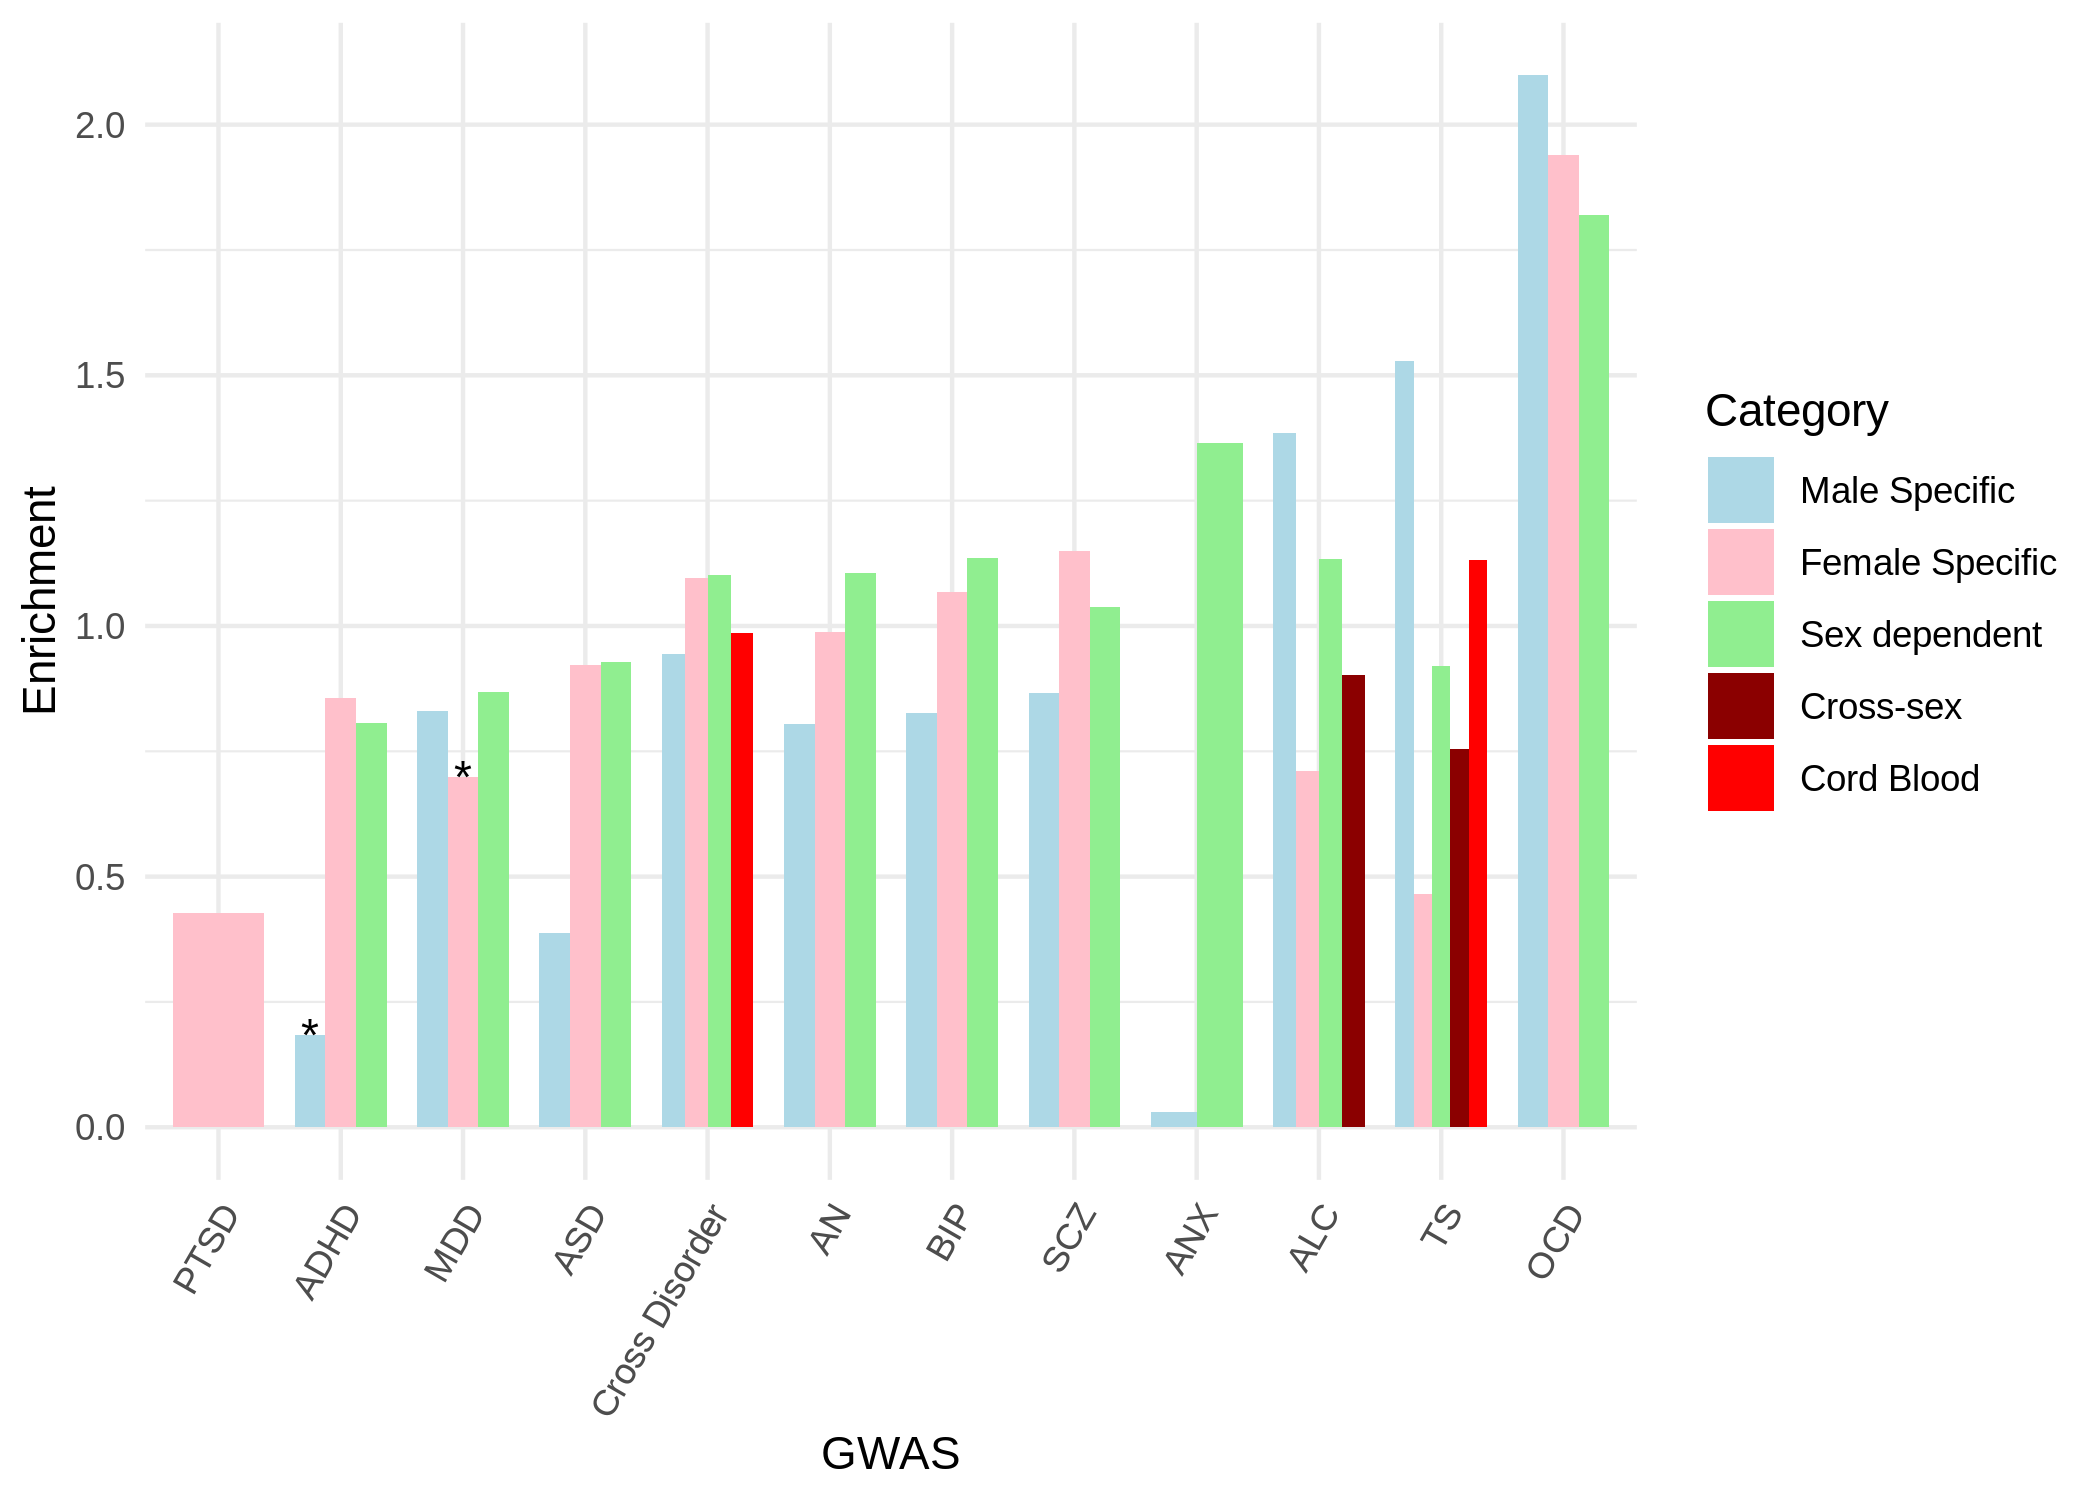

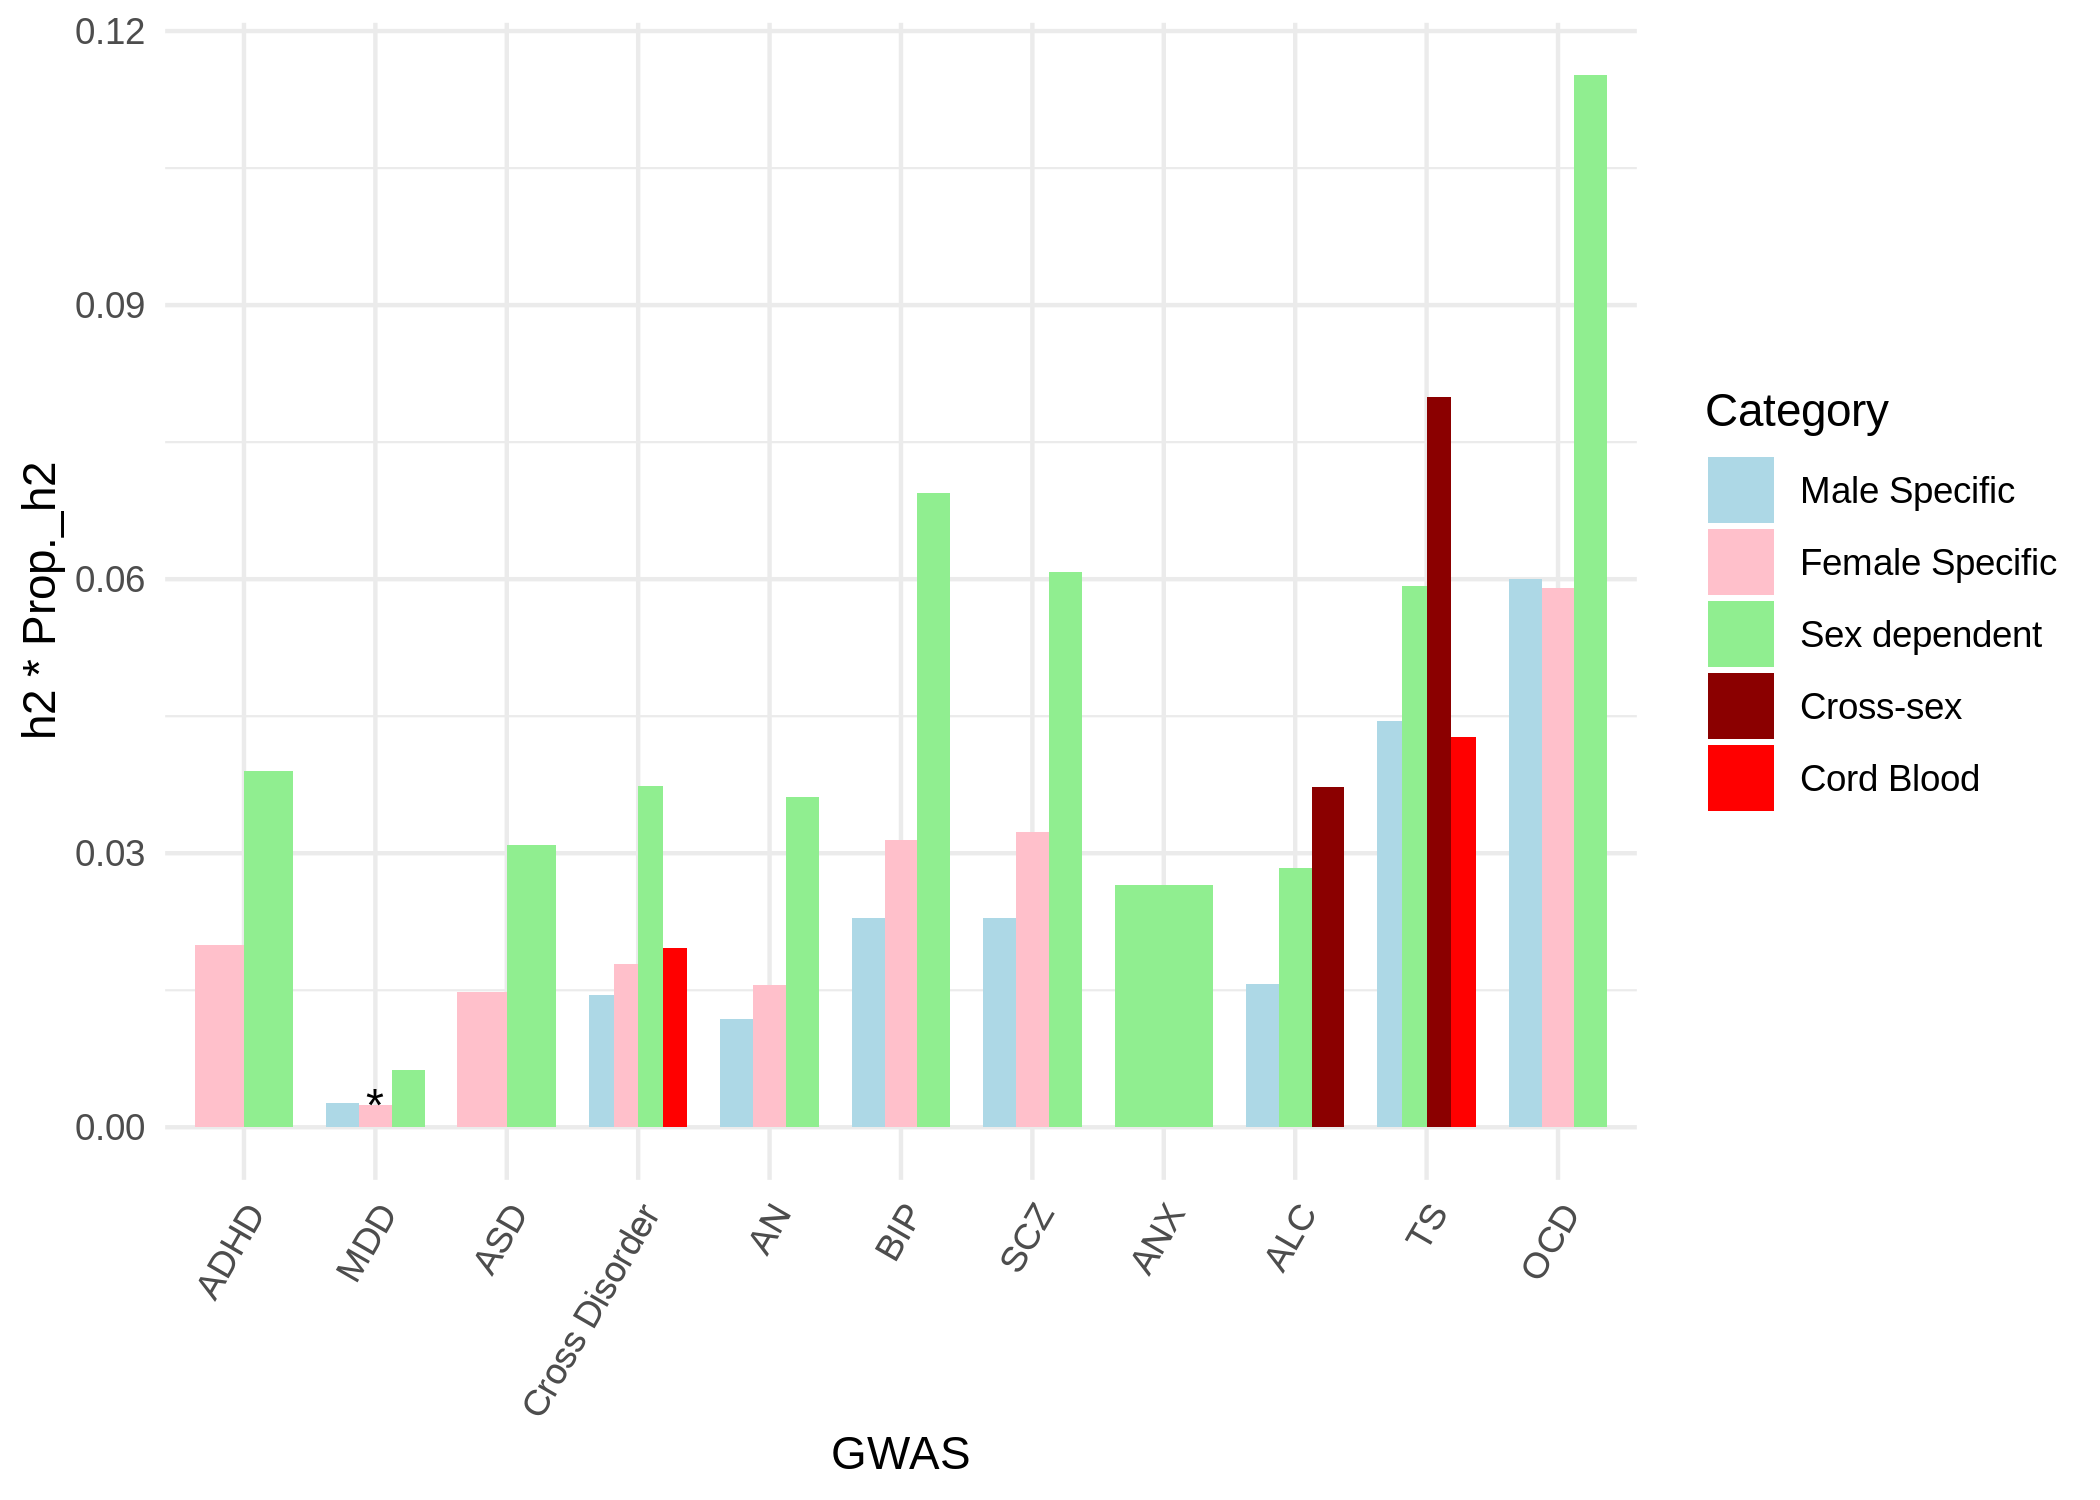

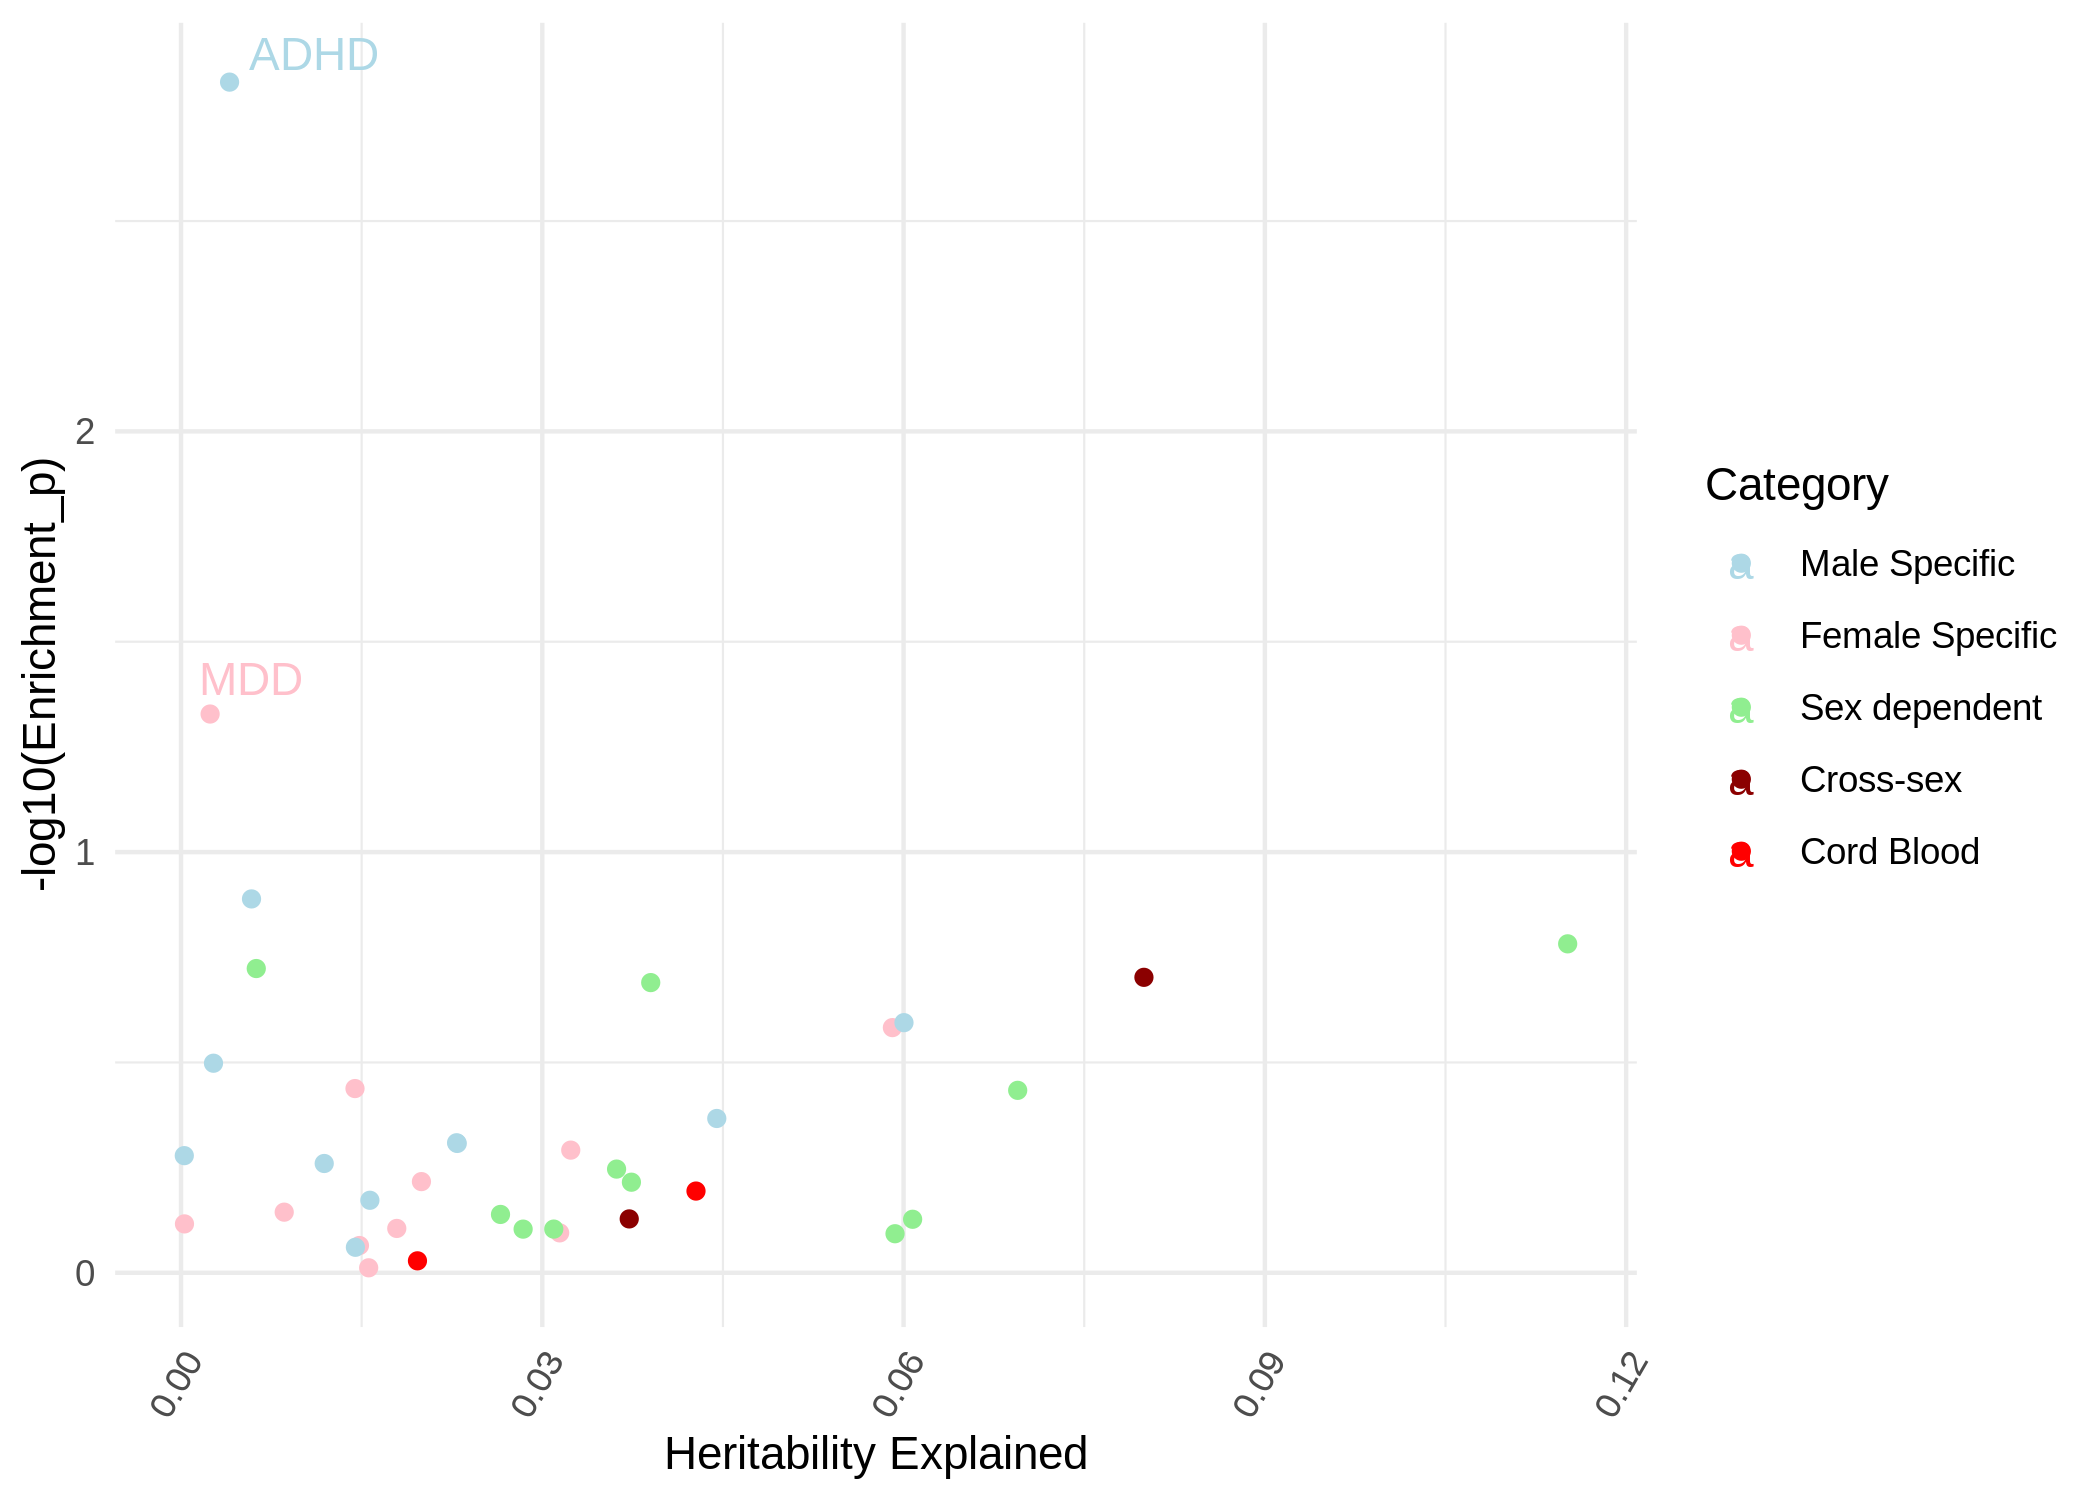

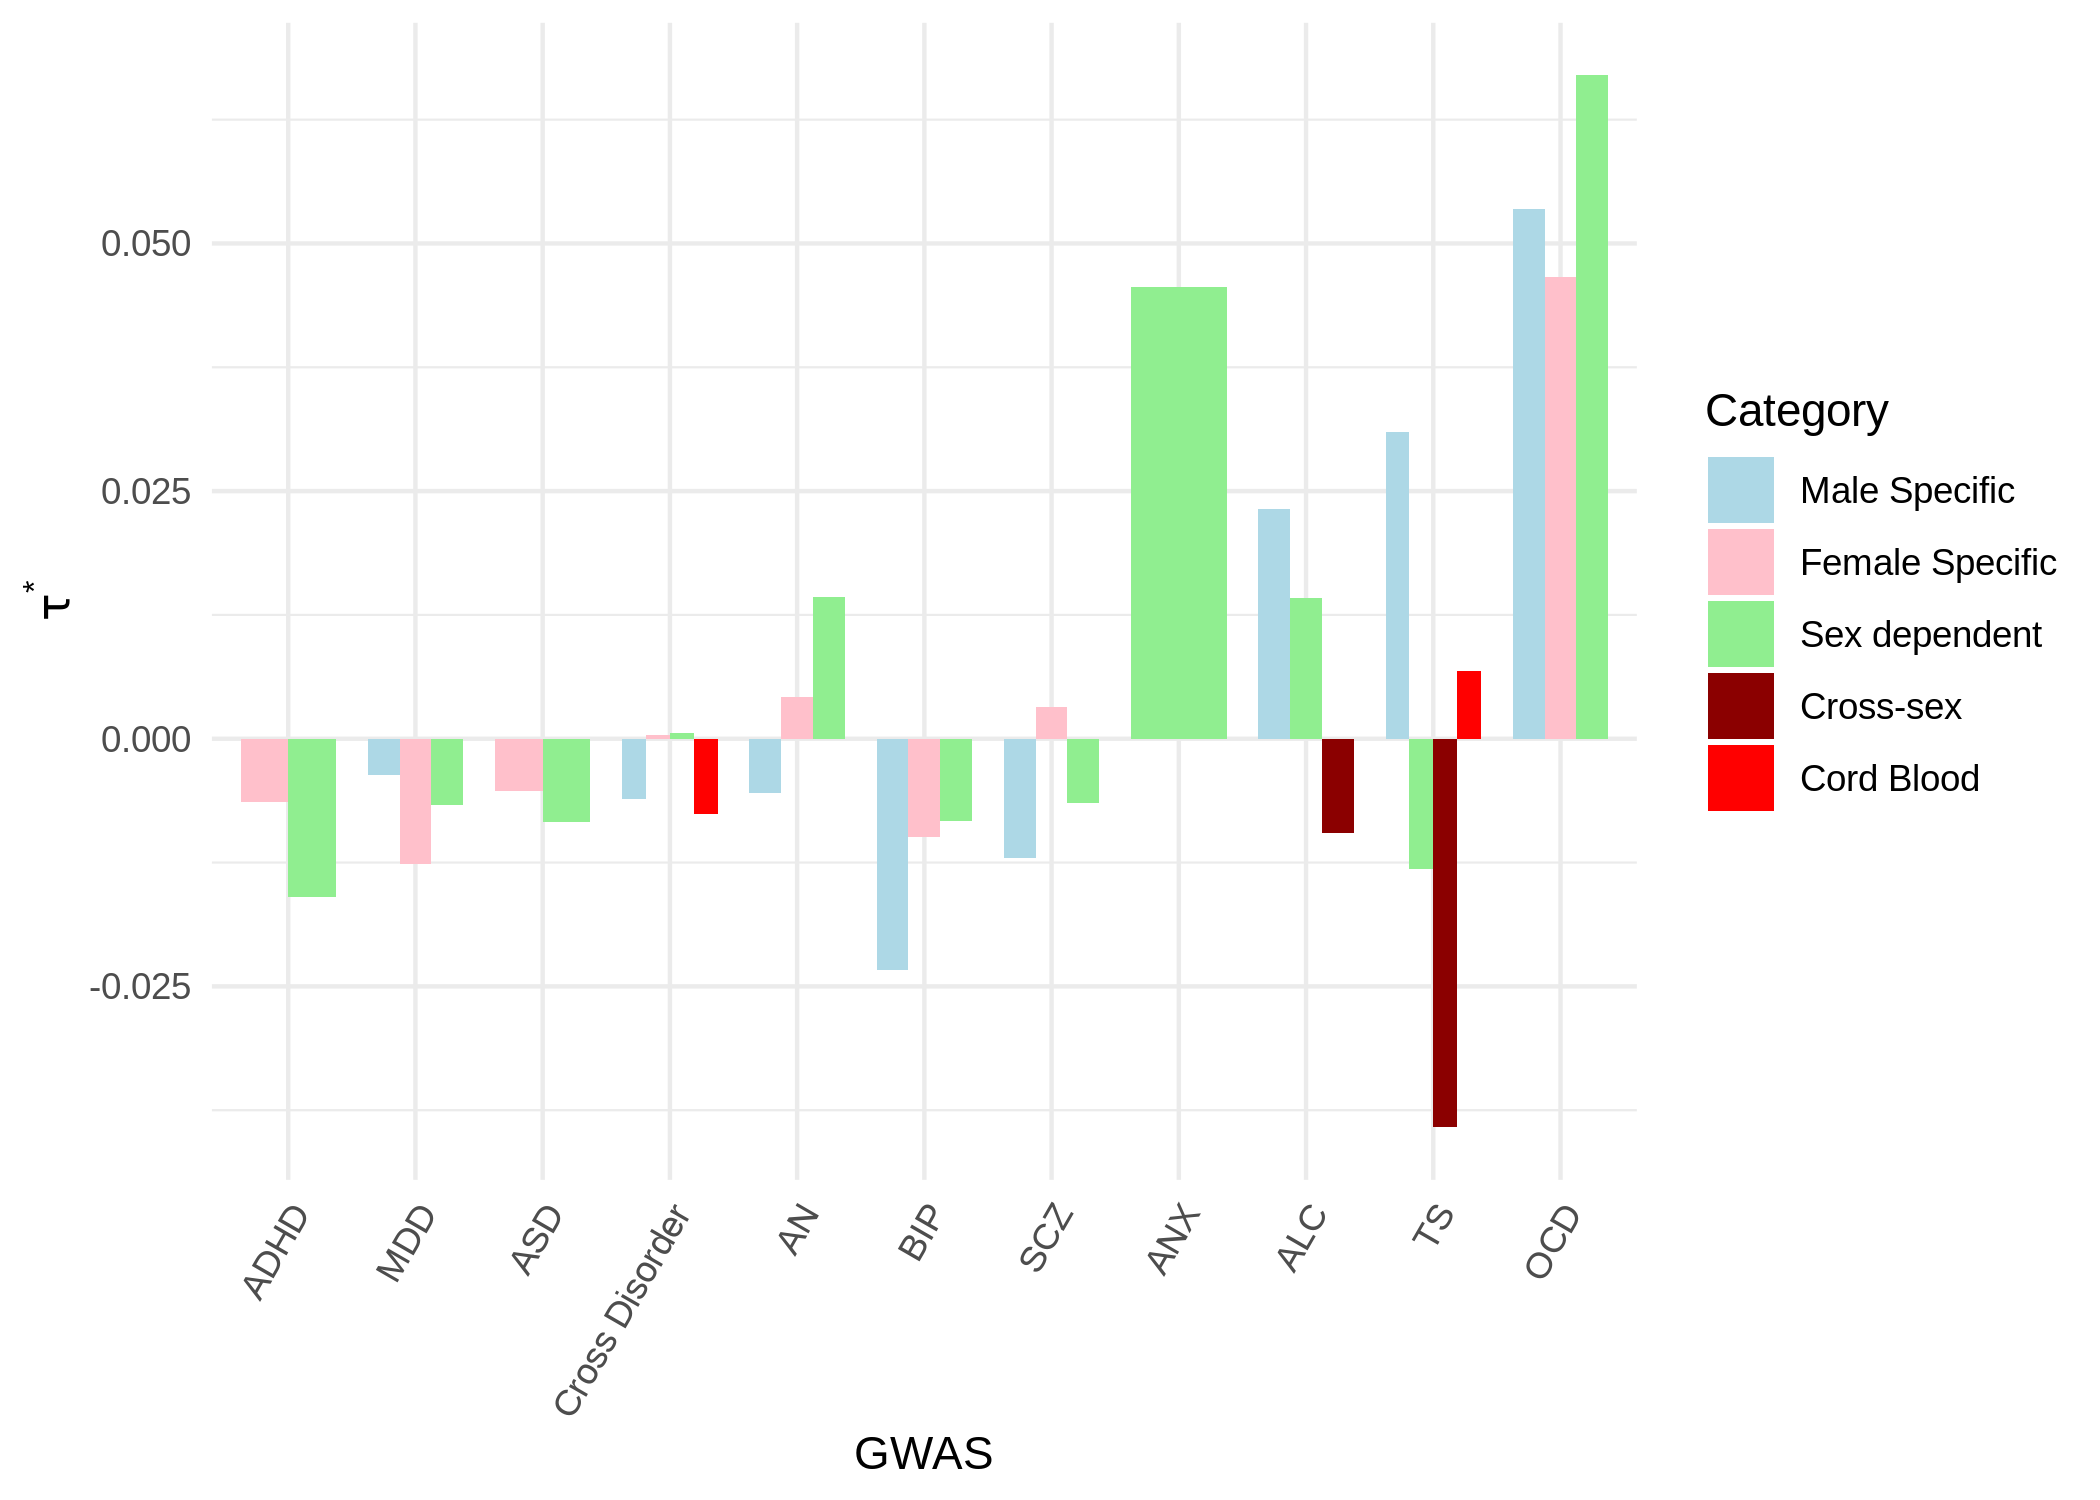

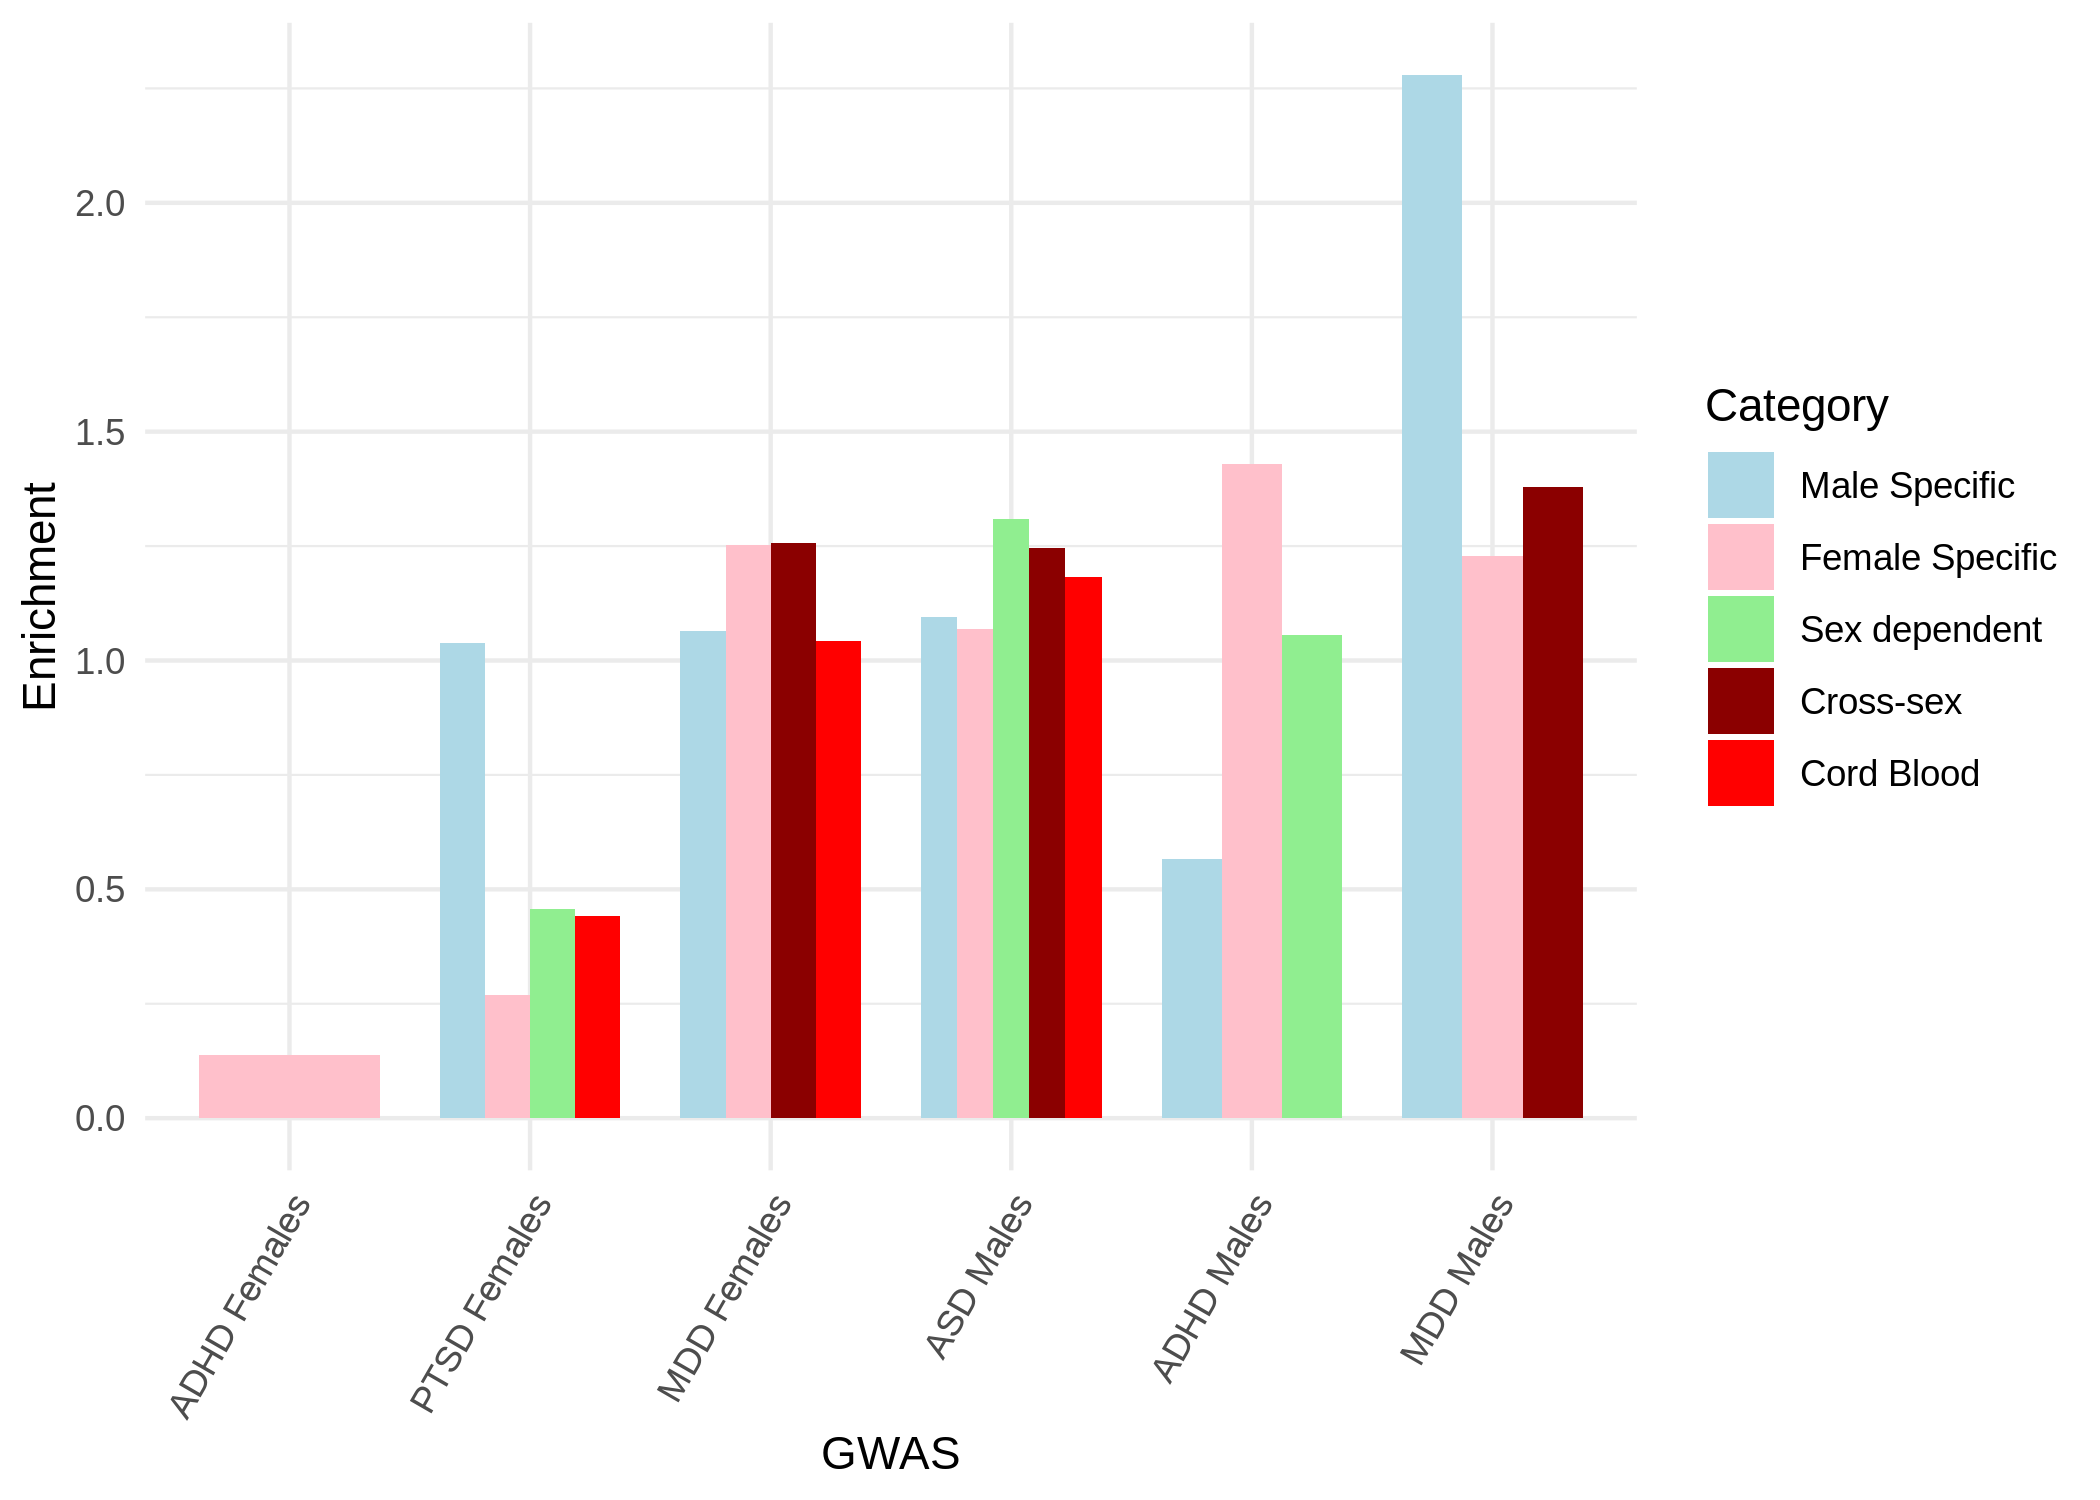

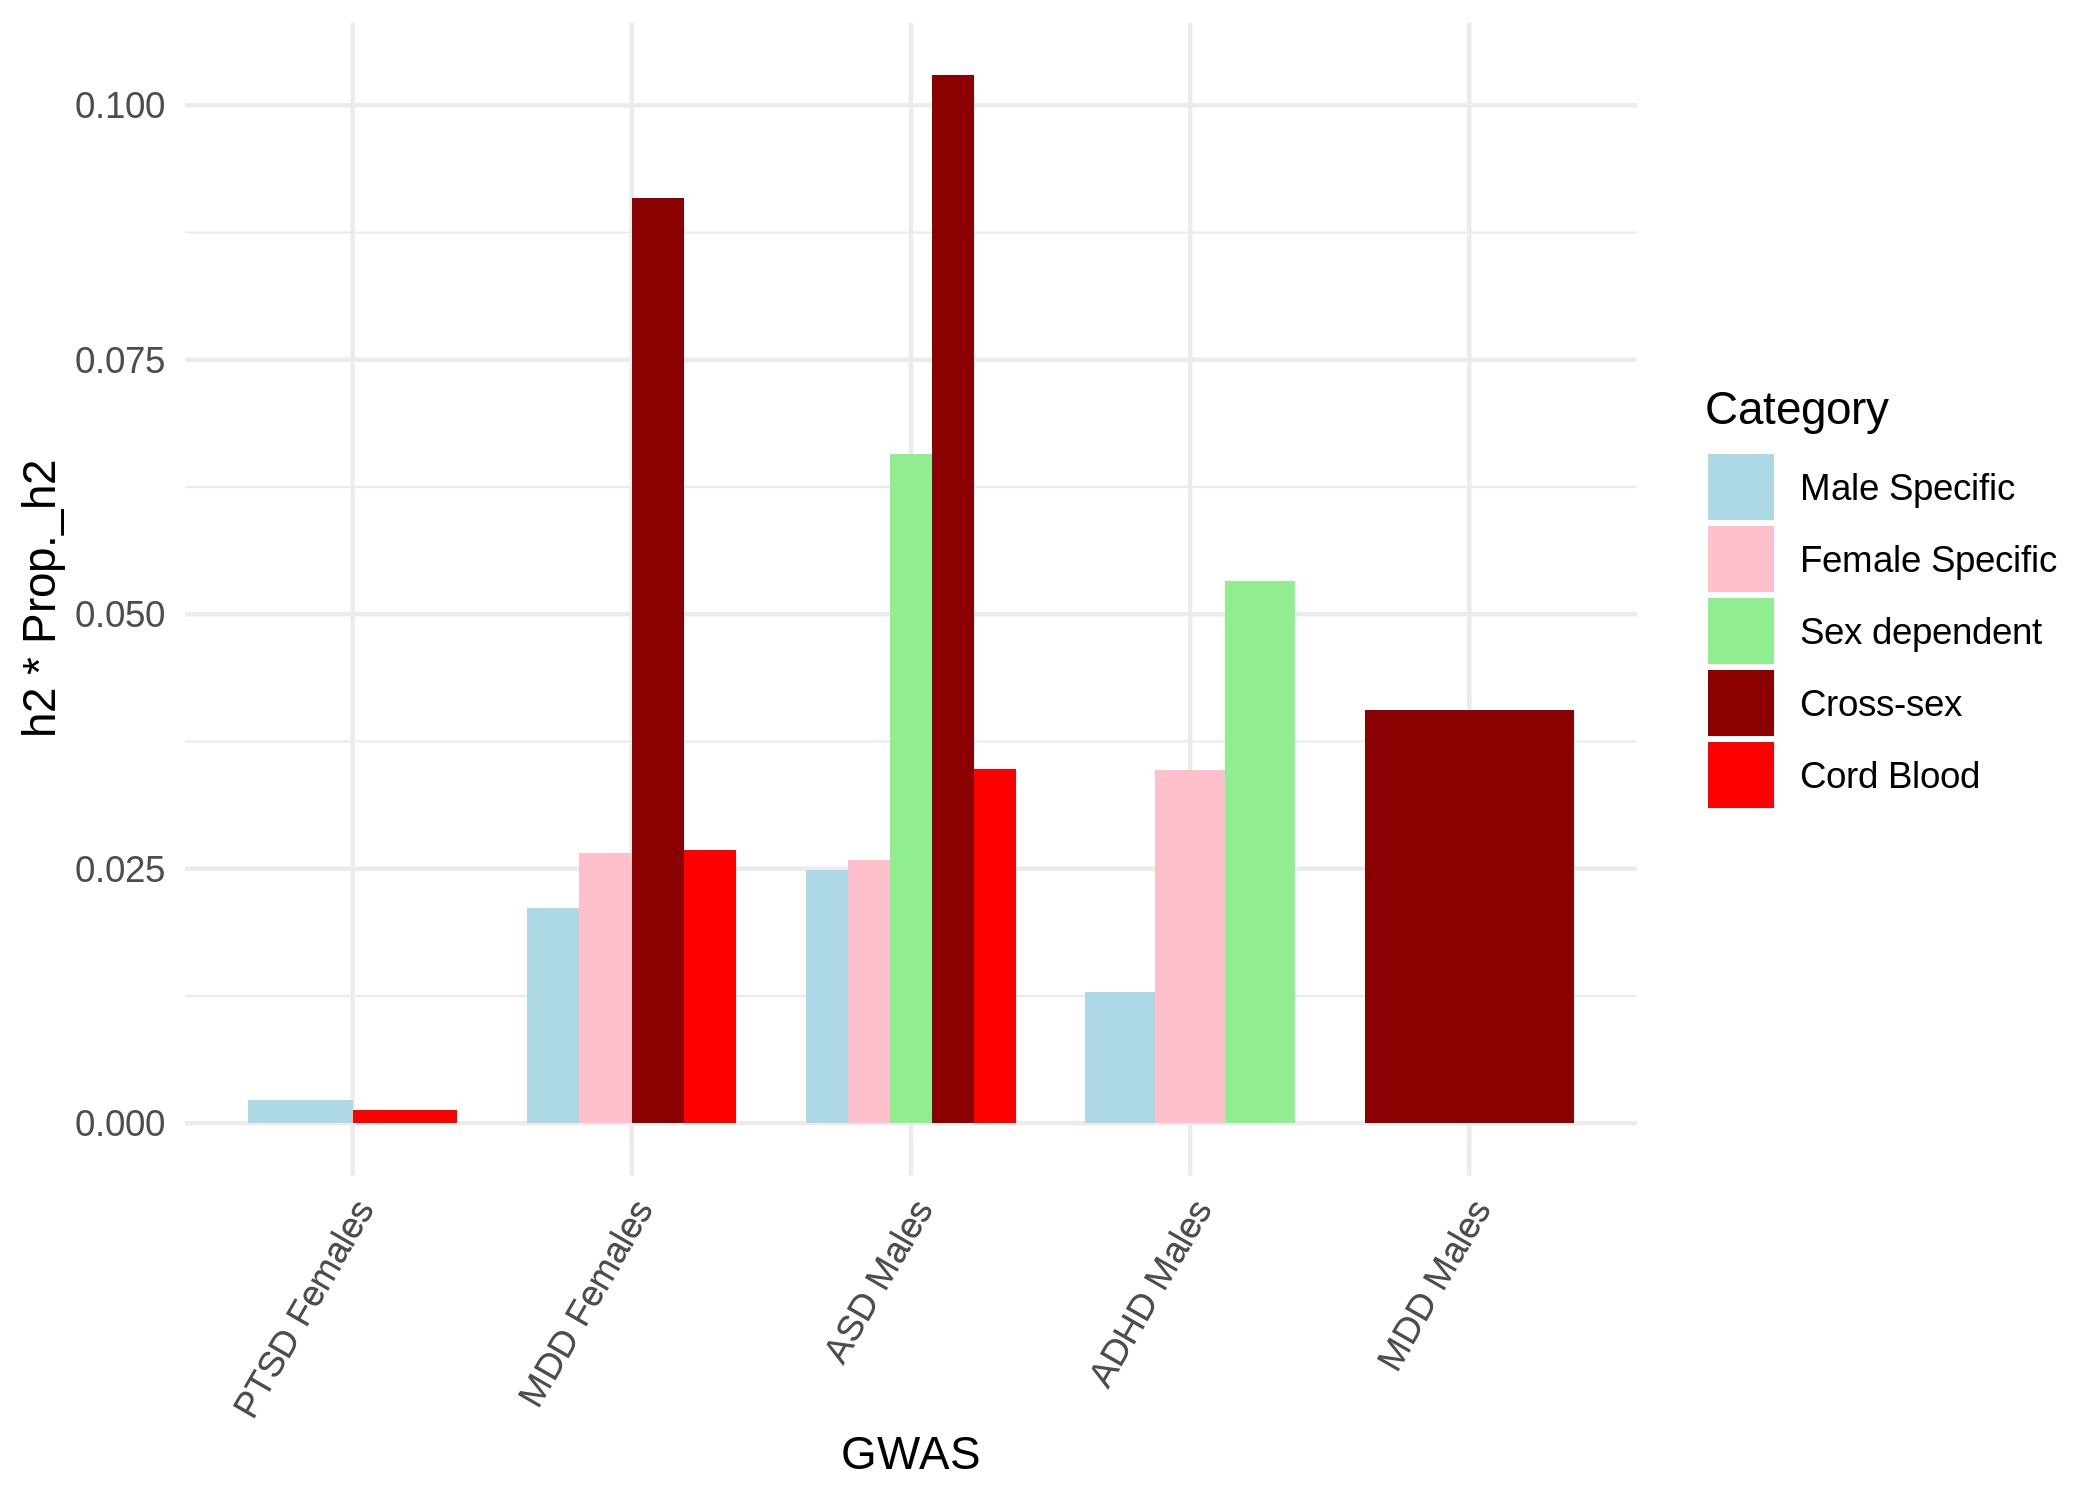

In [51]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
exclude_list <- c("PTSD Males","ASD Females","ANXFS","Alcohol (AUDIT)","Cannabis","Cigarettes Per Day") 
annot_order <- c("Male Specific","Female Specific","Sex dependent","Cross-sex", "Cord Blood")

order_dt <-     pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_order&
        annotation == "bin_CPP_her" &
        Enrichment > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
order_sex_dt <-     pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order&
        annotation == "bin_CPP_her" &
        Enrichment  > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_sex_order <- order_sex_dt[order(max_enrich)]$GWAS

ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(Enrichment_p < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=h2*Prop._h2,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
to_plot <- pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment> 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order))
ggplot(to_plot,
    aes(color = Category, x=h2*Prop._h2,y=-log10(Enrichment_p)))+
    geom_point() + 
    geom_text_repel(label=ifelse(to_plot$significant_enrich,as.character(to_plot$GWAS),""))+
    scale_color_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    labs(x="Heritability Explained")+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))


ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment  > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    pgc_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=h2 * Prop._h2,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

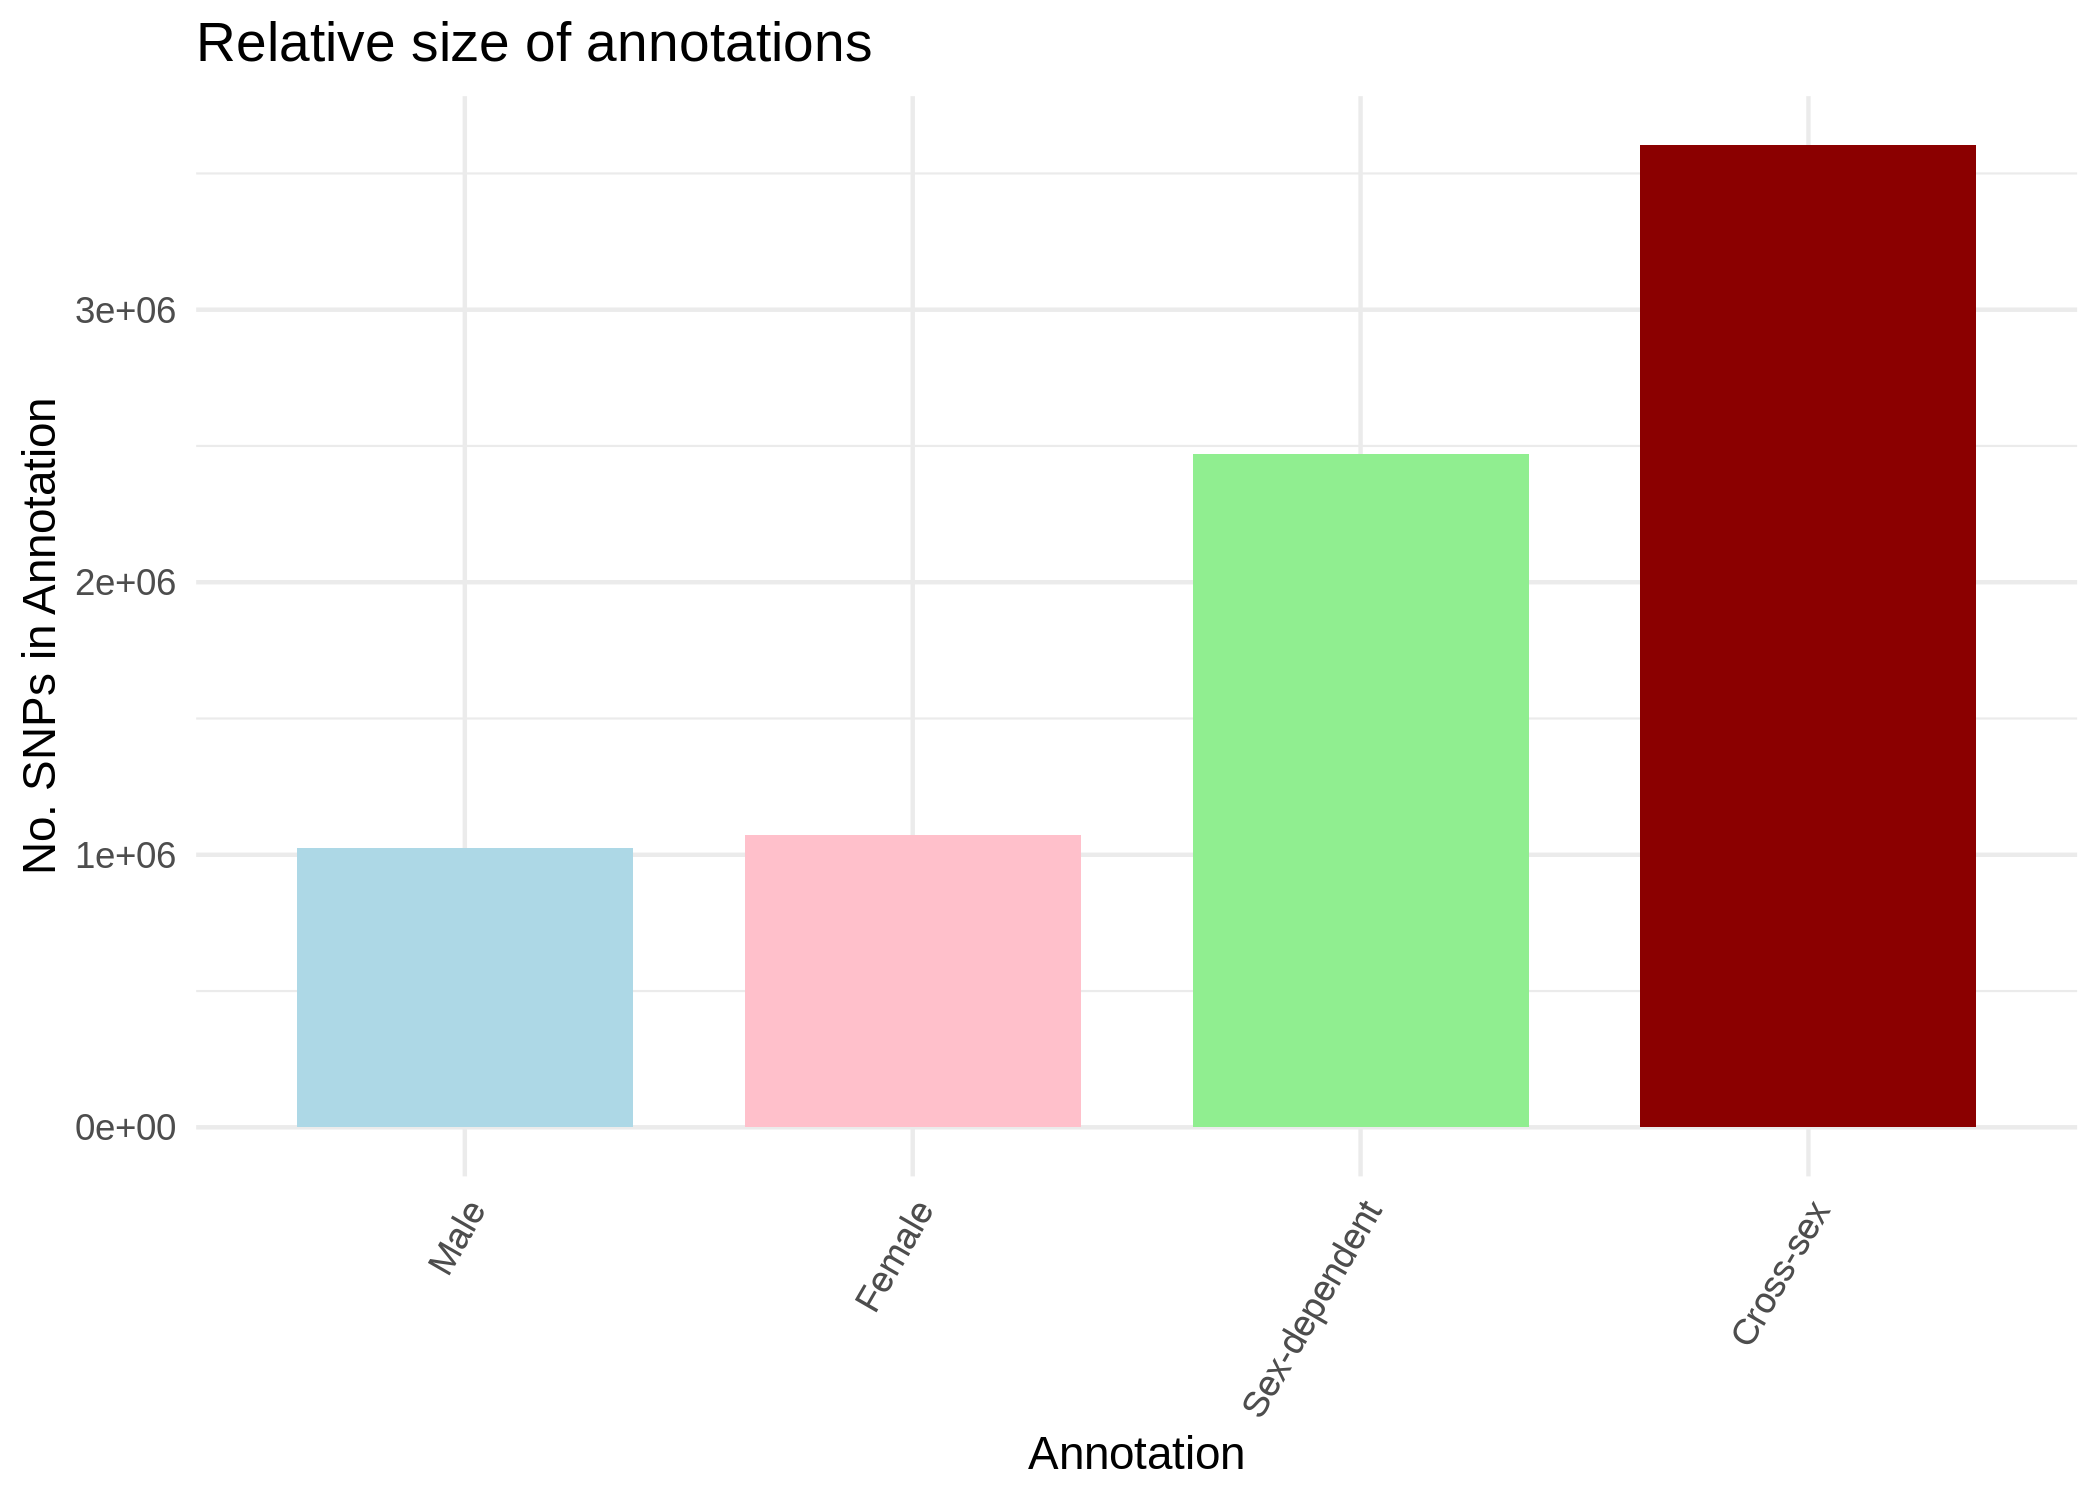

In [23]:
annotation_size <- data.table( Annotation_size=c(3603419, 2470402,1025888,1071077),
           Annotation = c("Cross-sex","Sex-dependent","Male","Female"))
ggplot(annotation_size %>% mutate(Annotation=factor(Annotation,levels=c("Male","Female","Sex-dependent","Cross-sex"))), aes(Annotation,Annotation_size,fill=Annotation)) + 
    geom_col(position="dodge",width=0.75) + 
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    labs(y = "No. SNPs in Annotation",title = "Relative size of annotations") +
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1),legend.position = "" )

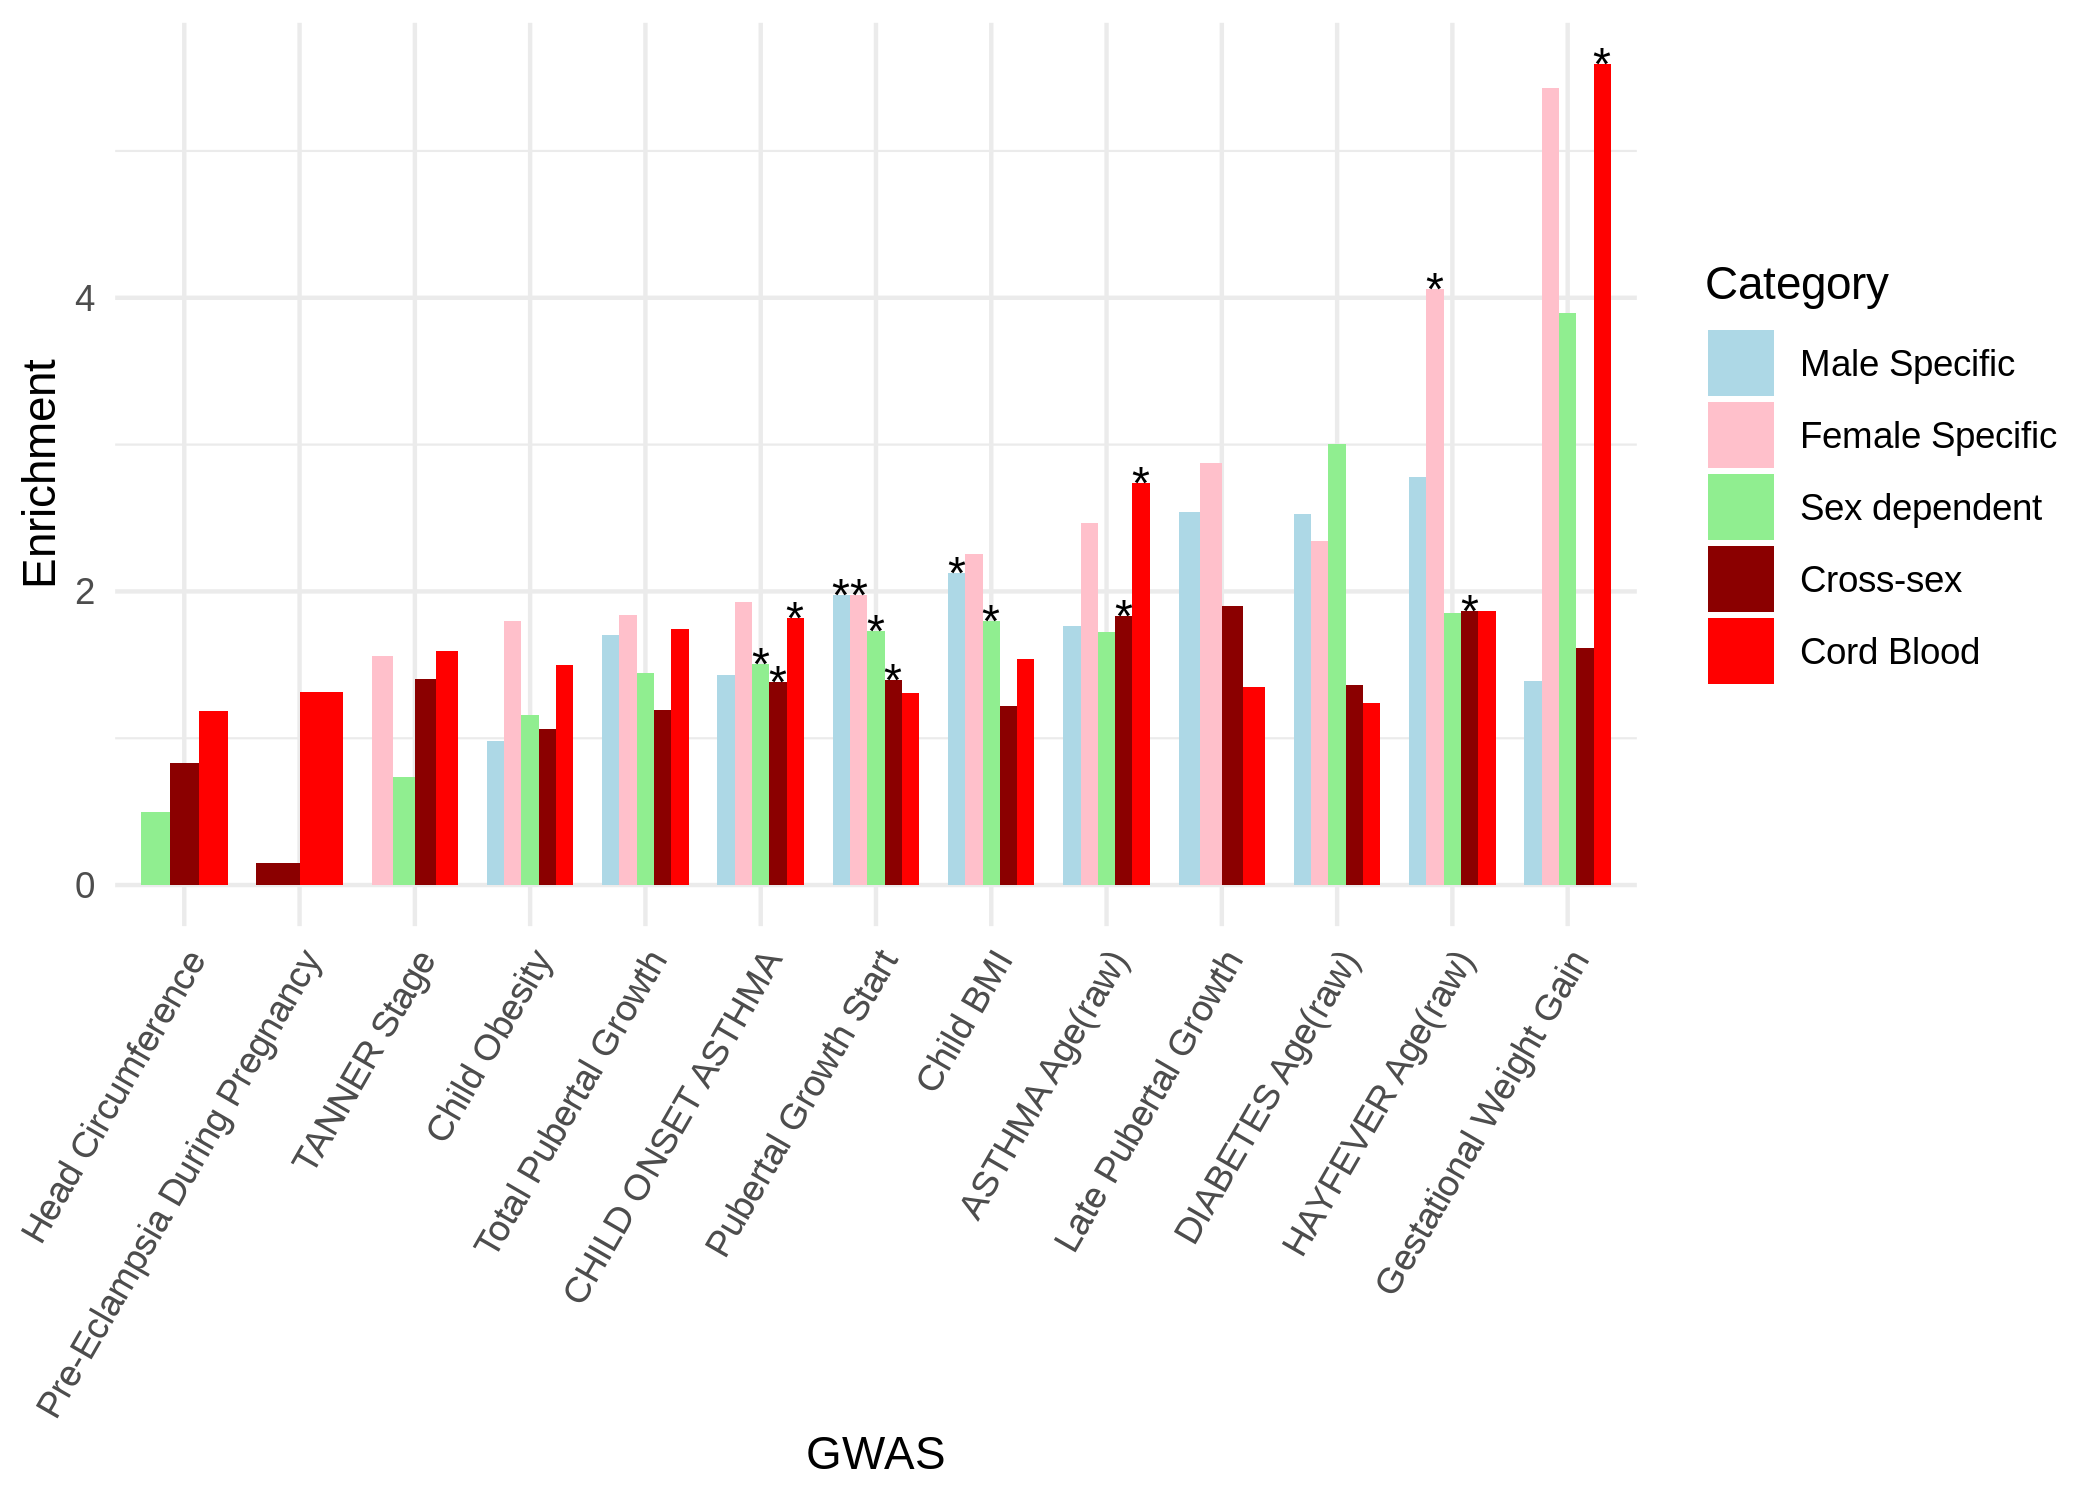

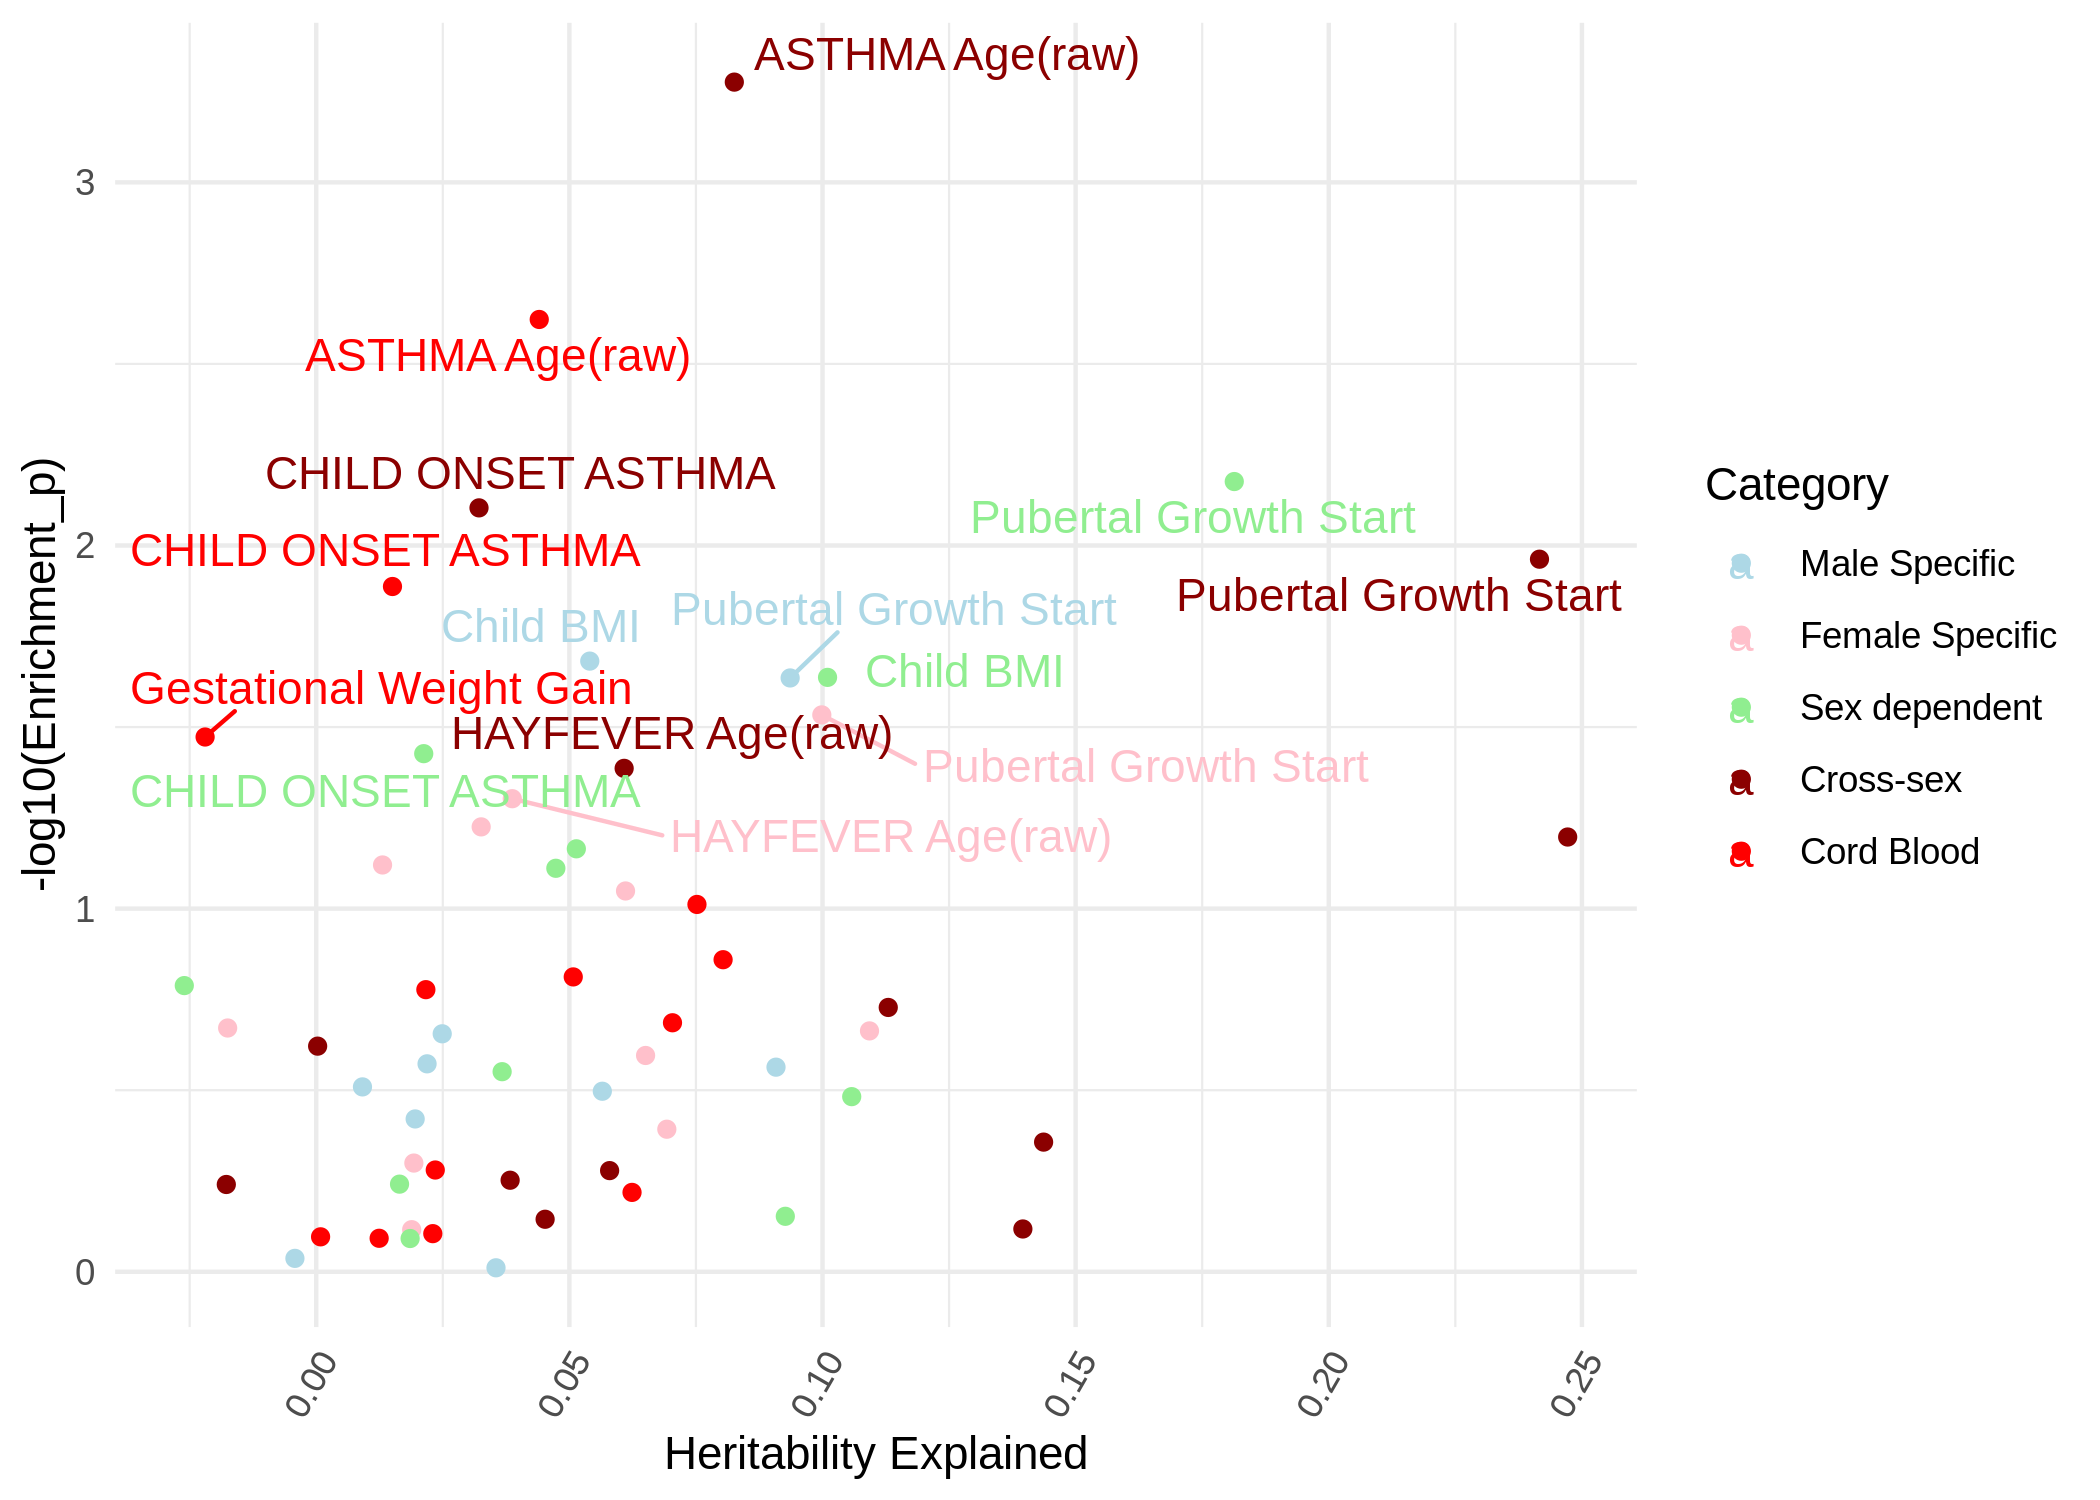

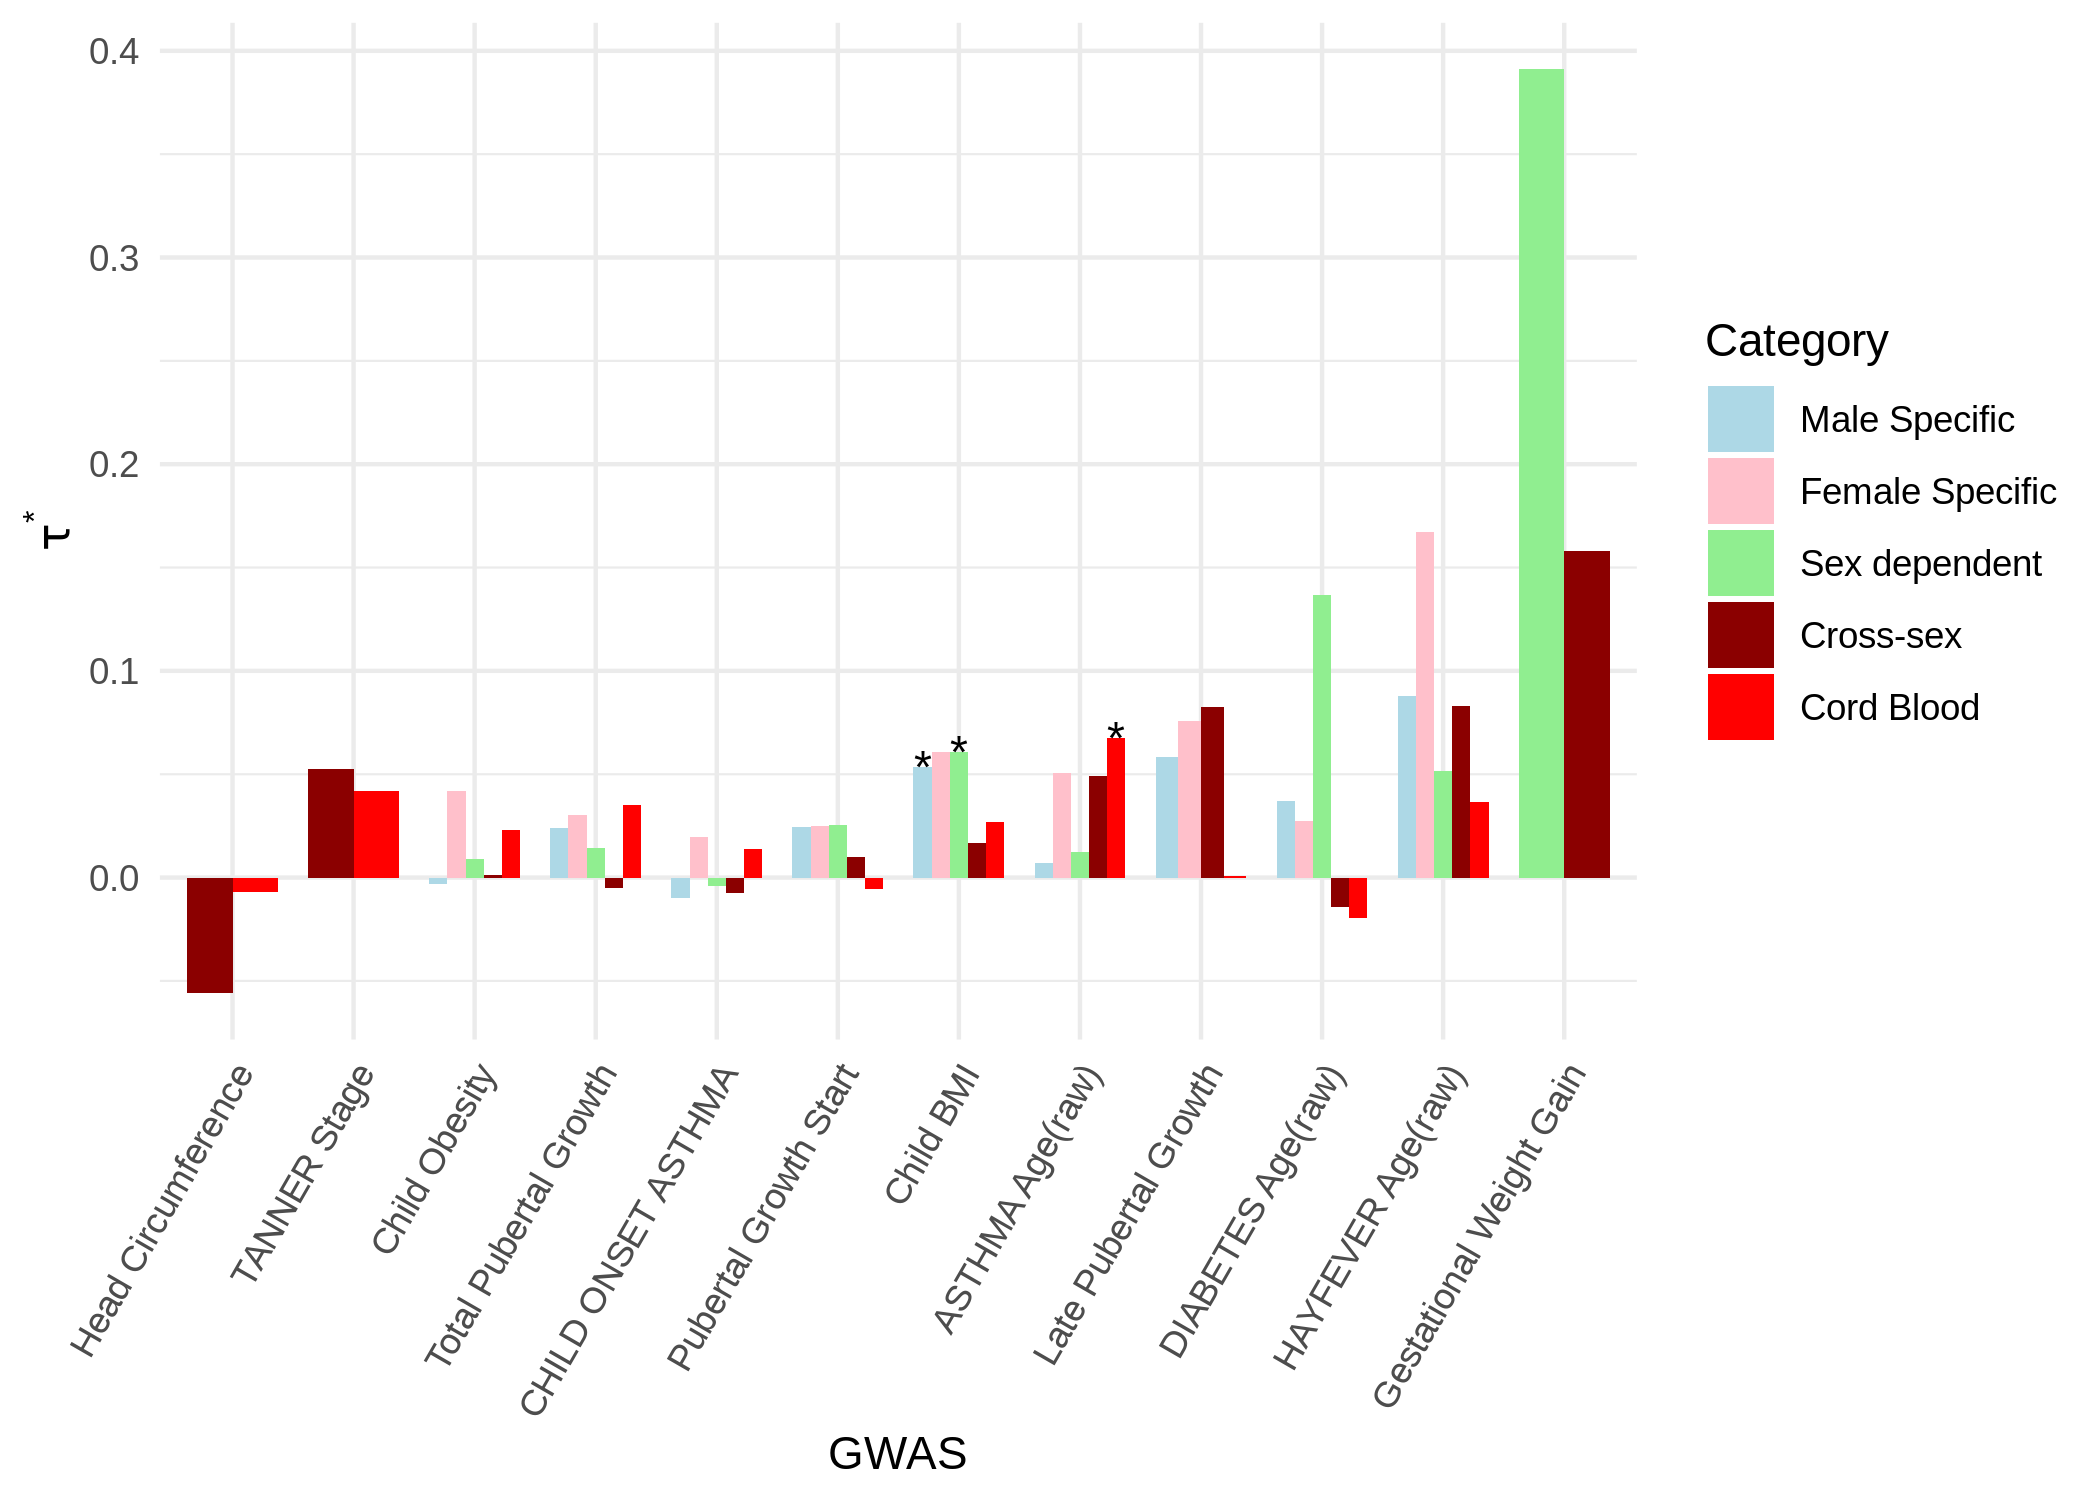

In [48]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
library(ggrepel)
exclude_list <- unique(neonatal_part_heritability_independent_df$GWAS[grepl("norm",neonatal_part_heritability_df$GWAS)])
annot_categories <- c("Male Specific","Female Specific","Sex dependent","Cross-sex", "Cord Blood")
order_dt <-     neonatal_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment  > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
annot_order <- annot_categories


ggplot(
    neonatal_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment> 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
to_plot <- neonatal_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment> 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order))
ggplot(to_plot,
    aes(color = Category, x=h2*Prop._h2,y=-log10(Enrichment_p)))+
    geom_point() + 
    geom_text_repel(label=ifelse(to_plot$significant_enrich,as.character(to_plot$GWAS),""))+
    scale_color_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    labs(x="Heritability Explained")+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    neonatal_part_heritability_independent_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","light green", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

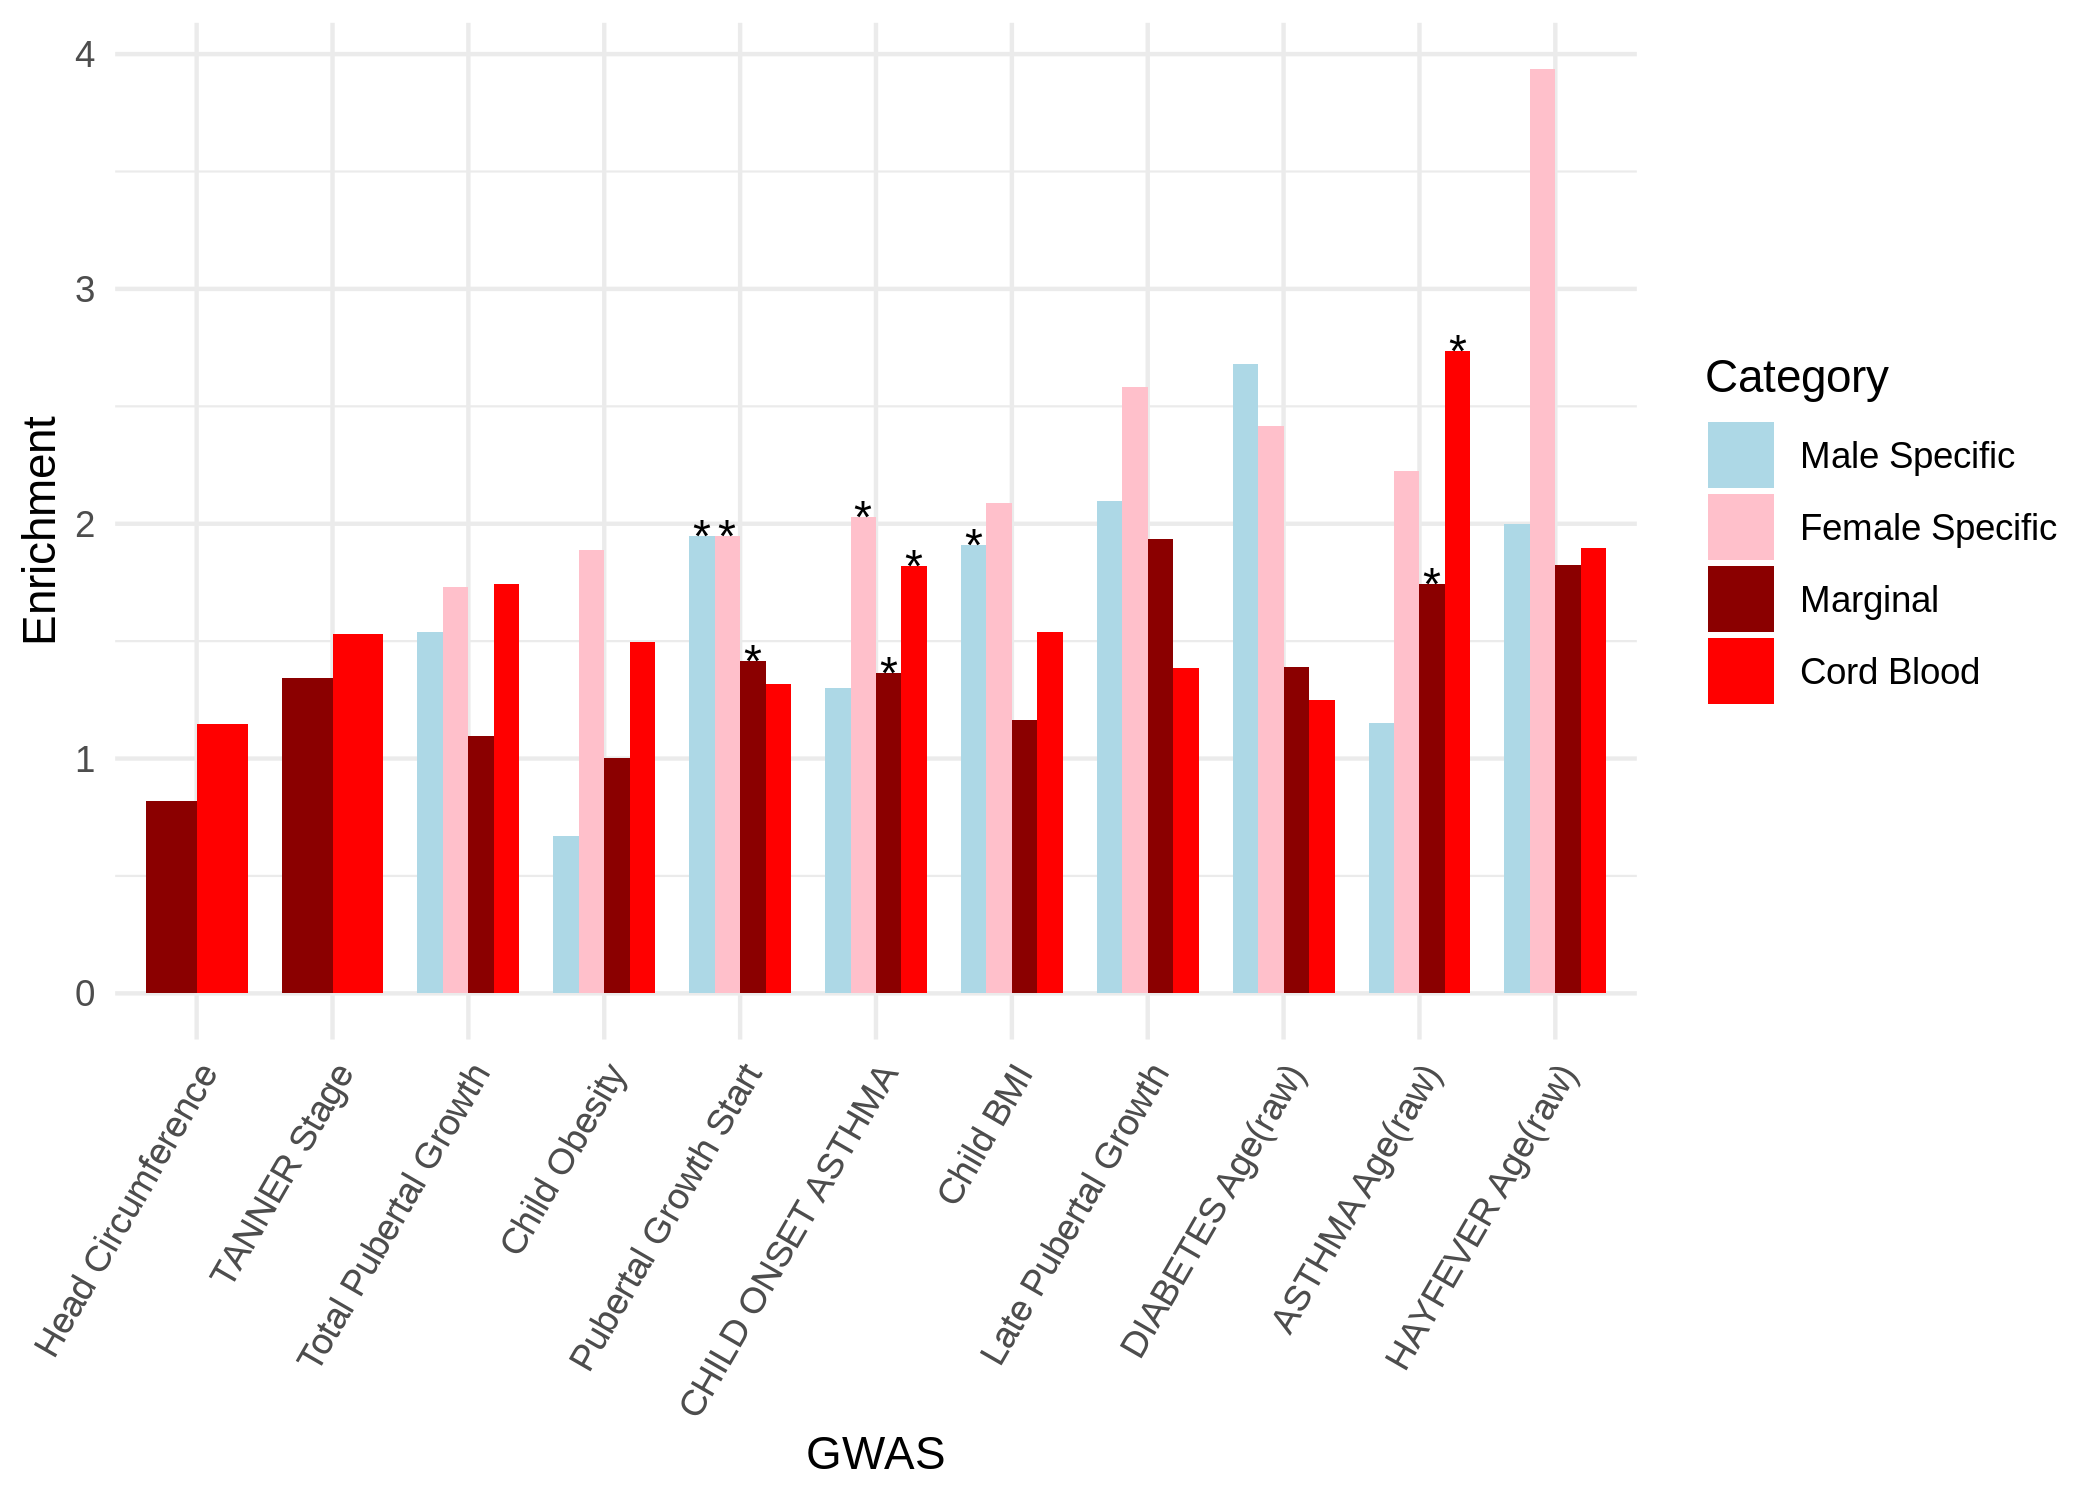

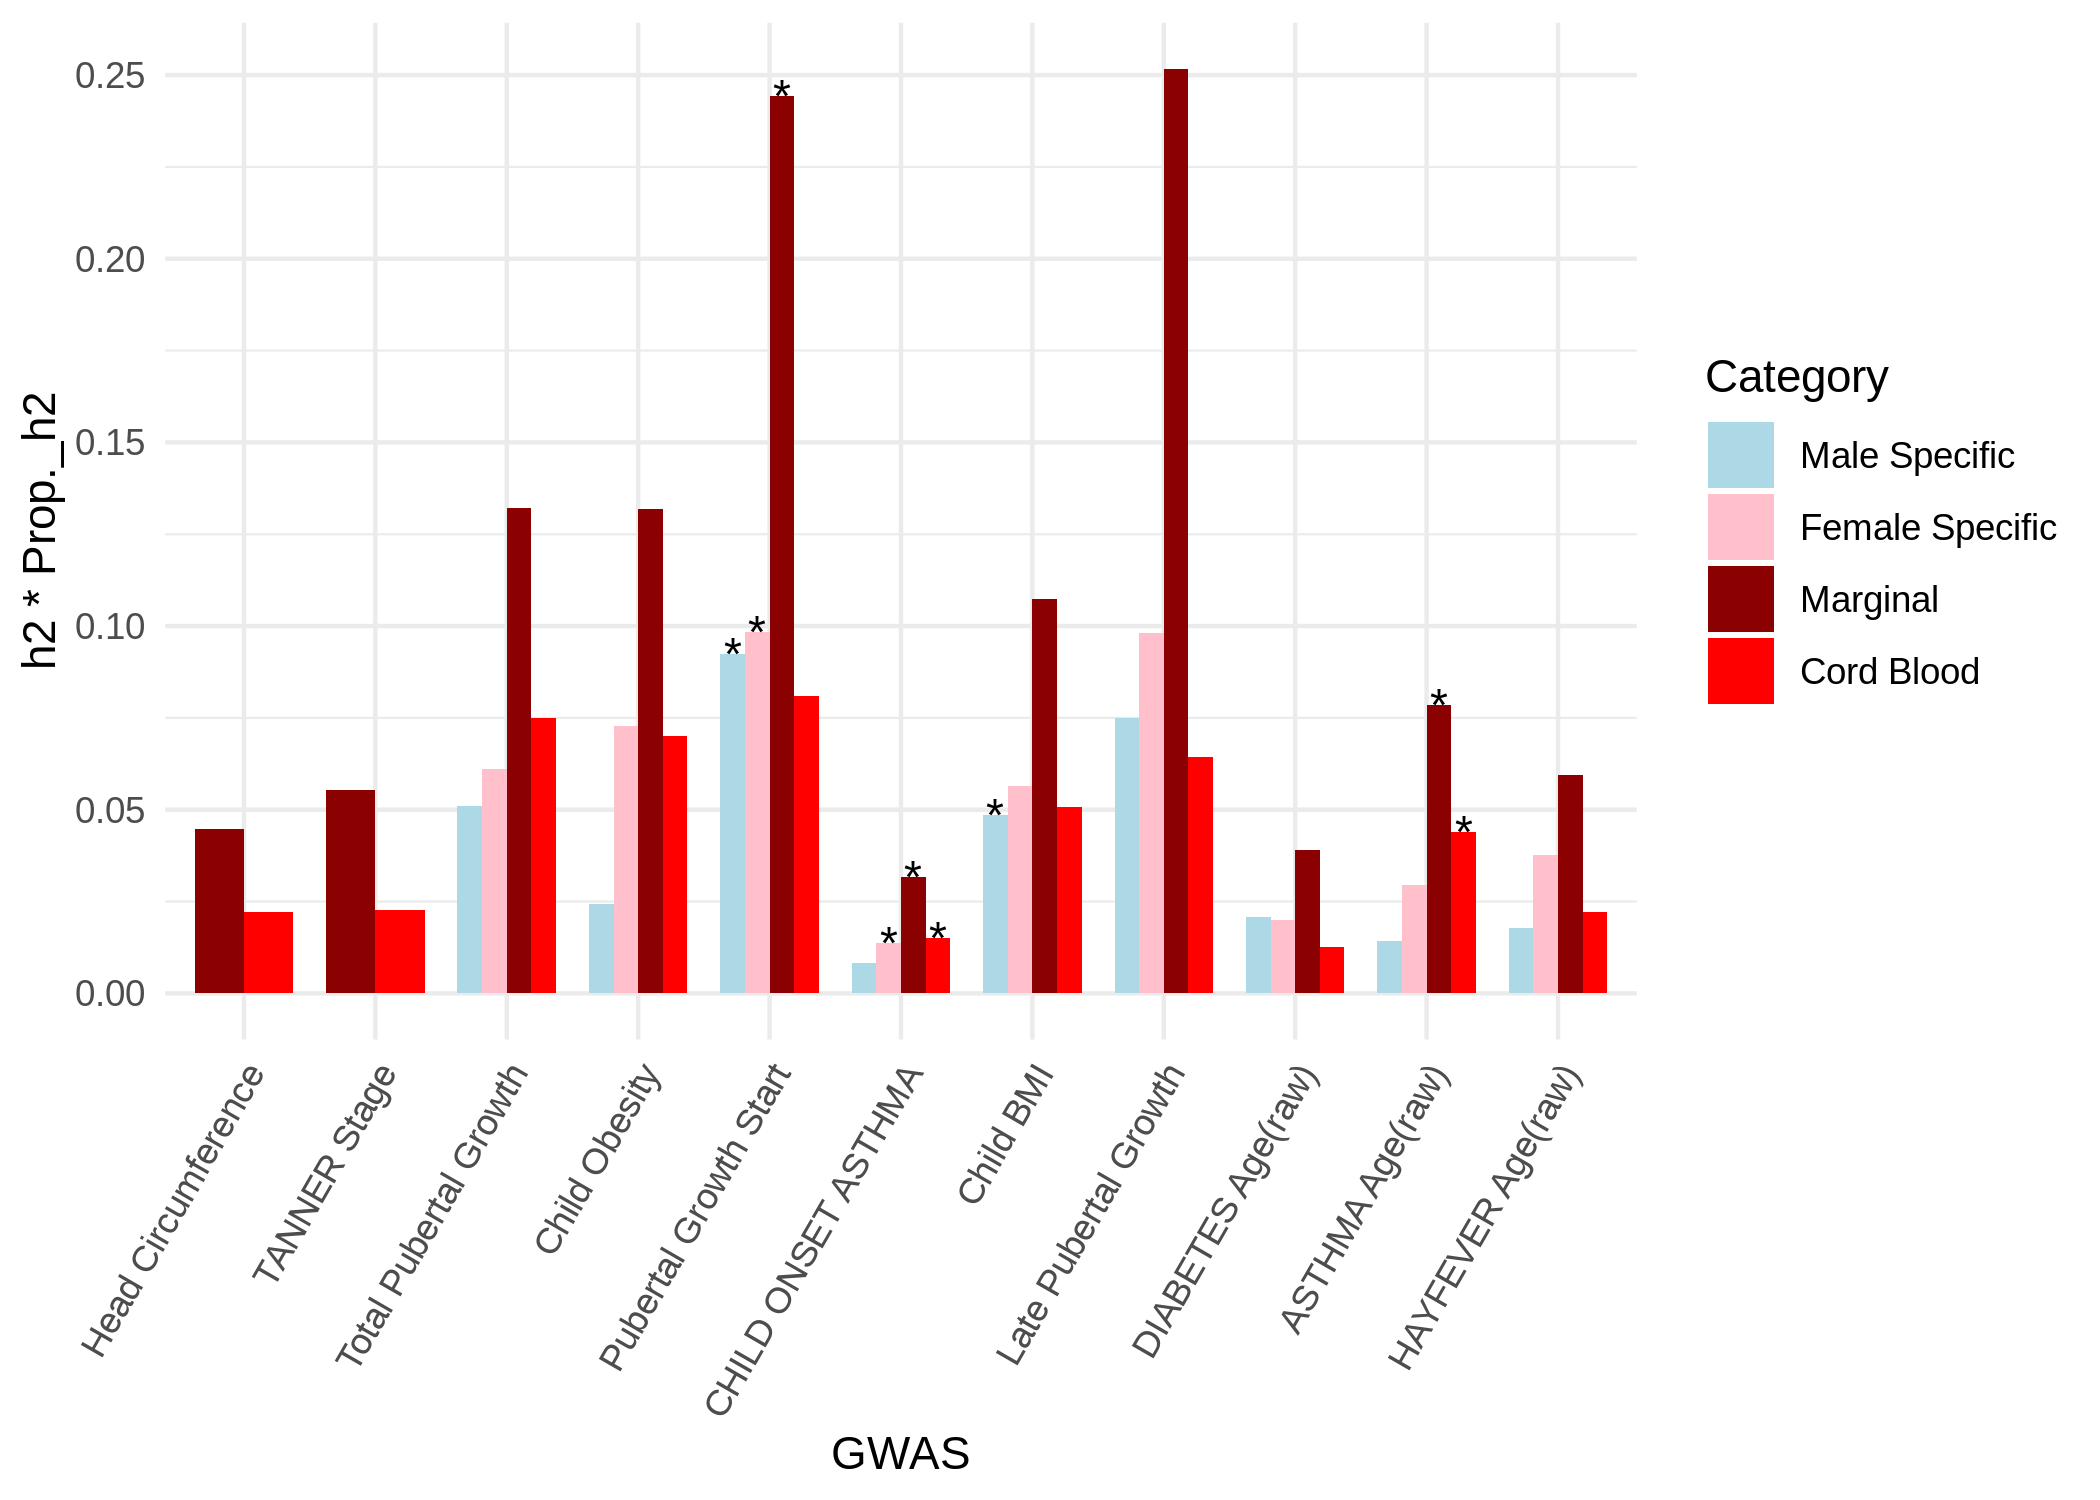

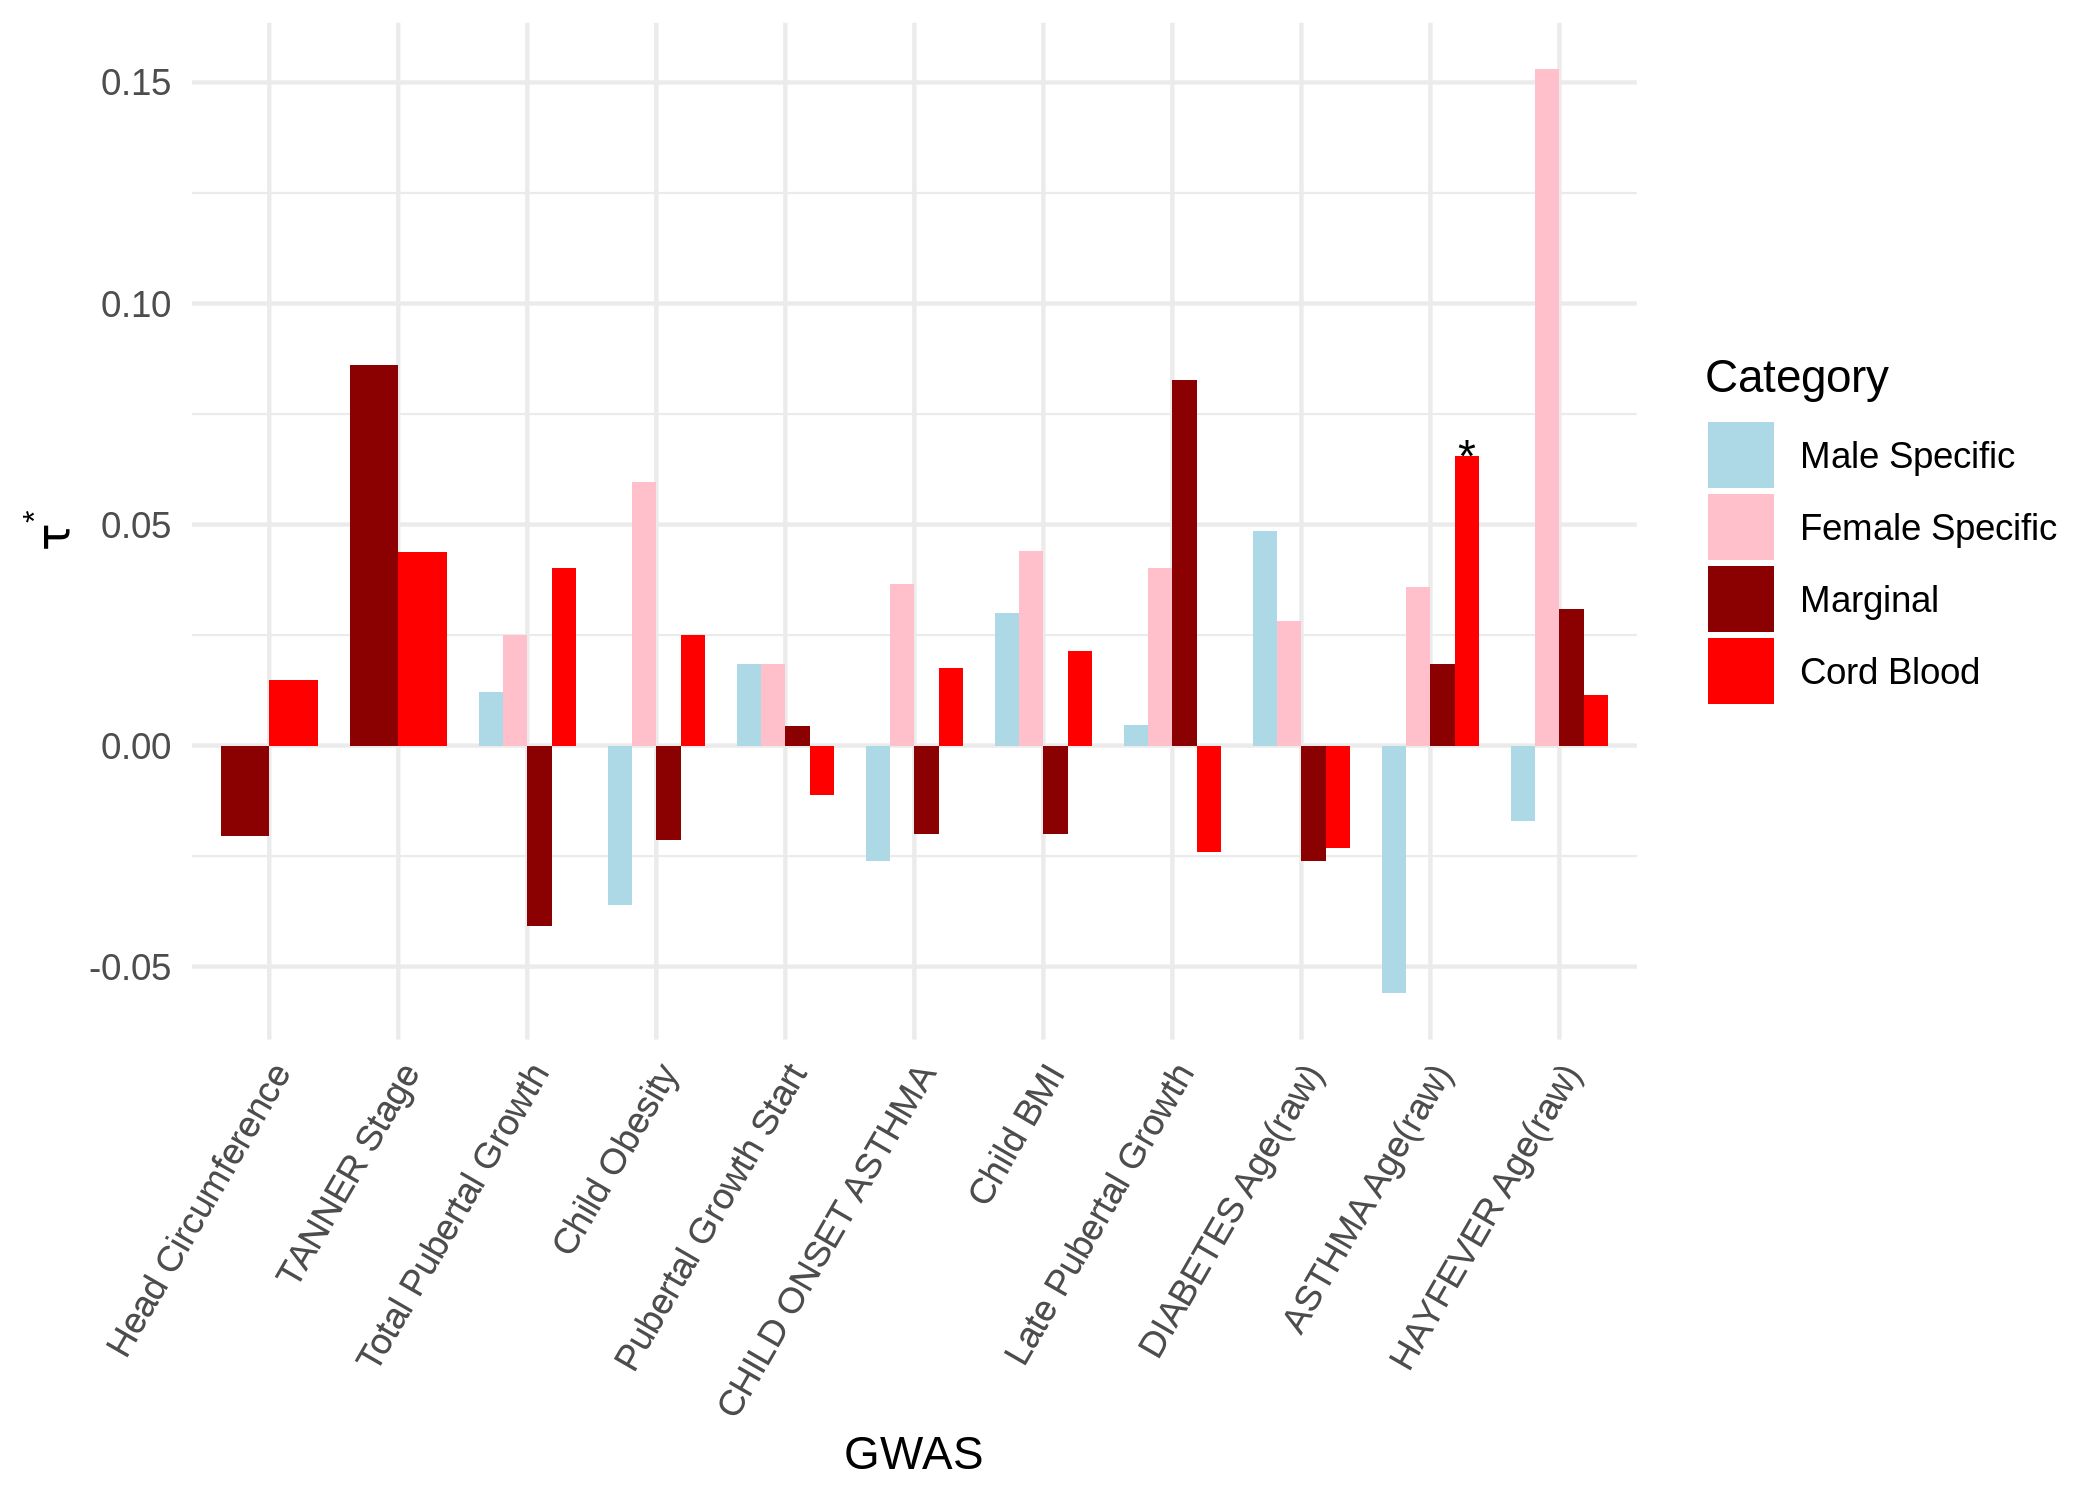

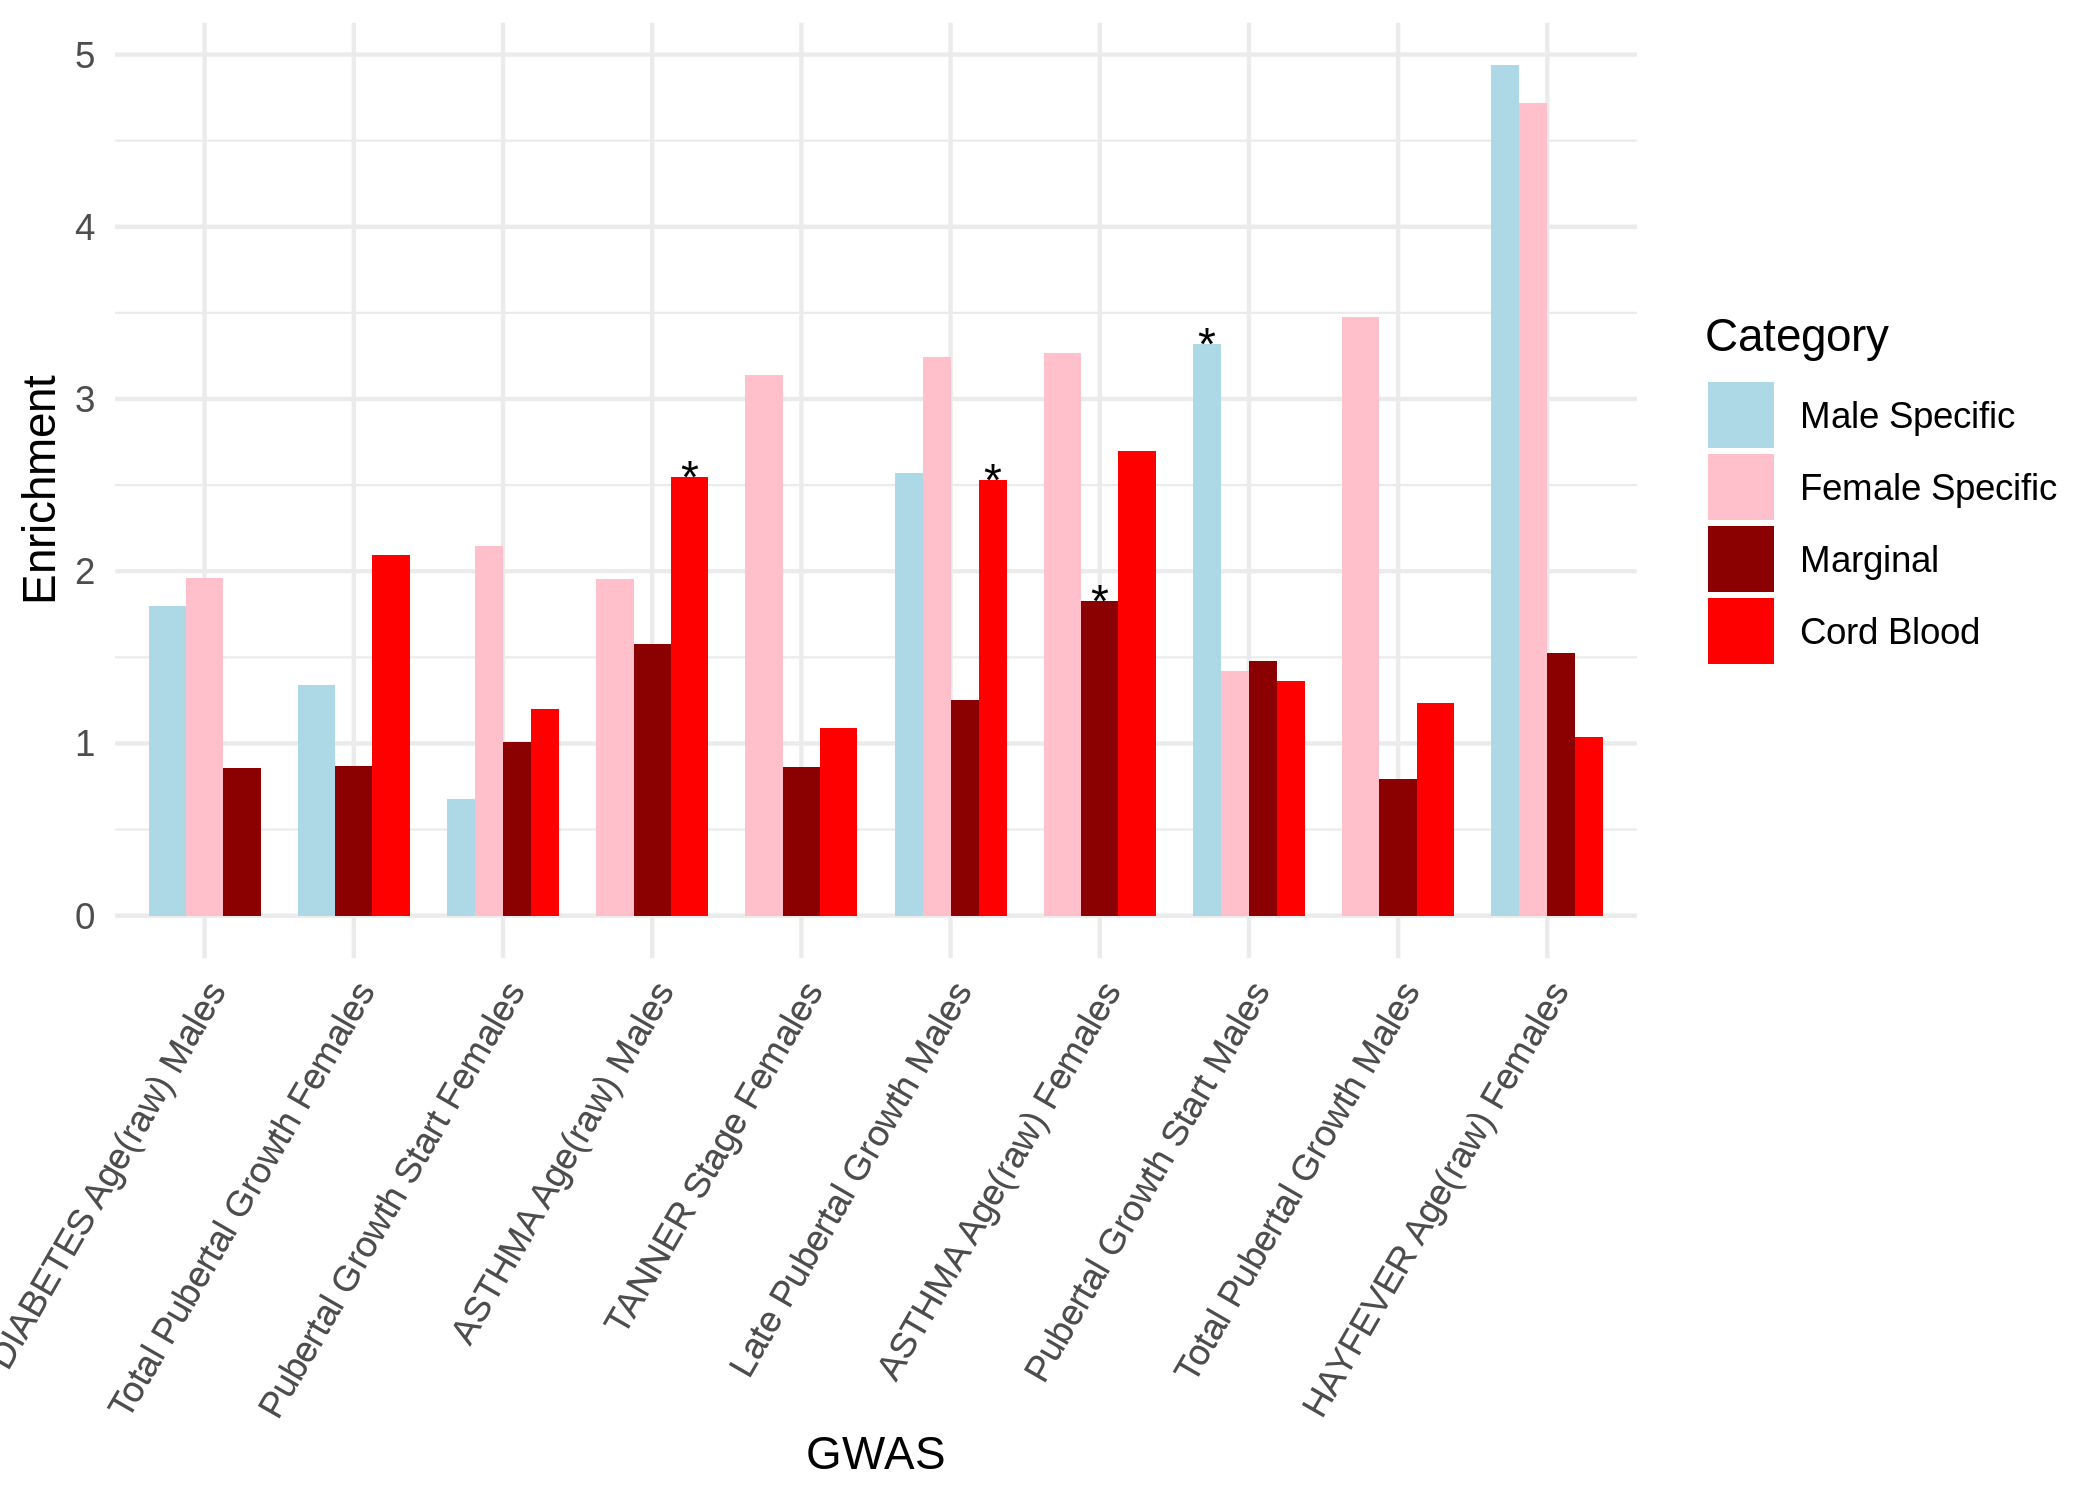

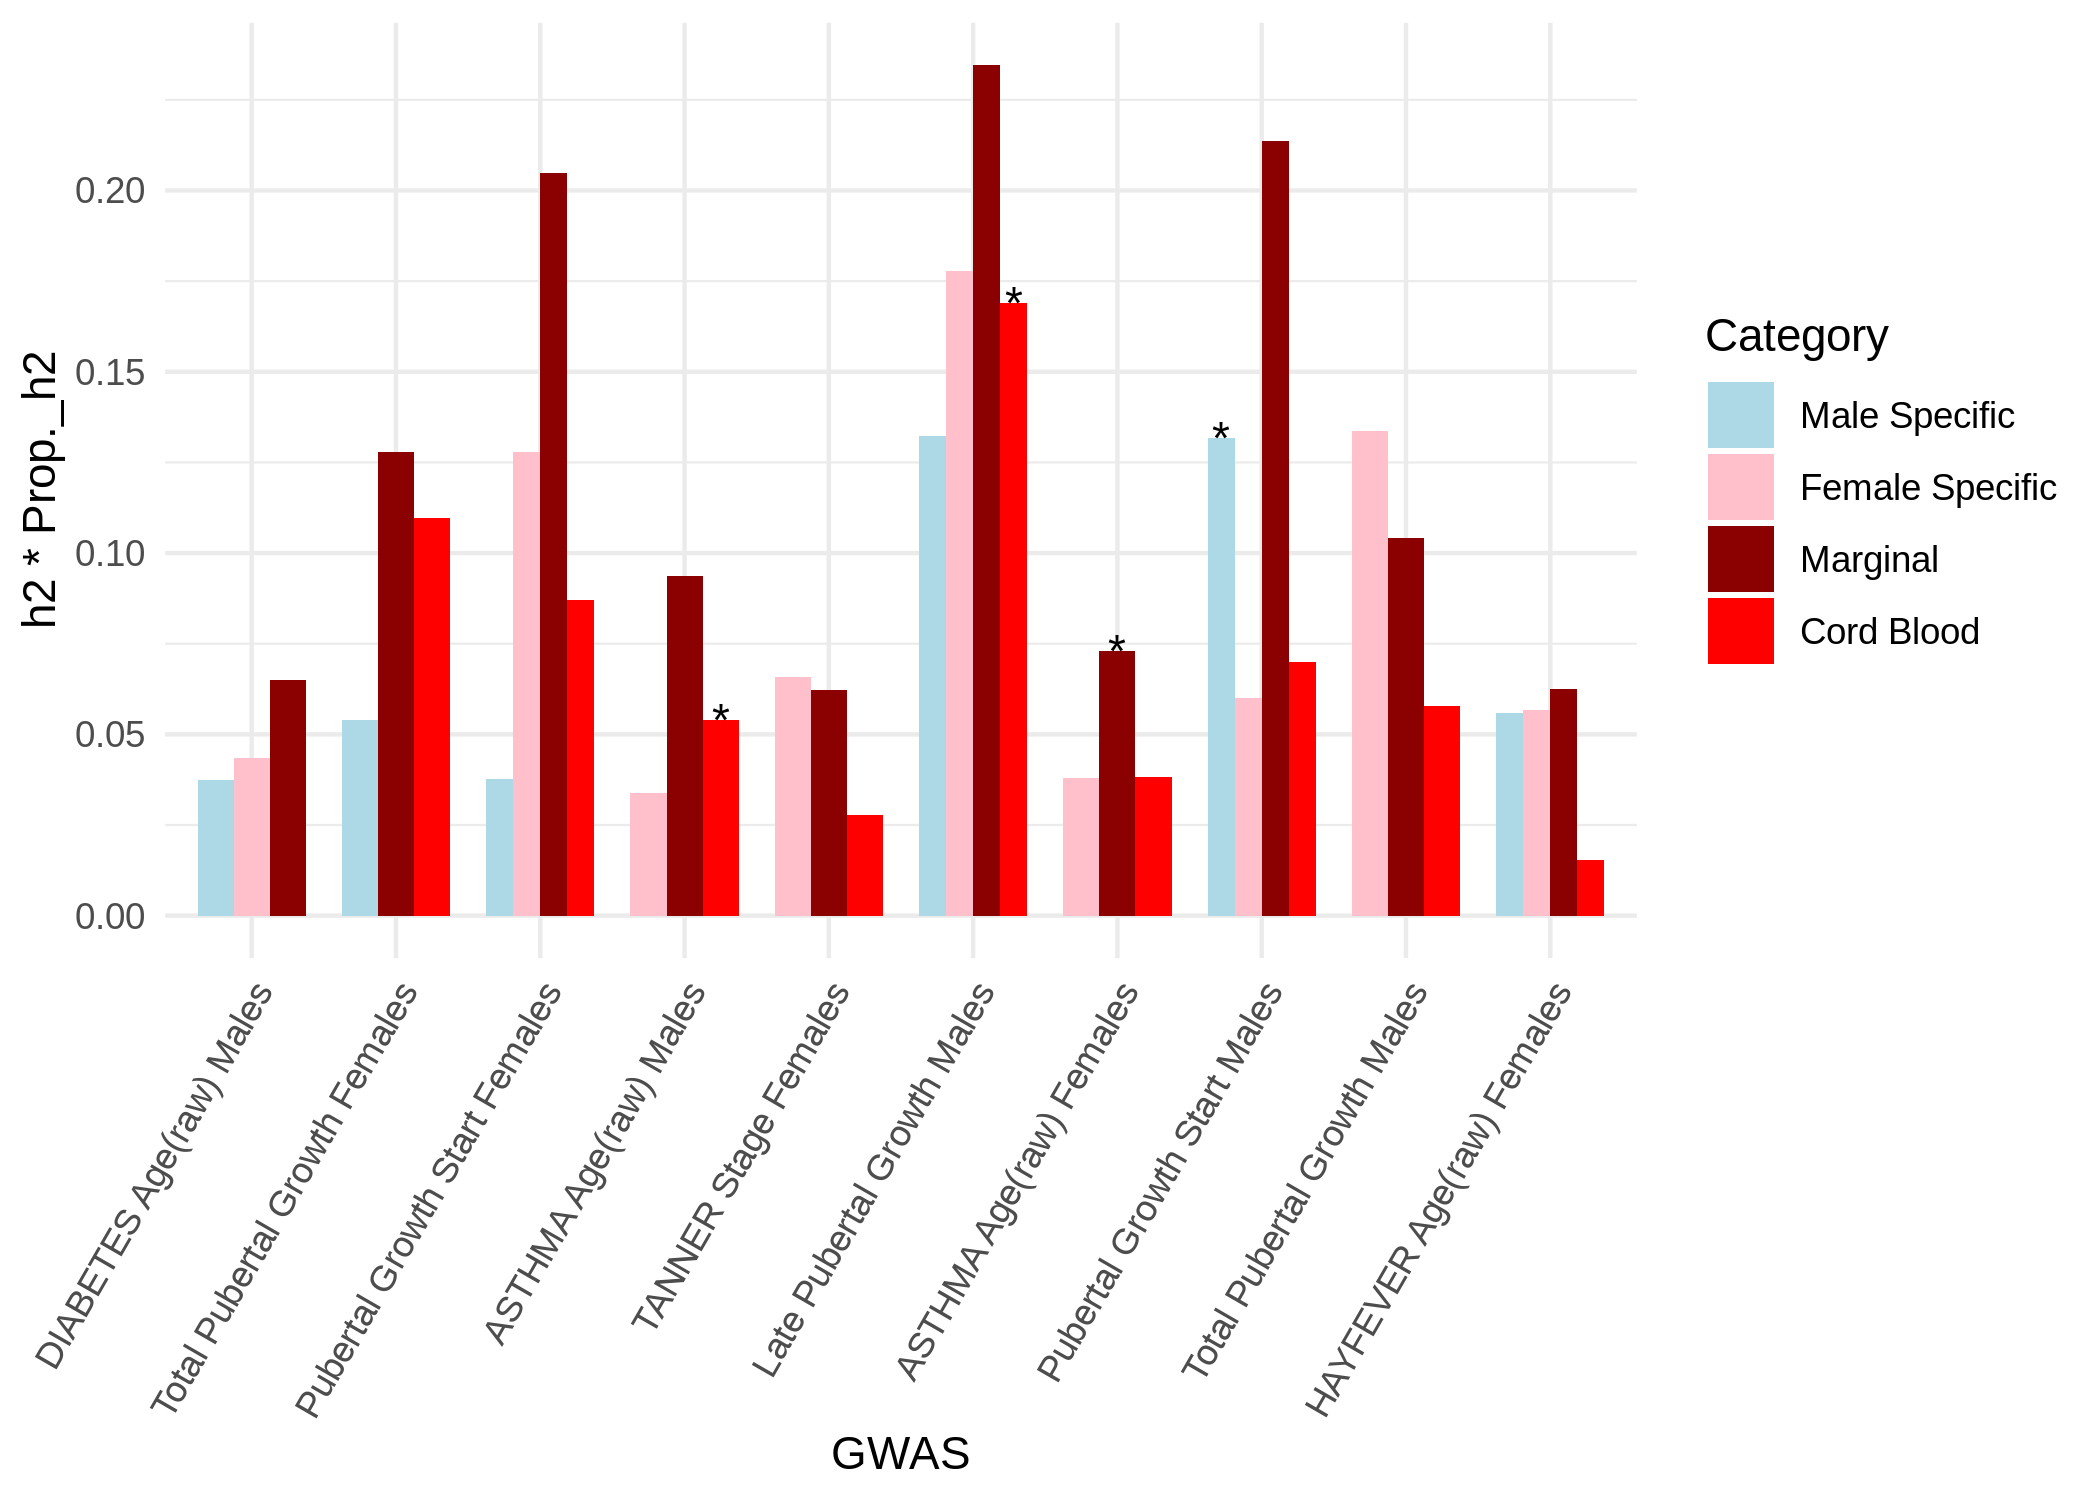

In [40]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
exclude_list <- unique(neonatal_part_heritability_sex_df$GWAS[grepl("norm",neonatal_part_heritability_sex_df$GWAS)])
annot_categories <- c("Male Specific", "Female Specific", "Marginal", "Cord Blood")
order_dt <-     neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_order <- order_dt[order(max_enrich)]$GWAS
annot_order <- annot_categories


ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=h2*Prop._h2,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))
ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        !grepl("Male|Female",GWAS) &
        Category %in% annot_categories & 
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=tau_star,label = ifelse(pnorm(abs(tau_star/tau_se),lower.tail=F)*2 < 0.05,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    labs(y=bquote(tau^"*"))+
    scale_fill_manual(values = c("light blue", "pink","dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

order_sex_dt <-     neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order&
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0,
        .(max_enrich = max(Enrichment)),
        by = "GWAS"
    ]
GWAS_sex_order <- order_sex_dt[order(max_enrich)]$GWAS
ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=Enrichment,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

ggplot(
    neonatal_part_heritability_sex_df[
        !GWAS %in% exclude_list &
        grepl("Male|Female",GWAS) &
        Category %in% annot_order &
        annotation == "bin_CPP_her" &
        Enrichment - Enrichment_std_error > 0
    ]%>% mutate(GWAS = factor(GWAS,levels = GWAS_sex_order),Category = factor(Category,levels = annot_order)),
    aes(fill = Category, x=GWAS,y=h2*Prop._h2,label = ifelse(significant_enrich,"*","")))+
    geom_col(position="dodge",width=0.75) + 
    geom_text(position=position_dodge(width=0.75))+
    scale_fill_manual(values = c("light blue", "pink", "dark red" , "red"))+
    theme_minimal()+
    theme(axis.text.x = element_text(angle=60,hjust=1,vjust=1))

In [22]:
head(
    pgc_part_heritability_baseline_sex_df[
        annotation == "bin_CPP_her" & Category == "Cord Blood"
    ]
)
head(
    pgc_part_heritability_baseline_df[annotation == "bin_CPP_her" & Category == "Male"]
)

annotation,Category,GWAS,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,⋯,Coefficient_z-score,Coefficient_p,h2,h2_std_error,total_SNP,significant_coef,significant_enrich,annot_sd,tau_star,tau_se
<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
bin_CPP_her,Cord Blood,Alcohol (AUDIT),0.112456,0.10472075,0.02129212,0.9312155,0.18933737,0.71807943,-5.794877e-09,⋯,-1.61368125,0.10659658,0.0826,0.0071,1168804,FALSE,FALSE,0.2601717,-2.133368e-02,0.013220507
bin_CPP_her,Cord Blood,Cannabis,0.112456,0.13151837,0.01879023,1.1695098,0.16708966,0.30157319,9.827452e-10,⋯,0.37775466,0.70561286,0.0686,0.0071,1078871,FALSE,FALSE,0.2601717,4.021114e-03,0.010644776
bin_CPP_her,Cord Blood,ASD Females,0.112456,0.08293546,0.02462854,0.7374926,0.21900605,0.24521576,3.571249e-08,⋯,2.14000856,0.03235408,-0.3372,0.0641,1009263,TRUE,FALSE,0.2601717,-2.780974e-02,-0.012995154
bin_CPP_her,Cord Blood,ASD Males,0.112456,0.13464503,0.02224399,1.1973132,0.19780172,0.29392702,-1.519437e-09,⋯,-0.12533377,0.90025932,0.2629,0.0370,982895,FALSE,FALSE,0.2601717,-1.477948e-03,0.011792100
bin_CPP_her,Cord Blood,SCZ,0.112456,0.13730337,0.01459724,1.2209521,0.12980405,0.08704247,-9.700021e-11,⋯,-0.01326507,0.98941632,0.3050,0.0135,1093219,FALSE,FALSE,0.2601717,-9.045655e-05,0.006819154
bin_CPP_her,Cord Blood,MDD,0.112456,0.10248569,0.01072306,0.9113405,0.09535344,0.35499273,-2.138465e-10,⋯,-0.28084555,0.77882887,0.0375,0.0016,1159007,FALSE,FALSE,0.2601717,-1.719558e-03,0.006122790


annotation,Category,GWAS,Prop._SNPs,Prop._h2,Prop._h2_std_error,Enrichment,Enrichment_std_error,Enrichment_p,Coefficient,⋯,Coefficient_z-score,Coefficient_p,h2,h2_std_error,total_SNP,significant_coef,significant_enrich,annot_sd,tau_star,tau_se
<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
bin_CPP_her,Male,Alcohol (AUDIT),0.2916736,0.2929277,0.03692910,1.0042996,0.12661102,0.972936683,-8.256083e-09,⋯,-1.34254483,0.17941941,0.0828,0.0071,1168804,FALSE,FALSE,0.4062026,-0.047339988,0.03526138
bin_CPP_her,Male,Cannabis,0.2916736,0.2415131,0.03910205,0.8280249,0.13406095,0.195139808,-1.047009e-08,⋯,-2.11577451,0.03436399,0.0685,0.0071,1078871,TRUE,FALSE,0.4062026,-0.066984168,0.03165941
bin_CPP_her,Male,ASD Females,0.2916736,0.4671614,0.07532747,1.6016580,0.25825942,0.009882556,-5.653478e-08,⋯,-1.29858121,0.19408769,-0.3367,0.0642,1009263,FALSE,TRUE,0.4062026,0.068836639,-0.05300911
bin_CPP_her,Male,ASD Males,0.2916736,0.3547186,0.04683337,1.2161489,0.16056773,0.173478210,7.454115e-09,⋯,0.35833115,0.72009551,0.2622,0.0370,982895,FALSE,FALSE,0.4062026,0.011350454,0.03167588
bin_CPP_her,Male,SCZ,0.2916736,0.3116995,0.02034629,1.0686584,0.06975702,0.325866448,-7.955276e-10,⋯,-0.07792748,0.93788574,0.3049,0.0136,1093219,FALSE,FALSE,0.4062026,-0.001158638,0.01486815
bin_CPP_her,Male,MDD,0.2916736,0.2463276,0.01964582,0.8445315,0.06735547,0.022472953,-7.300034e-10,⋯,-0.53548840,0.59231218,0.0375,0.0016,1159007,FALSE,TRUE,0.4062026,-0.009164787,0.01711482


## Testing why certain proportion of heritabilities may be negative in one annotation and not the other
Ideas to test:
* The maximum CPP value of SNPs in the 95% set happen to be small for many SNPs overlapping with that GWAS
* The total heritability is small resulting in noise in estimation

In [ ]:
compute_gwas_intersection <- function(annot,all_gwas){
    result<- mclapply(names(all_gwas), function(GWAS) all_gwas[[GWAS]][annot,on="SNP",nomatch=0],mc.cores=16) 
    names(result) <- names(all_gwas)
    return(result)
}

if(!file.exists(here("data","all_annot_struct.RDS"))){
    all_gwas <- mclapply(names(pgc_GWAS_key),function(GWAS) fread(glue("/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/{GWAS}.sumstats.gz")),mc.cores=16)
    names(all_gwas) <- pgc_GWAS_key
    # read in all annotations and merge with each GWAS
    all_annot <- list()
    for(qtl_set in c("marginal","sex_interaction","male", "female", "cord_mqtl")){
        print(glue("{qtl_set}"))
        path <- "/scratch/st-dennisjk-1/wcasazza/1000G_phase3_ldsc/single_delahaye_annotations"
        file_pattern <- glue("{qtl_set}_maxCPP_her..*.annot.gz")
        annots <- rbindlist(mclapply(dir(path,full.names=TRUE,pattern=file_pattern),function(f) fread(f),mc.cores=22))
        all_annot[[qtl_set]] <- compute_gwas_intersection(annots[annots$maxCPP > 0],all_gwas)
    }
    saveRDS(all_annot,here("data","all_annot_struct.RDS"))
}else{
    all_annot <- readRDS(here("data","all_annot_struct.RDS"))
}

In [ ]:
annot_to_plot < -lapply(all_annot, rbindlist, idcol="GWAS")

In [ ]:
options(width= 10, repr.plot.height= 8, repr.plot.res = 300)

for(annot in names(annot_to_plot)){
    p <- ggplot(annot_to_plot[[annot]],aes(-log10(maxCPP),Z)) +
        geom_bin_2d(bins=100) +
        scale_fill_distiller(palette="Spectral") +
        facet_wrap(~GWAS)+
        ggtitle(annot) +
        theme_minimal()
    print(p)
}

In [ ]:
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)
annot_summary<-rbindlist(lapply(annot_to_plot,function(dt)dt[,.(count=.N,meanmaxCPP=mean(maxCPP)),by="GWAS"]),idcol="annotation")
ggplot(annot_summary,aes(x=annotation,y=GWAS,fill=count)) + 
    geom_tile()+        
    scale_fill_distiller(palette="Spectral") +
    ggtitle("SNP Overlap") +
    theme_minimal()
ggplot(annot_summary,aes(x=annotation,y=GWAS,fill=meanmaxCPP)) + 
    geom_tile()+        
    scale_fill_distiller(palette="Spectral") +
    ggtitle("SNP Overlap") +
    theme_minimal()        